# 1.0 Read In Data

In [112]:
# Import libraries needed for linear regression computation
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectPercentile
import scipy.stats as stats
import pylab 
import seaborn as sns
from sklearn.metrics.pairwise import euclidean_distances
from operator import itemgetter

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error
from sklearn import cross_validation
from sklearn.preprocessing import scale

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics

from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
import math

from sklearn.model_selection import KFold
import random
%matplotlib inline

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [8]:
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')
print('Shape of train data:', train_data.shape)
print('Shape of test data:', test_data.shape)

Shape of train data: (1460, 81)
Shape of test data: (1459, 80)


Notice that the train data and the test data do not have the same number of columns. that is beacuse the train data has the SalePrice column.

# 2.0 EDA

First step is to view columns with null values. I will remove columns that have more than 90% of nulls. My gut feel is that fence is not a significant factor in determining house price so I will remove that column as well.

In [9]:
# View at nulls
null_cols = train_data.isnull().sum()
null_cols = pd.DataFrame(null_cols, columns=['count_null'])
null_cols = null_cols.sort_values(by='count_null', ascending=False)
null_cols['percent_null'] = null_cols['count_null']/train_data.shape[0]
print('these are the columns that contain nulls in them:')
print(null_cols)
null_cols = null_cols[null_cols['count_null'] > 0]

# Remove nulls > 90%
train_data = train_data.drop(columns = ['PoolQC', 'MiscFeature', 'Alley', 'Fence'])

# Make a new null data dataframe
null_cols = train_data.isnull().sum()
null_cols = pd.DataFrame(null_cols, columns=['count_null'])
null_cols = null_cols.sort_values(by='count_null', ascending=False)
null_cols['percent_null'] = null_cols['count_null']/train_data.shape[0]
null_cols = null_cols[null_cols['count_null'] > 0]
print('deleted columns with >90% nulls:')
null_cols

these are the columns that contain nulls in them:
               count_null  percent_null
PoolQC               1453      0.995205
MiscFeature          1406      0.963014
Alley                1369      0.937671
Fence                1179      0.807534
FireplaceQu           690      0.472603
LotFrontage           259      0.177397
GarageYrBlt            81      0.055479
GarageCond             81      0.055479
GarageType             81      0.055479
GarageFinish           81      0.055479
GarageQual             81      0.055479
BsmtFinType2           38      0.026027
BsmtExposure           38      0.026027
BsmtQual               37      0.025342
BsmtCond               37      0.025342
BsmtFinType1           37      0.025342
MasVnrArea              8      0.005479
MasVnrType              8      0.005479
Electrical              1      0.000685
Id                      0      0.000000
Functional              0      0.000000
Fireplaces              0      0.000000
KitchenQual             0     

count_null  percent_null
FireplaceQu          690      0.472603
LotFrontage          259      0.177397
GarageType            81      0.055479
GarageYrBlt           81      0.055479
GarageFinish          81      0.055479
GarageQual            81      0.055479
GarageCond            81      0.055479
BsmtExposure          38      0.026027
BsmtFinType2          38      0.026027
BsmtQual              37      0.025342
BsmtCond              37      0.025342
BsmtFinType1          37      0.025342
MasVnrArea             8      0.005479
MasVnrType             8      0.005479
Electrical             1      0.000685

View the data types of the null columns. Most of the columns are null because the house does not have that specific feature. For example, houses that do not have a garage will have a null values for all garage related columns such as GarageYrBlt. 

For numeric columns such as LotFrontage and MasVnrArea, nulls can be replaced with 0. For the object columns containing nulls, nan will be replaced with 'Not Available'.

In [10]:
# View the dtypes of the columns
null_data = train_data[null_cols.index]
print(null_data.dtypes)
print(null_data.head())

train_data['LotFrontage'] = train_data['LotFrontage'].fillna(0)
train_data['MasVnrArea'] = train_data['MasVnrArea'].fillna(0)

# Replace any null values in categorical variables with 'Not Available'
for i in train_data.columns:
    if train_data[i].dtypes == 'object':
        train_data[i] = train_data[i].fillna('Not_Available')

FireplaceQu      object
LotFrontage     float64
GarageType       object
GarageYrBlt     float64
GarageFinish     object
GarageQual       object
GarageCond       object
BsmtExposure     object
BsmtFinType2     object
BsmtQual         object
BsmtCond         object
BsmtFinType1     object
MasVnrArea      float64
MasVnrType       object
Electrical       object
dtype: object
  FireplaceQu  LotFrontage GarageType  GarageYrBlt GarageFinish GarageQual  \
0         NaN         65.0     Attchd       2003.0          RFn         TA   
1          TA         80.0     Attchd       1976.0          RFn         TA   
2          TA         68.0     Attchd       2001.0          RFn         TA   
3          Gd         60.0     Detchd       1998.0          Unf         TA   
4          TA         84.0     Attchd       2000.0          RFn         TA   

  GarageCond BsmtExposure BsmtFinType2 BsmtQual BsmtCond BsmtFinType1  \
0         TA           No          Unf       Gd       TA          GLQ   
1         T

Moving on to columns that are correlated with SalePrice

#### First let's take a look at all the numeric features and their correlation with SalePrice

In [11]:
saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

SalePrice
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.472614
Fireplaces      0.466929
BsmtFinSF1      0.386420
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
HalfBath        0.284108
LotArea         0.263843
BsmtFullBath    0.227122
BsmtUnfSF       0.214479
LotFrontage     0.209624
BedroomAbvGr    0.168213
ScreenPorch     0.111447
PoolArea        0.092404
MoSold          0.046432
3SsnPorch       0.044584
BsmtFinSF2     -0.011378
BsmtHalfBath   -0.016844
MiscVal        -0.021190
Id             -0.021917
LowQualFinSF   -0.025606
YrSold         -0.028923
OverallCond    -0.077856
MSSubClass     -0.084284
EnclosedPorch  -0.128578
KitchenAbvGr   -0.135907

Drop any features that have close to 0 (+- 5) correlation with SalePrice. Will keep BsmtHalf bath to combine with other bath columns

In [12]:
train_data = train_data.drop(columns=['YrSold', 'LowQualFinSF', 'MiscVal', 'BsmtFinSF2', '3SsnPorch', 'MoSold', 'Id'])

Combine the bath features and investigate if it leads to a better correlation. Based on the output below, the combination of the bath column into 'NumBath' leads to a corelation of 0.63!

In [14]:
train_data['NumBath'] = (train_data['FullBath'] + train_data['HalfBath']/2 + 
                       train_data['BsmtHalfBath']/2 + train_data['BsmtFullBath'])

train_data = train_data.drop(columns = ['FullBath', 'HalfBath', 'BsmtHalfBath', 'BsmtFullBath'])
saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

KeyError: 'FullBath'

Let's combine the 1st, 2nd and basement SF and investigate how it correlates with SalePrice. LivingSF has a 0.78 correlation with SalePrice. '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF1' as they will have high correlation with LivingSF feature.

In [15]:
train_data['LivingSF'] = (train_data['1stFlrSF'].fillna(0) + train_data['2ndFlrSF'].fillna(0) 
                               + train_data['TotalBsmtSF'].fillna(0))

train_data = train_data.drop(columns = ['1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF1'])
saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

SalePrice
SalePrice       1.000000
OverallQual     0.790982
LivingSF        0.782260
GrLivArea       0.708624
GarageCars      0.640409
NumBath         0.631731
GarageArea      0.623431
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.472614
Fireplaces      0.466929
WoodDeckSF      0.324413
OpenPorchSF     0.315856
LotArea         0.263843
LotFrontage     0.209624
BedroomAbvGr    0.168213
ScreenPorch     0.111447
PoolArea        0.092404
OverallCond    -0.077856
MSSubClass     -0.084284
EnclosedPorch  -0.128578
KitchenAbvGr   -0.135907

Let's combine the LotArea and LotFrontage features to determine if they will have a better correlation with SalePrice. TotalLotArea has a correlation of 0.26 which is slightly better than the individual correlations of LotArea and LotFrontage. Thus, LotArea and LotFrontage columns will be removed while keeping TotalLotArea

In [16]:
train_data['TotalLotArea'] = train_data['LotArea'] + train_data['LotFrontage']

train_data = train_data.drop(columns = ['LotArea', 'LotFrontage'])
saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

SalePrice
SalePrice       1.000000
OverallQual     0.790982
LivingSF        0.782260
GrLivArea       0.708624
GarageCars      0.640409
NumBath         0.631731
GarageArea      0.623431
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.472614
Fireplaces      0.466929
WoodDeckSF      0.324413
OpenPorchSF     0.315856
TotalLotArea    0.264477
BedroomAbvGr    0.168213
ScreenPorch     0.111447
PoolArea        0.092404
OverallCond    -0.077856
MSSubClass     -0.084284
EnclosedPorch  -0.128578
KitchenAbvGr   -0.135907

Let's combine all the SF features that are outside of the house. For example, Garage, Porches, Pools etc that are not necessarily used for living. The addition of all the features give a correlation of 0.65. 

In [17]:
# combine total SF features outside
train_data['NonLivingSF'] = (train_data['EnclosedPorch'] + train_data['PoolArea'] + train_data['GarageArea'] + 
                             train_data['ScreenPorch'] + train_data['OpenPorchSF'] +  train_data['WoodDeckSF'])

train_data = train_data.drop(columns=['EnclosedPorch', 'PoolArea', 'GarageArea', 'ScreenPorch', 'OpenPorchSF', 'WoodDeckSF'])
saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

SalePrice
SalePrice      1.000000
OverallQual    0.790982
LivingSF       0.782260
GrLivArea      0.708624
NonLivingSF    0.652737
GarageCars     0.640409
NumBath        0.631731
TotRmsAbvGrd   0.533723
YearBuilt      0.522897
YearRemodAdd   0.507101
GarageYrBlt    0.486362
MasVnrArea     0.472614
Fireplaces     0.466929
TotalLotArea   0.264477
BedroomAbvGr   0.168213
OverallCond   -0.077856
MSSubClass    -0.084284
KitchenAbvGr  -0.135907

The MSSubClass field should be seen as a categorical variable instead of a numeric

In [18]:
train_data['MSSubClassCat'] = train_data['MSSubClass'].astype('category')

train_data = train_data.drop(columns = ['MSSubClass'])

saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

SalePrice
SalePrice      1.000000
OverallQual    0.790982
LivingSF       0.782260
GrLivArea      0.708624
NonLivingSF    0.652737
GarageCars     0.640409
NumBath        0.631731
TotRmsAbvGrd   0.533723
YearBuilt      0.522897
YearRemodAdd   0.507101
GarageYrBlt    0.486362
MasVnrArea     0.472614
Fireplaces     0.466929
TotalLotArea   0.264477
BedroomAbvGr   0.168213
OverallCond   -0.077856
KitchenAbvGr  -0.135907

So far we have seen the correlation of all numeric variables with SalePrice. Next step is to see how all the numeric variable are corelated with each other.

From the heatmap below, (GrLivArea and LivingSF), (GarageYrBlt and YearBuilt), (OverallQual and LivingSF), (GarageCars and NonLivingSF) have a strong correlation with each other.

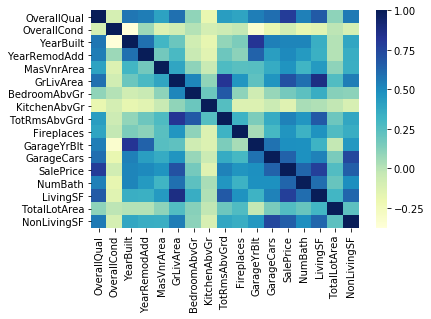

In [19]:
corr = train_data.corr()
sns.heatmap(corr, cmap="YlGnBu")

Let's take a look at the KitchenAbvGr and OverallCond columns. Based on the plots, I will delete the KitchenAbvGr as there is a large variance with houses with one kitchen. OverallCond seems like it should have a positive correlation as well, however, due to the large variance with OverallCond of 5, there is a negative correlation. OverallCond column will be deleted as well

SalePrice
SalePrice      1.000000
OverallQual    0.790982
LivingSF       0.782260
GrLivArea      0.708624
NonLivingSF    0.652737
GarageCars     0.640409
NumBath        0.631731
TotRmsAbvGrd   0.533723
YearBuilt      0.522897
YearRemodAdd   0.507101
GarageYrBlt    0.486362
MasVnrArea     0.472614
Fireplaces     0.466929
TotalLotArea   0.264477
BedroomAbvGr   0.168213

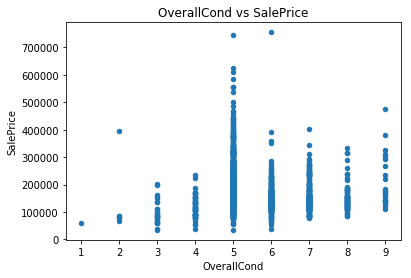

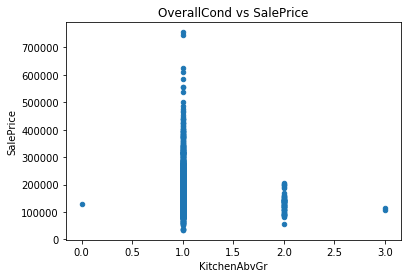

In [20]:
OverallCond_vs_SalePrice = train_data.plot(
    kind="scatter", x='OverallCond', y='SalePrice', title = "OverallCond vs SalePrice")

KitchenAbvGr_vs_SalePrice = train_data.plot(
    kind="scatter", x='KitchenAbvGr', y='SalePrice', title = "OverallCond vs SalePrice")

train_data = train_data.drop(columns = ['KitchenAbvGr', 'OverallCond'])

saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

Before we deal with features that are highly correlated with each other, let's take a look at the categorical variables. Below are all the categorical vairable columns

In [21]:
train_data.select_dtypes(include='object').columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

Removing BsmtFinType2 and BsmtFinType1 as their respective numeric features were dropped above. Furthermore, notice some features are the secondary feature of another (eg Exterior1st_VinylSd	Exterior2nd_VinylSd). The secondary feature will be removed in this case (i.e 'Exterior2nd', 'Condition2').

In [22]:
train_data = train_data.drop(columns= ['BsmtFinType1', 'BsmtFinType2', 'Exterior2nd', 'Condition2'])

Let's change 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'GarageQual', 'GarageCond' to numeric vairables (similar to OverallCond)

SalePrice
SalePrice         1.000000
OverallQual       0.790982
LivingSF          0.782260
GrLivArea         0.708624
ExterQualInt      0.682639
KitchenQualInt    0.659600
NonLivingSF       0.652737
GarageCars        0.640409
NumBath           0.631731
BsmtQualInt       0.604816
TotRmsAbvGrd      0.533723
YearBuilt         0.522897
YearRemodAdd      0.507101
GarageYrBlt       0.486362
MasVnrArea        0.472614
Fireplaces        0.466929
BsmtExposureInt   0.369390
GarageQualInt     0.276758
TotalLotArea      0.264477
GarageCondInt     0.264117
BsmtCondInt       0.215620
BedroomAbvGr      0.168213
ExterCondInt      0.017706

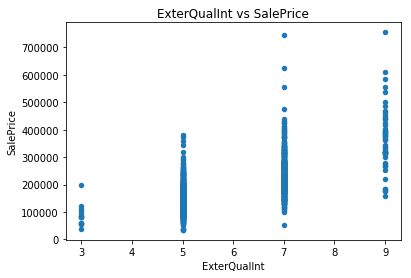

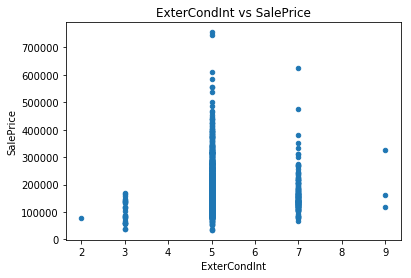

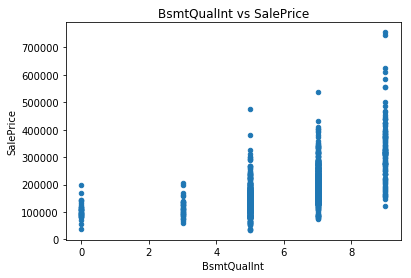

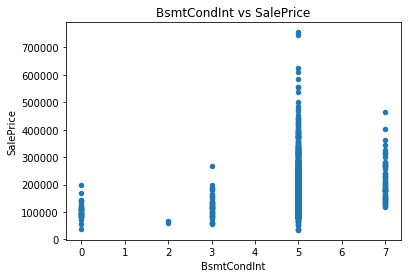

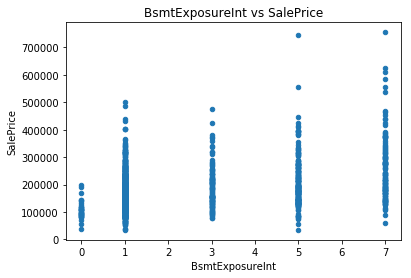

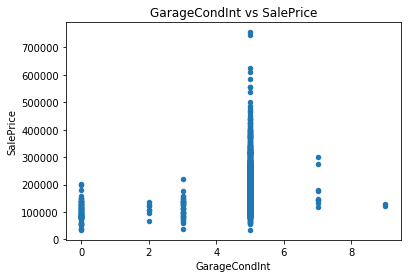

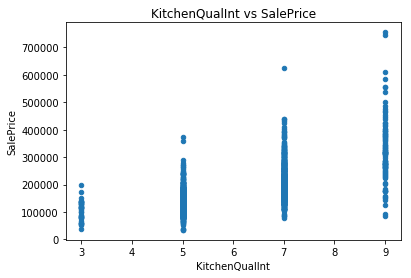

In [23]:
# Add int variables for ExterQual and ExterCond
train_data['ExterQualInt'] =  np.where(train_data['ExterQual'] == "Ex", 9, 
                                        np.where(train_data['ExterQual'] == "Gd", 7, 
                                                np.where(train_data['ExterQual'] == "TA", 5, 
                                                        np.where(train_data['ExterQual'] == "Fa", 3, 
                                                                np.where(train_data['ExterQual'] == "Po", 2,0)))))
train_data['ExterCondInt'] =  np.where(train_data['ExterCond'] == "Ex", 9, 
                                         np.where(train_data['ExterCond'] == "Gd", 7, 
                                                np.where(train_data['ExterCond'] == "TA", 5, 
                                                        np.where(train_data['ExterCond'] == "Fa", 3, 
                                                                np.where(train_data['ExterCond'] == "Po", 2,0)))))

# Add int variables for all categorical basement variables
train_data['BsmtQualInt'] =  np.where(train_data['BsmtQual'] == "Ex", 9, 
                                        np.where(train_data['BsmtQual'] == "Gd", 7, 
                                                np.where(train_data['BsmtQual'] == "TA", 5, 
                                                        np.where(train_data['BsmtQual'] == "Fa", 3, 
                                                                np.where(train_data['BsmtQual'] == "Po", 2,0)))))

train_data['BsmtCondInt'] =  np.where(train_data['BsmtCond'] == "Ex", 9, 
                                        np.where(train_data['BsmtCond'] == "Gd", 7, 
                                                np.where(train_data['BsmtCond'] == "TA", 5, 
                                                        np.where(train_data['BsmtCond'] == "Fa", 3, 
                                                                np.where(train_data['BsmtCond'] == "Po", 2,0)))))

train_data['BsmtExposureInt'] =  np.where(train_data['BsmtExposure'] == "Gd", 7, 
                                        np.where(train_data['BsmtExposure'] == "Av", 5, 
                                                np.where(train_data['BsmtExposure'] == "Mn", 3, 
                                                        np.where(train_data['BsmtExposure'] == "No", 1, 0))))

# Add int variables for GarageQual and GarageCond
train_data['GarageCondInt'] =  np.where(train_data['GarageCond'] == "Ex", 9, 
                                        np.where(train_data['GarageCond'] == "Gd", 7, 
                                                np.where(train_data['GarageCond'] == "TA", 5, 
                                                        np.where(train_data['GarageCond'] == "Fa", 3, 
                                                                np.where(train_data['GarageCond'] == "Po", 2,0)))))

train_data['GarageQualInt'] =  np.where(train_data['GarageQual'] == "Ex", 9, 
                                        np.where(train_data['GarageQual'] == "Gd", 7, 
                                                np.where(train_data['GarageQual'] == "TA", 5, 
                                                        np.where(train_data['GarageQual'] == "Fa", 3, 
                                                                np.where(train_data['GarageQual'] == "Po", 2,0)))))
# Add interaction variables for KitchenQual
train_data['KitchenQualInt'] =  np.where(train_data['KitchenQual'] == "Ex", 9, 
                                        np.where(train_data['KitchenQual'] == "Gd", 7, 
                                                np.where(train_data['KitchenQual'] == "TA", 5, 
                                                        np.where(train_data['KitchenQual'] == "Fa", 3, 
                                                                np.where(train_data['KitchenQual'] == "Po", 2,0)))))

train_data = train_data.drop(columns = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
                                        'BsmtExposure', 'GarageCond', 'GarageQual', 'KitchenQual'])

ExterQualInt_vs_SalePrice = train_data.plot(
    kind="scatter", x='ExterQualInt', y='SalePrice', title = "ExterQualInt vs SalePrice")
ExterCondInt_vs_SalePrice = train_data.plot(
    kind="scatter", x='ExterCondInt', y='SalePrice', title = "ExterCondInt vs SalePrice")
BsmtQualInt_vs_SalePrice = train_data.plot(
    kind="scatter", x='BsmtQualInt', y='SalePrice', title = "BsmtQualInt vs SalePrice")
BsmtCondInt_vs_SalePrice = train_data.plot(
    kind="scatter", x='BsmtCondInt', y='SalePrice', title = "BsmtCondInt vs SalePrice")
BsmtExposureInt_vs_SalePrice = train_data.plot(
    kind="scatter", x='BsmtExposureInt', y='SalePrice', title = "BsmtExposureInt vs SalePrice")
GarageCondInt_vs_SalePrice = train_data.plot(
    kind="scatter", x='GarageCondInt', y='SalePrice', title = "GarageCondInt vs SalePrice")
KitchenQualInt_vs_SalePrice = train_data.plot(
    kind="scatter", x='KitchenQualInt', y='SalePrice', title = "KitchenQualInt vs SalePrice")
                                        
saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

Delete ExterCondInt as it has a correlation of almost 0. Based on the graphs, BsmtExposureInt, GarageCondInt and BsmtCondInt will be deleted as they visually do not have a clear linear relationship.

In [24]:
train_data = train_data.drop(columns= ['ExterCondInt', 'BsmtExposureInt', 'GarageCondInt', 'BsmtCondInt'])

Let's one hot encode the rest of the categorical variables and delete any features that have 'Not Available' present in the title

In [25]:
train_data = pd.get_dummies(train_data, drop_first=True)

# Delete any Not_Available columns (no use in the model)
train_data = train_data[train_data.columns.drop(list(train_data.filter(regex='Not_Available')))]

print('Shape of the training dataset is now:', train_data.shape)

Shape of the training dataset is now: (1460, 174)


Let look at how each feature correlates with SalePrice. I will delete all features that have 0 +- 5% correlation with SalePrice as these features will not be effective in predicting SalePrice. The following are features that will be deleted from the model:

In [26]:
saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)
saleprice_corr = saleprice_corr.reset_index()
saleprice_corr.columns = ['Feature', 'SalePrice']
features_to_delete = saleprice_corr[(saleprice_corr['SalePrice'] < 0.05) & (saleprice_corr['SalePrice'] > -0.05)]
features_to_delete 

Feature  SalePrice
23            Street_Pave   0.041036
25           LotShape_IR3   0.036720
28        LandContour_Low   0.045528
29        LandContour_Lvl  -0.027545
30       Utilities_NoSeWa  -0.014314
32          LotConfig_FR2  -0.006859
33          LotConfig_FR3   0.018186
35          LandSlope_Mod   0.042981
36          LandSlope_Sev   0.027998
37   Neighborhood_Blueste  -0.020250
44   Neighborhood_Gilbert   0.035940
49   Neighborhood_NPkVill  -0.037910
50    Neighborhood_NWAmes   0.023483
56   Neighborhood_SawyerW   0.014560
63        Condition1_PosA   0.042017
64        Condition1_PosN   0.049541
65        Condition1_RRAe  -0.046651
66        Condition1_RRAn   0.005893
67        Condition1_RRNe   0.004584
68        Condition1_RRNn   0.023236
72        BldgType_TwnhsE   0.003804
75      HouseStyle_2.5Fin   0.036526
76      HouseStyle_2.5Unf  -0.025856
79        HouseStyle_SLvl  -0.038645
81      RoofStyle_Gambrel  -0.035121
83      RoofStyle_Mansard  -0.000308
84         RoofStyle_Shed   0.020557
86       RoofMatl_Membran   0.019970
87         RoofMatl_Metal  -0.000304
88          RoofMatl_Roll  -0.014479
89       RoofMatl_Tar&Grv   0.004921
90       RoofMatl_WdShake   0.044643
92    Exterior1st_AsphShn  -0.026677
94    Exterior1st_BrkFace   0.032371
95     Exterior1st_CBlock  -0.025028
98    Exterior1st_ImStucc   0.026729
100   Exterior1st_Plywood  -0.017719
101     Exterior1st_Stone   0.036181
102    Exterior1st_Stucco  -0.029802
112      Foundation_Stone  -0.012103
113       Foundation_Wood   0.002711
115          Heating_GasW  -0.020103
117          Heating_OthW  -0.025730
121          HeatingQC_Po  -0.030962
125      Electrical_FuseP  -0.047761
126        Electrical_Mix  -0.037555
131        Functional_Mod  -0.016073
132        Functional_Sev  -0.017116
134        FireplaceQu_Fa  -0.026086
139    GarageType_Basment  -0.029425
147          SaleType_CWD   0.019588
148          SaleType_Con   0.041357
149        SaleType_ConLD  -0.041791
150        SaleType_ConLI   0.014371
151        SaleType_ConLw  -0.027475
153          SaleType_Oth  -0.034895
156  SaleCondition_Alloca  -0.015525
157  SaleCondition_Family  -0.046480
161      MSSubClassCat_40  -0.016366
165      MSSubClassCat_70  -0.036883
166      MSSubClassCat_75   0.015265
167      MSSubClassCat_80  -0.028646
168      MSSubClassCat_85  -0.049137

In [27]:
features_to_delete = features_to_delete['Feature'].unique()
train_data = train_data.drop(columns = features_to_delete)
print('Shape of the training dataset is now:', train_data.shape)

Shape of the training dataset is now: (1460, 111)


So far, features that have a low correlation with SalePrice have been removed from the dataset. However, collinearity between features itself must be taken care of as well.

In [28]:
saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
# saleprice_corr = saleprice_corr.reset_index()
# saleprice_corr.columns = ['Feature', 'SalePrice']
saleprice_corr.sort_values(by='SalePrice', ascending = False)

SalePrice
SalePrice               1.000000
OverallQual             0.790982
LivingSF                0.782260
GrLivArea               0.708624
ExterQualInt            0.682639
KitchenQualInt          0.659600
NonLivingSF             0.652737
GarageCars              0.640409
NumBath                 0.631731
BsmtQualInt             0.604816
TotRmsAbvGrd            0.533723
YearBuilt               0.522897
YearRemodAdd            0.507101
Foundation_PConc        0.497734
GarageYrBlt             0.486362
MasVnrArea              0.472614
Fireplaces              0.466929
Neighborhood_NridgHt    0.402149
MSSubClassCat_60        0.377197
SaleType_New            0.357509
SaleCondition_Partial   0.352060
FireplaceQu_Gd          0.339329
GarageType_Attchd       0.335961
MasVnrType_Stone        0.330476
Neighborhood_NoRidge    0.330424
Exterior1st_VinylSd     0.305009
GarageQualInt           0.276758
TotalLotArea            0.264477
CentralAir_Y            0.251328
MSZoning_RL             0.245063
HouseStyle_2Story       0.242880
Electrical_SBrkr        0.241896
RoofStyle_Hip           0.235897
GarageType_BuiltIn      0.235449
PavedDrive_Y            0.231968
Neighborhood_StoneBr    0.215363
MasVnrType_BrkFace      0.198191
GarageFinish_RFn        0.169792
RoofMatl_WdShngl        0.169324
BedroomAbvGr            0.168213
FireplaceQu_TA          0.163147
LotConfig_CulDSac       0.141818
Neighborhood_Somerst    0.140058
Exterior1st_CemntBd     0.133492
Neighborhood_Timber     0.126236
LotShape_IR2            0.126096
LandContour_HLS         0.120014
Functional_Typ          0.116462
Condition1_Norm         0.112968
Heating_GasA            0.092529
MSZoning_FV             0.089950
Neighborhood_CollgCr    0.072626
Neighborhood_Crawfor    0.071160
Neighborhood_Veenker    0.063471
MSSubClassCat_120       0.062944
Neighborhood_ClearCr    0.055718
SaleCondition_AdjLand  -0.050686
Exterior1st_BrkComm    -0.051264
Exterior1st_WdShing    -0.051317
Neighborhood_Mitchel   -0.057845
Heating_Wall           -0.058622
HouseStyle_1Story      -0.061811
Neighborhood_SWISU     -0.063705
Functional_Min1        -0.064051
MSZoning_RH            -0.065429
Functional_Maj2        -0.070214
GarageType_CarPort     -0.070371
Functional_Min2        -0.071320
FireplaceQu_Po         -0.075916
LotConfig_Inside       -0.080538
MSSubClassCat_180      -0.082215
MSSubClassCat_45       -0.082912
HouseStyle_1.5Unf      -0.087686
PavedDrive_P           -0.088623
Heating_Grav           -0.092338
HouseStyle_SFoyer      -0.093090
MSSubClassCat_190      -0.093578
Exterior1st_HdBoard    -0.095148
BldgType_2fmCon        -0.097348
BldgType_Twnhs         -0.098730
Neighborhood_BrDale    -0.101303
RoofMatl_CompShg       -0.104505
Neighborhood_MeadowV   -0.112544
MSSubClassCat_160      -0.113042
BldgType_Duplex        -0.114655
MSSubClassCat_90       -0.114655
Condition1_Feedr       -0.117329
Foundation_Slab        -0.119740
Electrical_FuseF       -0.126601
Neighborhood_Sawyer    -0.128394
HeatingQC_Fa           -0.133758
HeatingQC_Gd           -0.134722
Neighborhood_BrkSide   -0.143648
SaleCondition_Normal   -0.153990
MSSubClassCat_50       -0.156692
Exterior1st_Wd Sdng    -0.158619
Neighborhood_IDOTRR    -0.164056
Exterior1st_MetalSd    -0.167068
Neighborhood_Edwards   -0.179949
Neighborhood_NAmes     -0.188513
Neighborhood_OldTown   -0.192189
RoofStyle_Gable        -0.224744
MSSubClassCat_30       -0.238640
SaleType_WD            -0.242598
LotShape_Reg           -0.267672
MSZoning_RM            -0.288065
HeatingQC_TA           -0.312677
Foundation_CBlock      -0.343263
GarageType_Detchd      -0.354141
MasVnrType_None        -0.374468
GarageFinish_Unf       -0.410608

The following are variables that have greater than 0.6 correlation with each other. For any features that have a correlation value greater than 90, I will remove the feature that has the least correlation with SalePrice.

In [29]:
correlation_mat = train_data.corr()
corr_df = []
for i in range(0, correlation_mat.shape[0], 1):
    for j in range(i+1, correlation_mat.shape[1],1):
        if abs(correlation_mat.iloc[i,j]) >= 0.60:
            corr_df.append([correlation_mat.columns[i], correlation_mat.columns[j], correlation_mat.iloc[i,j]])
corr_df = pd.DataFrame(corr_df, columns=['col1', 'col2', 'correlation'])
corr_df = corr_df.sort_values(by='correlation', ascending=False)
corr_df
# https://onlinecourses.science.psu.edu/stat501/node/346/

col1                   col2  correlation
34       BldgType_Duplex       MSSubClassCat_90     1.000000
46          SaleType_New  SaleCondition_Partial     0.986819
33       BldgType_2fmCon      MSSubClassCat_190     0.983395
36     HouseStyle_1.5Unf       MSSubClassCat_45     0.925181
14             GrLivArea               LivingSF     0.874373
30           MSZoning_FV   Neighborhood_Somerst     0.862807
6              YearBuilt            GarageYrBlt     0.825667
12             GrLivArea           TotRmsAbvGrd     0.825489
1            OverallQual              SalePrice     0.790982
21             SalePrice               LivingSF     0.782260
38     HouseStyle_2Story       MSSubClassCat_60     0.762743
19            GarageCars            NonLivingSF     0.747685
3            OverallQual           ExterQualInt     0.726278
28          ExterQualInt         KitchenQualInt     0.716122
13             GrLivArea              SalePrice     0.708624
23             SalePrice           ExterQualInt     0.682639
15          BedroomAbvGr           TotRmsAbvGrd     0.676620
5            OverallQual         KitchenQualInt     0.673331
16          TotRmsAbvGrd               LivingSF     0.672596
2            OverallQual               LivingSF     0.668155
17           GarageYrBlt       Foundation_PConc     0.661998
25             SalePrice         KitchenQualInt     0.659600
22             SalePrice            NonLivingSF     0.652737
8              YearBuilt       Foundation_PConc     0.651199
4            OverallQual            BsmtQualInt     0.646120
9           YearRemodAdd            GarageYrBlt     0.642277
18            GarageCars              SalePrice     0.640409
47           SaleType_WD   SaleCondition_Normal     0.634322
20             SalePrice                NumBath     0.631731
7              YearBuilt            BsmtQualInt     0.630486
27              LivingSF            NonLivingSF     0.625531
10          YearRemodAdd         KitchenQualInt     0.625316
35        BldgType_Twnhs      MSSubClassCat_160     0.620936
43     GarageType_Detchd       GarageFinish_Unf     0.609983
29          ExterQualInt       Foundation_PConc     0.604901
24             SalePrice            BsmtQualInt     0.604816
26               NumBath               LivingSF     0.604324
0            OverallQual             GarageCars     0.600671
32      Condition1_Feedr        Condition1_Norm    -0.608318
45          SaleType_New   SaleCondition_Normal    -0.645698
49  SaleCondition_Normal  SaleCondition_Partial    -0.654323
37     HouseStyle_1Story      HouseStyle_2Story    -0.658517
11            MasVnrArea        MasVnrType_None    -0.679898
42     GarageType_Attchd      GarageType_Detchd    -0.729272
48           SaleType_WD  SaleCondition_Partial    -0.769559
44          SaleType_New            SaleType_WD    -0.773680
41     Foundation_CBlock       Foundation_PConc    -0.781558
40    MasVnrType_BrkFace        MasVnrType_None    -0.797225
31           MSZoning_RL            MSZoning_RM    -0.808585
39       RoofStyle_Gable          RoofStyle_Hip    -0.933462

I have added a for loop in the run_models_input method to remove one out of the two features with high corrleations with each other. I remove the feature that has a lower correlation with SalePrice

Let's describe the data and see if there are any outliers. First, look at the numerical features with high ranges such as LivingSF, NonLivingSF, TotalLotArea and GrLivArea. Remove outliers in the column

In [30]:
# Look at outliers
train_data.describe()

OverallQual    YearBuilt  YearRemodAdd   MasVnrArea    GrLivArea  \
count  1460.000000  1460.000000   1460.000000  1460.000000  1460.000000   
mean      6.099315  1971.267808   1984.865753   103.117123  1515.463699   
std       1.382997    30.202904     20.645407   180.731373   525.480383   
min       1.000000  1872.000000   1950.000000     0.000000   334.000000   
25%       5.000000  1954.000000   1967.000000     0.000000  1129.500000   
50%       6.000000  1973.000000   1994.000000     0.000000  1464.000000   
75%       7.000000  2000.000000   2004.000000   164.250000  1776.750000   
max      10.000000  2010.000000   2010.000000  1600.000000  5642.000000   

       BedroomAbvGr  TotRmsAbvGrd   Fireplaces  GarageYrBlt   GarageCars  \
count   1460.000000   1460.000000  1460.000000  1379.000000  1460.000000   
mean       2.866438      6.517808     0.613014  1978.506164     1.767123   
std        0.815778      1.625393     0.644666    24.689725     0.747315   
min        0.000000      2.000000     0.000000  1900.000000     0.000000   
25%        2.000000      5.000000     0.000000  1961.000000     1.000000   
50%        3.000000      6.000000     1.000000  1980.000000     2.000000   
75%        3.000000      7.000000     1.000000  2002.000000     2.000000   
max        8.000000     14.000000     3.000000  2010.000000     4.000000   

           SalePrice      NumBath      LivingSF   TotalLotArea  NonLivingSF  \
count    1460.000000  1460.000000   1460.000000    1460.000000  1460.000000   
mean   180921.195890     2.210616   2567.048630   10574.451370   653.658904   
std     79442.502883     0.785399    821.714421    9984.816535   301.728991   
min     34900.000000     1.000000    334.000000    1324.000000     0.000000   
25%    129975.000000     2.000000   2009.500000    7612.500000   461.500000   
50%    163000.000000     2.000000   2474.000000    9524.500000   629.000000   
75%    214000.000000     2.500000   3004.000000   11677.000000   829.000000   
max    755000.000000     6.000000  11752.000000  215395.000000  2404.000000   

       ExterQualInt  BsmtQualInt  GarageQualInt  KitchenQualInt  MSZoning_FV  \
count   1460.000000  1460.000000    1460.000000     1460.000000  1460.000000   
mean       5.791781     6.003425       4.678082        6.023288     0.044521   
std        1.148561     1.656396       1.227037        1.327520     0.206319   
min        3.000000     0.000000       0.000000        3.000000     0.000000   
25%        5.000000     5.000000       5.000000        5.000000     0.000000   
50%        5.000000     7.000000       5.000000        5.000000     0.000000   
75%        7.000000     7.000000       5.000000        7.000000     0.000000   
max        9.000000     9.000000       9.000000        9.000000     1.000000   

       MSZoning_RH  MSZoning_RL  MSZoning_RM  LotShape_IR2  LotShape_Reg  \
count  1460.000000  1460.000000  1460.000000   1460.000000   1460.000000   
mean      0.010959     0.788356     0.149315      0.028082      0.633562   
std       0.104145     0.408614     0.356521      0.165264      0.481996   
min       0.000000     0.000000     0.000000      0.000000      0.000000   
25%       0.000000     1.000000     0.000000      0.000000      0.000000   
50%       0.000000     1.000000     0.000000      0.000000      1.000000   
75%       0.000000     1.000000     0.000000      0.000000      1.000000   
max       1.000000     1.000000     1.000000      1.000000      1.000000   

       LandContour_HLS  LotConfig_CulDSac  LotConfig_Inside  \
count      1460.000000        1460.000000       1460.000000   
mean          0.034247           0.064384          0.720548   
std           0.181924           0.245519          0.448884   
min           0.000000           0.000000          0.000000   
25%           0.000000           0.000000          0.000000   
50%           0.000000           0.000000          1.000000   
75%           0.000000           0.000000          1.000000   
max           1.000000  

Note that removing outliers for living SF made the correlation factor with SalePrice increase from 0.782260 to 0.813394

# Feature Enginerring

In [2]:
# def feature_eng(model_data, max_predictor_corr_delete, max_predictor_corr_dim_red, min_response_corr):
def feature_eng(model_data, min_corr_saleprice, corr_features_thres, is_train):

    id_col = model_data['Id']
    
    model_data['GarageYrBlt'] = model_data['GarageYrBlt'].fillna(0)
    model_data['GarageCars'] = model_data['GarageCars'].fillna(0)
    model_data['LotFrontage'] = model_data['LotFrontage'].fillna(0)
    model_data['MasVnrArea'] = model_data['MasVnrArea'].fillna(0)

    # Replace any null values in categorical variables with 'Not Available'
    for i in model_data.columns:
        if model_data[i].dtypes == 'object':
            model_data[i] = model_data[i].fillna('Not_Available')
            
    model_data['NumBath'] = (model_data['FullBath'].fillna(0) + model_data['HalfBath'].fillna(0)/2 + 
                       model_data['BsmtHalfBath'].fillna(0)/2 + model_data['BsmtFullBath'].fillna(0))
    
    
    model_data['LivingSF'] = (model_data['1stFlrSF'].fillna(0) + model_data['2ndFlrSF'].fillna(0) 
                               + model_data['TotalBsmtSF'].fillna(0))

    
    model_data['TotalLotArea'] = model_data['LotArea'] + model_data['LotFrontage']

    
    
    # combine total SF features outside
    model_data['NonLivingSF'] = (model_data['EnclosedPorch'].fillna(0) + model_data['PoolArea'].fillna(0) + 
                                 model_data['GarageArea'].fillna(0) + model_data['ScreenPorch'].fillna(0) + 
                                 model_data['OpenPorchSF'].fillna(0) +  model_data['WoodDeckSF'].fillna(0))
    
    model_data['MSSubClassCat'] = model_data['MSSubClass'].astype('category')
    
    
    # Add int variables for ExterQual and ExterCond
    model_data['ExterQualInt'] =  np.where(model_data['ExterQual'] == "Ex", 9, 
                                            np.where(model_data['ExterQual'] == "Gd", 7, 
                                                    np.where(model_data['ExterQual'] == "TA", 5, 
                                                            np.where(model_data['ExterQual'] == "Fa", 3, 
                                                                    np.where(model_data['ExterQual'] == "Po", 2,0)))))

    # Add int variables for all categorical basement variables
    model_data['BsmtQualInt'] =  np.where(model_data['BsmtQual'] == "Ex", 9, 
                                            np.where(model_data['BsmtQual'] == "Gd", 7, 
                                                    np.where(model_data['BsmtQual'] == "TA", 5, 
                                                            np.where(model_data['BsmtQual'] == "Fa", 3, 
                                                                    np.where(model_data['BsmtQual'] == "Po", 2,0)))))


    model_data['GarageQualInt'] =  np.where(model_data['GarageQual'] == "Ex", 9, 
                                            np.where(model_data['GarageQual'] == "Gd", 7, 
                                                    np.where(model_data['GarageQual'] == "TA", 5, 
                                                            np.where(model_data['GarageQual'] == "Fa", 3, 
                                                                    np.where(model_data['GarageQual'] == "Po", 2,0)))))
    # Add interaction variables for KitchenQual
    model_data['KitchenQualInt'] =  np.where(model_data['KitchenQual'] == "Ex", 9, 
                                            np.where(model_data['KitchenQual'] == "Gd", 7, 
                                                    np.where(model_data['KitchenQual'] == "TA", 5, 
                                                            np.where(model_data['KitchenQual'] == "Fa", 3, 
                                                                    np.where(model_data['KitchenQual'] == "Po", 2,0)))))

    model_data = model_data.drop(columns=['EnclosedPorch', 'PoolArea', 'GarageArea', 'ScreenPorch', 
                                          'OpenPorchSF', 'WoodDeckSF', 'MSSubClass', 'KitchenAbvGr', 
                                          'OverallCond', 'BsmtFinType1', 'BsmtFinType2', 'Exterior2nd', 
                                          'Condition2', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'BsmtUnfSF',
                                          'BsmtFinSF1', 'LotArea', 'LotFrontage', 'YrSold', 'LowQualFinSF', 
                                          'MiscVal', 'BsmtFinSF2', '3SsnPorch', 'MoSold', 'Id', 'FullBath', 
                                          'HalfBath', 'BsmtHalfBath', 'BsmtFullBath', 'PoolQC', 'MiscFeature', 
                                          'Alley', 'Fence', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
                                          'BsmtExposure', 'GarageCond', 'GarageQual', 'KitchenQual'])
    
    model_data = pd.get_dummies(model_data, drop_first=True)

    # Delete any Not_Available columns (no use in the model)
    model_data = model_data[model_data.columns.drop(list(model_data.filter(regex='Not_Available')))]
#     print(model_data.isnull().sum())
    if is_train:
        # Delete any variables that have less than a threshold of correlation with SalePrice
        saleprice_corr = model_data[model_data.columns].corr()['SalePrice']
        saleprice_corr = pd.DataFrame(saleprice_corr)
        saleprice_corr.sort_values(by='SalePrice', ascending = False)
        saleprice_corr = saleprice_corr.reset_index()
        saleprice_corr.columns = ['Feature', 'SalePrice']
        features_to_delete = saleprice_corr[
            (saleprice_corr['SalePrice'] < min_corr_saleprice) & (saleprice_corr['SalePrice'] > -min_corr_saleprice)]
        features_to_delete = features_to_delete['Feature'].unique()
        model_data = model_data.drop(columns = features_to_delete)
        saleprice_corr = saleprice_corr.set_index('Feature')

        # The following shows correlations of features with each other
        correlation_mat = model_data.corr()
        corr_df = []
        for i in range(0, correlation_mat.shape[0], 1):
            for j in range(i+1, correlation_mat.shape[1],1):
                if abs(correlation_mat.iloc[i,j]) >= corr_features_thres:
                    corr_df.append([correlation_mat.columns[i], correlation_mat.columns[j], correlation_mat.iloc[i,j]])
        corr_df = pd.DataFrame(corr_df, columns=['col1', 'col2', 'correlation'])
        corr_df = corr_df.sort_values(by='correlation', ascending=False)
#         print(corr_df)
        
        # Deletes one of two highly correlated features if it is greater than the threshold. Deletes feature that has
        # lower correlation with SalePrice
        for index, row in corr_df.iterrows():
            if (str(row['col1']) == 'SalePrice') or (str(row['col2']) == 'SalePrice'):
                continue
            else:
                if abs(saleprice_corr.loc[row['col1'], 'SalePrice']) >= abs(saleprice_corr.loc[row['col2'], 'SalePrice']) :
                    if row['col2'] in model_data.columns:
                        model_data = model_data.drop(columns = [row['col2']])
                else:
                    if row['col1'] in model_data.columns:
                        model_data = model_data.drop(columns = [row['col1']])
        
        model_data = model_data.drop(columns = ['SalePrice'])
    
    
    model_data_col = model_data.columns
    model_data = MinMaxScaler().fit_transform(model_data)
#     model_data = scale(model_data)
    model_data = pd.DataFrame(model_data, columns=model_data_col)
        
    return model_data, id_col
    

In [3]:
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')
print('Shape of train data:', train_data.shape)
print('Shape of test data:', test_data.shape)

train_saleprice = train_data['SalePrice']
train_data, train_id = feature_eng(train_data, 0.05, 2, True)
test_data, test_id = feature_eng(test_data, 0.05, 2, False)

for i in train_data.columns:
    if i not in test_data.columns:
        train_data = train_data.drop(columns = i)
print('Shape of train data:', train_data.shape)
test_data = test_data[train_data.columns]
print('Shape of test data:', test_data.shape)

Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 108)
Shape of test data: (1459, 108)


# Linear Regression

In [4]:
def run_model_inputs(train_data, train_saleprice, test_data, test_id, k):
    kf = KFold(n_splits=k, shuffle=True, random_state=round(random.uniform(1, 40000)))
    # kf = KFold(n_splits=10, shuffle=True, random_state=6104)
    kf.get_n_splits(train_data)
    print(kf)
    log_scores = []
    scores = []
    for train_index, test_index in kf.split(train_data):
        train_X, validate_X = train_data.loc[train_index,:], train_data.loc[test_index,:]
        train_y, validate_y = train_saleprice.loc[train_index], train_saleprice.loc[test_index]
        model = sm.OLS(train_y, sm.add_constant(train_X)).fit()
#         print(model.summary())
        # calculations to get percent error
        train_predictions = model.predict(sm.add_constant(train_X, has_constant='add'))
        avg_train_err = round(((abs(train_y - train_predictions))/train_y).mean()*100,2)
        
        train_predictions = pd.DataFrame(train_predictions)
        print(train_predictions[train_predictions.loc[:,0] <= 0])

        validate_predictions = model.predict(sm.add_constant(validate_X, has_constant='add'))
        avg_validate_err = ((abs(validate_y - validate_predictions))/validate_y).mean()*100
        
        scores.append([model.rsquared_adj, avg_train_err, avg_validate_err, abs(avg_train_err-avg_validate_err),
                       round(sqrt(mean_squared_error(train_y, train_predictions))), 
                       round(sqrt(mean_squared_error(validate_y, validate_predictions)))])

        # fitted values
        model_fitted = pd.DataFrame(model.fittedvalues)

        # model residuals
        model_residuals = pd.DataFrame(model.resid)

        # Residual plot
        residual_plot = plt.scatter(model_fitted , model_residuals)
        plt.show()

    scores = pd.DataFrame(scores, columns = ['adjr2', 'train_err', 'validate_err', 'diff_err', 
                                             'train_rmse', 'validate_rmse'])
    print(scores)
    print(scores.describe())
    
    final_model = sm.OLS(train_saleprice, sm.add_constant(train_data)).fit()
    
    test_predictions = final_model.predict(sm.add_constant(test_data))
    test_predictions = pd.DataFrame(test_predictions)
    test_predictions.columns = ['SalePrice']
    test_predictions = pd.concat([test_id, test_predictions], axis=1)
    
    return test_predictions

def run_model_inputs_pca(train_data, train_saleprice, test_data, test_id, k):
#     kf = KFold(n_splits=k, shuffle=True, random_state=round(random.uniform(1, 40000)))
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    # kf = KFold(n_splits=10, shuffle=True, random_state=6104)
    kf.get_n_splits(train_data)
#     print(kf)
    scores = []
    for train_index, test_index in kf.split(train_data):
        train_X, validate_X = train_data.loc[train_index,:], train_data.loc[test_index,:]
        train_y, validate_y = train_saleprice.loc[train_index], train_saleprice.loc[test_index]
        model = sm.OLS(train_y, sm.add_constant(train_X)).fit()
#         print(model.summary())
        # calculations to get percent error
        train_predictions = model.predict(sm.add_constant(train_X, has_constant='add'))
        avg_train_err = round(((abs(train_y - train_predictions))/train_y).mean()*100,2)
        
        train_predictions = pd.DataFrame(train_predictions)
#         print(train_predictions[train_predictions.loc[:,0] <= 0])

        validate_predictions = model.predict(sm.add_constant(validate_X, has_constant='add'))
        avg_validate_err = ((abs(validate_y - validate_predictions))/validate_y).mean()*100
        
        scores.append([train_X.shape[1], model.rsquared_adj, avg_train_err, avg_validate_err, 
                       abs(avg_train_err-avg_validate_err), round(sqrt(mean_squared_error(train_y, train_predictions))), 
                       round(sqrt(mean_squared_error(validate_y, validate_predictions)))])

#         # fitted values
#         model_fitted = pd.DataFrame(model.fittedvalues)

#         # model residuals
#         model_residuals = pd.DataFrame(model.resid)

#         # Residual plot
#         residual_plot = plt.scatter(model_fitted , model_residuals)
#         plt.show()

    scores = pd.DataFrame(scores, columns = ['num_components', 'adjr2', 'train_err', 'validate_err', 'diff_err', 
                                             'train_rmse', 'validate_rmse'])
#     print(scores)
#     print(scores.describe())
    
    final_model = sm.OLS(train_saleprice, sm.add_constant(train_data)).fit()
    test_predictions = final_model.predict(sm.add_constant(test_data))
    test_predictions = pd.DataFrame(test_predictions)
    test_predictions.columns = ['SalePrice']
    test_predictions = pd.concat([test_id, test_predictions], axis=1)
    
    return scores, test_predictions

In [6]:
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')
print('Shape of train data:', train_data.shape)
print('Shape of test data:', test_data.shape)

train_saleprice = train_data['SalePrice']
train_data, train_id = feature_eng(train_data, 0.35, 2, True)
test_data, test_id = feature_eng(test_data, 0.35, 2, False)

for i in train_data.columns:
    if i not in test_data.columns:
        train_data = train_data.drop(columns = i)
print('Shape of train data:', train_data.shape)
test_data = test_data[train_data.columns]
print('Shape of test data:', test_data.shape)

Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 22)
Shape of test data: (1459, 22)


KFold(n_splits=5, random_state=33436, shuffle=True)
                0
533 -25052.227733


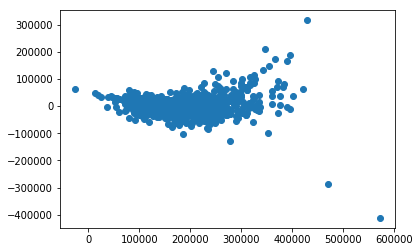

                0
533 -36602.578502


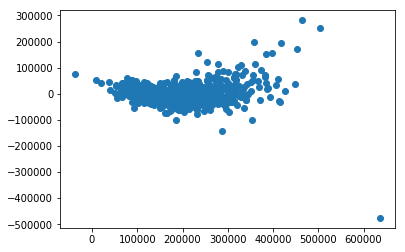

               0
533 -32767.23312


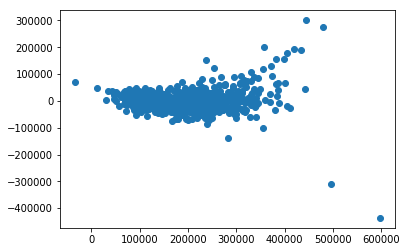

               0
533 -33475.58111


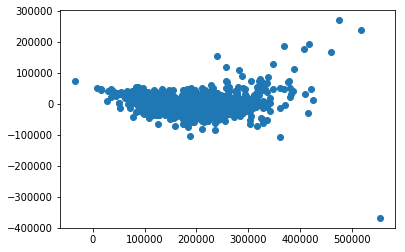

Empty DataFrame
Columns: [0]
Index: []


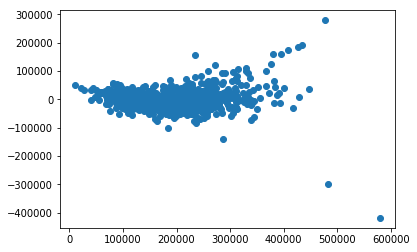

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.791419      13.21     11.583134  1.626866       34480          36455
1  0.814863      13.09     14.924835  1.834835       34555          35562
2  0.801618      13.38     13.364055  0.015945       36080          28367
3  0.833364      12.80     14.715016  1.915016       32029          45624
4  0.805130      13.25     12.779675  0.470325       34379          36359
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000   5.000000      5.000000  5.000000      5.000000   
mean   0.809279  13.146000     13.473343  1.172597  34304.600000   
std    0.015860   0.219386      1.388758  0.869933   1451.671554   
min    0.791419  12.800000     11.583134  0.015945  32029.000000   
25%    0.801618  13.090000     12.779675  0.470325  34379.000000   
50%    0.805130  13.210000     13.364055  1.626866  34480.000000   
75%    0.814863  13.250000     14.715016  1.834835  34555.000000   
max    0.833

In [196]:
test_predictions = run_model_inputs(train_data, train_saleprice, test_data, test_id, 5)

In [197]:
test_predictions.to_csv('//Users//josephcolaco//predicting_house_prices//min_corr_0.35_feat_2.csv', index=False)

# Principle Component Regression

In [180]:
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')
print('Shape of train data:', train_data.shape)
print('Shape of test data:', test_data.shape)

train_saleprice = train_data['SalePrice']
train_data, train_id = feature_eng(train_data, 0.05, 2, True)
test_data, test_id = feature_eng(test_data, 0.05, 2, False)

for i in train_data.columns:
    if i not in test_data.columns:
        train_data = train_data.drop(columns = i)
print('Shape of train data:', train_data.shape)
test_data = test_data[train_data.columns]
print('Shape of test data:', test_data.shape)

Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 108)
Shape of test data: (1459, 108)


For the first trial of pca, the data will not be centered

In [181]:
pca = PCA()
train_pca = pca.fit_transform(train_data)
test_pca = pca.fit_transform(test_data)
# print('These are the pca components:')
# pd.DataFrame(pca.components_.T)

In [183]:
# Selects 1 - length of the fit and transform pca matrix to 
score_lst = []

for i in range(1, train_pca.shape[1], 1):
    print('iter:', i)
    score, test_predictions = run_model_inputs_pca(pd.DataFrame(train_pca[:,:i]), train_saleprice, 
                                                   pd.DataFrame(test_pca[:,:i]), test_id, 5)
    score_lst.append(score.mean())

iter: 1
iter: 2
iter: 3
iter: 4
iter: 5
iter: 6
iter: 7
iter: 8
iter: 9
iter: 10
iter: 11
iter: 12
iter: 13
iter: 14
iter: 15
iter: 16
iter: 17
iter: 18
iter: 19
iter: 20
iter: 21
iter: 22
iter: 23
iter: 24
iter: 25
iter: 26
iter: 27
iter: 28
iter: 29
iter: 30
iter: 31
iter: 32
iter: 33
iter: 34
iter: 35
iter: 36
iter: 37
iter: 38
iter: 39
iter: 40
iter: 41
iter: 42
iter: 43
iter: 44
iter: 45
iter: 46
iter: 47
iter: 48
iter: 49
iter: 50
iter: 51
iter: 52
iter: 53
iter: 54
iter: 55
iter: 56
iter: 57
iter: 58
iter: 59
iter: 60
iter: 61
iter: 62
iter: 63
iter: 64
iter: 65
iter: 66
iter: 67
iter: 68
iter: 69
iter: 70
iter: 71
iter: 72
iter: 73
iter: 74
iter: 75
iter: 76
iter: 77
iter: 78
iter: 79
iter: 80
iter: 81
iter: 82
iter: 83
iter: 84
iter: 85
iter: 86
iter: 87
iter: 88
iter: 89
iter: 90
iter: 91
iter: 92
iter: 93
iter: 94
iter: 95
iter: 96
iter: 97
iter: 98
iter: 99
iter: 100
iter: 101
iter: 102
iter: 103
iter: 104
iter: 105
iter: 106
iter: 107


The following plot displays the training and validation rmse values

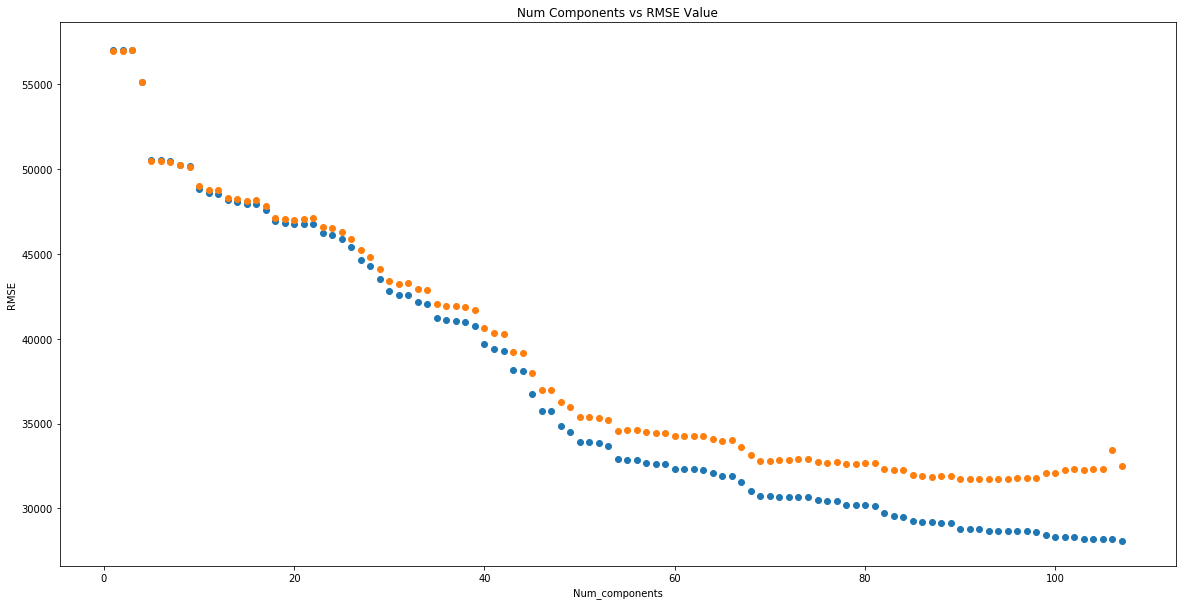

In [184]:
# Plots the train and validation rmse
score_lst_df = pd.DataFrame(score_lst)
plt.figure(figsize=(20,10))
pca_plot = plt.scatter(score_lst_df.index +1 , score_lst_df['train_rmse'])
plt.scatter(score_lst_df.index +1, score_lst_df['validate_rmse'])
plt.xlabel('Num_components')
plt.ylabel('RMSE')
plt.title('Num Components vs RMSE Value')
plt.show()

Following plot shows the difference percent in error based on the number of components:

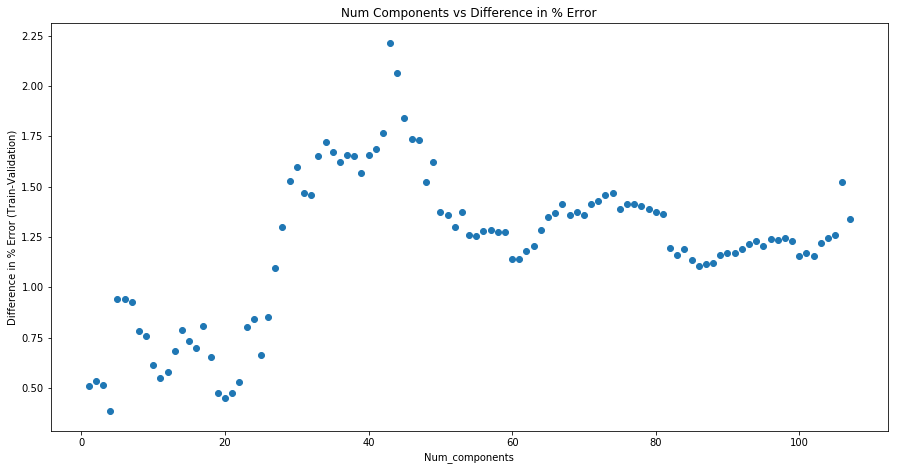

In [185]:
plt.figure(figsize=(15,7.5))
pca_plot = plt.scatter(score_lst_df.index+1 , score_lst_df['diff_err'])
plt.xlabel('Num_components')
plt.ylabel('Difference in % Error (Train-Validation)')
plt.title('Num Components vs Difference in % Error')
plt.show()

Following plot shows the difference percent in error based on the number of components filtered for percent difference error < 2

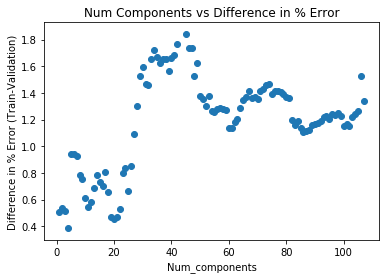

In [186]:
filtered_score_lst_df = score_lst_df[score_lst_df['diff_err'] < 2]
pca_plot = plt.scatter(filtered_score_lst_df.index+1 , filtered_score_lst_df['diff_err'])
plt.xlabel('Num_components')
plt.ylabel('Difference in % Error (Train-Validation)')
plt.title('Num Components vs Difference in % Error')
plt.show()

These are the validation metrics for different number of components

In [187]:
pd.DataFrame(score_lst)

num_components     adjr2  train_err  validate_err  diff_err  train_rmse  \
0               1.0  0.483517     21.898     21.938124  0.507820     57039.0   
1               2.0  0.483135     21.898     21.963021  0.534756     57035.6   
2               3.0  0.482808     21.900     21.977889  0.516522     57029.4   
3               4.0  0.515963     21.386     21.454405  0.385401     55146.6   
4               5.0  0.593024     19.692     19.733909  0.942657     50547.0   
5               6.0  0.593137     19.744     19.778212  0.941145     50518.4   
6               7.0  0.593425     19.802     19.845092  0.926979     50478.8   
7               8.0  0.596748     19.390     19.438181  0.780713     50250.2   
8               9.0  0.597864     19.376     19.428556  0.755969     50158.8   
9              10.0  0.618408     18.392     18.497673  0.612961     48840.0   
10             11.0  0.621612     18.288     18.397614  0.547355     48613.8   
11             12.0  0.622213     18.322     18.430664  0.580485     48554.2   
12             13.0  0.627999     18.328     18.414188  0.684010     48159.6   
13             14.0  0.629079     18.258     18.356689  0.785283     48069.0   
14             15.0  0.630508     18.128     18.239571  0.730578     47955.2   
15             16.0  0.630623     18.096     18.226553  0.700334     47926.6   
16             17.0  0.635219     17.850     18.025352  0.806782     47607.4   
17             18.0  0.645287     17.712     17.915290  0.655077     46925.0   
18             19.0  0.646574     17.606     17.795264  0.472154     46819.2   
19             20.0  0.646820     17.548     17.734904  0.451910     46782.4   
20             21.0  0.646579     17.546     17.742689  0.471849     46778.0   
21             22.0  0.646385     17.540     17.797044  0.530365     46770.2   
22             23.0  0.654460     17.350     17.688179  0.801111     46213.6   
23             24.0  0.655325     17.302     17.681362  0.840473     46136.0   
24             25.0  0.658672     17.204     17.543753  0.664492     45890.8   
25             26.0  0.665478     17.374     17.764192  0.852591     45410.6   
26             27.0  0.676392     17.168     17.555509  1.094199     44644.6   
27             28.0  0.681248     16.982     17.373468  1.298594     44288.0   
28             29.0  0.691893     16.622     17.034400  1.527773     43523.0   
29             30.0  0.701266     16.320     16.748613  1.598649     42836.4   
30             31.0  0.704183     16.294     16.741335  1.469090     42608.2   
31             32.0  0.704196     16.338     16.831095  1.458333     42588.6   
32             33.0  0.709803     16.338     16.823587  1.652128     42165.4   
33             34.0  0.711220     16.240     16.735523  1.724132     42043.8   
34             35.0  0.721949     16.142     16.623916  1.670389     41236.4   
35             36.0  0.723718     16.020     16.541520  1.624107     41086.4   
36             37.0  0.723984     16.014     16.565640  1.655089     41048.8   
37             38.0  0.724862     15.916     16.426409  1.654634     40965.4   
38             39.0  0.727227     15.858     16.388608  1.565378     40771.2   
39             40.0  0.741497     15.596     16.172011  1.659761     39670.8   
40             41.0  0.744901     15.430     15.969287  1.686598     39390.6   
41             42.0  0.745874     15.414     15.983017  1.768753     39297.8   
42             43.0  0.760153     15.424     16.038187  2.212979     38162.0   
43             44.0  0.760721     15.342     15.949430  2.063738     38100.0   
44             45.0  0.776980     14.918     15.578921  1.841222     36767.2   
45             46.0  0.789129     14.356     14.991602  1.739157     35735.0   
46             47.0  0.789097     14.334     14.966450  1.734043     35721.8   
47             48.0  0.798937     13.856     14.512270  1.524632     34863.6   
48             49.0  0.802877     13.706     14.345556  1.623170     34504.8   
49   

Following displays the variance explained in the model

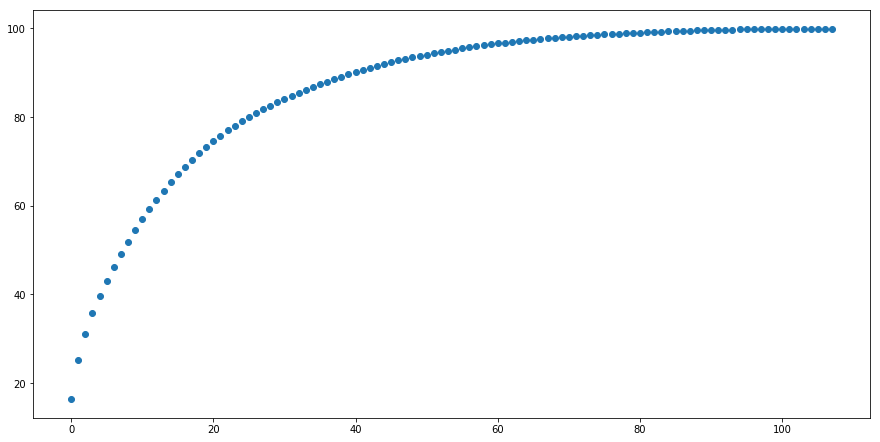

In [188]:
# Following displays the variance explained in the model
a = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
a = pd.DataFrame(a, columns=['var_explained'])
plt.figure(figsize=(15,7.5))
var_explained_plot = plt.scatter(a.index , a['var_explained'])
plt.show()

this graphs shows difference in variance explained (like an elbow method graph)

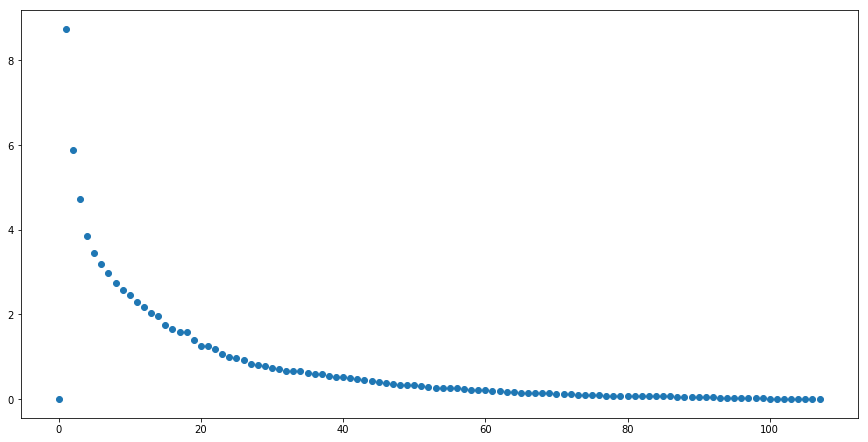

In [189]:
# Following displays the variance explained in the model
a = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
a = pd.DataFrame(a, columns=['var_explained'])

for index, row in a.iterrows():
    if index == 0:
        continue
    a.loc[index, 'diff_var_explained'] = a.loc[index, 'var_explained'] - a.loc[index-1, 'var_explained']

a['diff_var_explained'] = a['diff_var_explained'].fillna(0)
plt.figure(figsize=(15,7.5))
var_explained_plot = plt.scatter(a.index , a['diff_var_explained'])
plt.show()

# Partial Least Squares Regression

In [253]:
def run_model_inputs_pls(train_data, train_saleprice, k, pls_component_no):
    kf = KFold(n_splits=k, shuffle=True, random_state=round(random.uniform(1, 40000)))
    # kf = KFold(n_splits=10, shuffle=True, random_state=6104)
    kf.get_n_splits(train_data)
    print(kf)
    scores = []
    for train_index, test_index in kf.split(train_data):
        train_X, validate_X = train_data.loc[train_index,:], train_data.loc[test_index,:]
        train_y, validate_y = train_saleprice.loc[train_index], train_saleprice.loc[test_index]
        
        pls2 = PLSRegression(copy=True, max_iter=500, n_components=pls_component_no, scale=False, tol=1e-06)
        pls2.fit(sm.add_constant(train_X, has_constant='add'), train_y)
        r2 = pls2.score(sm.add_constant(train_X, has_constant='add'), train_y)
#         print(r2)
        
        train_predictions = pd.DataFrame(
            pls2.predict(sm.add_constant(train_X, has_constant='add')))
        train_predictions.columns = ['PredSalePrice']
        
        train_y = pd.DataFrame(train_y).reset_index(drop=True)
        train_predictions['SalePrice'] = train_y['SalePrice']
        train_predictions['err'] = train_predictions['PredSalePrice'] - train_y['SalePrice']
        train_predictions['percent_err'] = (abs(train_predictions['err'])/train_predictions['SalePrice'])
#         print(train_predictions)
        
#         # calculations to get percent error
        avg_train_err = round((abs(train_predictions['err'])/train_predictions['SalePrice']).mean()*100,2)
#         print('Train % error:', avg_train_err)

        validate_predictions = pd.DataFrame(
            pls2.predict(sm.add_constant(validate_X, has_constant='add')))
        
        validate_predictions.columns = ['PredSalePrice']
        validate_y = pd.DataFrame(validate_y).reset_index(drop=True)
        validate_predictions['SalePrice'] = validate_y['SalePrice']
        validate_predictions['err'] = validate_predictions['PredSalePrice'] - validate_y['SalePrice']
        validate_predictions['percent_err'] = (abs(validate_predictions['err'])/validate_predictions['SalePrice'])
#         print(validate_predictions)
        # calculations to get percent error
        avg_validate_err = round((abs(validate_predictions['err'])/validate_predictions['SalePrice']).mean()*100,2)
#         print('Validate % error:', avg_validate_err)
        
        scores.append([r2, avg_train_err, avg_validate_err, abs(avg_train_err-avg_validate_err),
                       round(sqrt(mean_squared_error(train_predictions['SalePrice'], train_predictions['PredSalePrice']))), 
                       round(sqrt(mean_squared_error(validate_predictions['SalePrice'], validate_predictions['PredSalePrice'])))])

#         # fitted values
#         model_fitted = pd.DataFrame(model.fittedvalues)

#         # model residuals
#         model_residuals = pd.DataFrame(model.resid)

#         # Residual plot
#         residual_plot = plt.scatter(model_fitted , model_residuals)
#         plt.show()

    scores = pd.DataFrame(scores, columns = ['r2', 'train_err', 'validate_err', 'diff_err', 
                                             'train_rmse', 'validate_rmse'])
#     print(scores)
#     print(scores.describe())
    

#     test_predictions = model.predict(sm.add_constant(test_data))
#     test_predictions = pd.DataFrame(test_predictions)
#     test_predictions.columns = ['SalePrice']
#     test_predictions = pd.concat([test_id, test_predictions], axis=1)
    
#     return test_predictions
    return scores

In [254]:
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')
print('Shape of train data:', train_data.shape)
print('Shape of test data:', test_data.shape)

train_saleprice = train_data['SalePrice']
train_data, train_id = feature_eng(train_data, 0.05, 2, True)
test_data, test_id = feature_eng(test_data, 0.05, 2, False)

for i in train_data.columns:
    if i not in test_data.columns:
        train_data = train_data.drop(columns = i)
print('Shape of train data:', train_data.shape)
test_data = test_data[train_data.columns]
print('Shape of test data:', test_data.shape)

Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 108)
Shape of test data: (1459, 108)


In [255]:
scores = run_model_inputs_pls(train_data, train_saleprice, 5, 40)
scores.mean()

KFold(n_splits=5, random_state=36631, shuffle=True)


r2                   0.875462
train_err           10.254000
validate_err        11.810000
diff_err             1.556000
train_rmse       27995.000000
validate_rmse    33382.800000
dtype: float64

In [258]:
# Selects 1 - length of the fit and transform pca matrix to 
score_lst = []

for i in range(1, train_data.shape[1], 1):
    print('iter:', i)
    score = run_model_inputs_pls(train_data, train_saleprice, 5, i)
    score_lst.append(score.mean())
    
score_lst_df = pd.DataFrame(score_lst)

iter: 1
KFold(n_splits=5, random_state=33439, shuffle=True)
iter: 2
KFold(n_splits=5, random_state=2111, shuffle=True)
iter: 3
KFold(n_splits=5, random_state=18068, shuffle=True)
iter: 4
KFold(n_splits=5, random_state=34583, shuffle=True)
iter: 5
KFold(n_splits=5, random_state=24440, shuffle=True)
iter: 6
KFold(n_splits=5, random_state=30476, shuffle=True)
iter: 7
KFold(n_splits=5, random_state=31666, shuffle=True)
iter: 8
KFold(n_splits=5, random_state=18661, shuffle=True)
iter: 9
KFold(n_splits=5, random_state=11907, shuffle=True)
iter: 10
KFold(n_splits=5, random_state=33229, shuffle=True)
iter: 11
KFold(n_splits=5, random_state=6961, shuffle=True)
iter: 12
KFold(n_splits=5, random_state=28197, shuffle=True)
iter: 13
KFold(n_splits=5, random_state=8961, shuffle=True)
iter: 14
KFold(n_splits=5, random_state=407, shuffle=True)
iter: 15
KFold(n_splits=5, random_state=38576, shuffle=True)
iter: 16
KFold(n_splits=5, random_state=26866, shuffle=True)
iter: 17
KFold(n_splits=5, random_stat

/anaconda3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:313: UserWarning: X scores are null at iteration 106
  warnings.warn('X scores are null at iteration %s' % k)


In [259]:
score_lst_df

r2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0    0.567894     19.688        19.748     0.744     52193.2        52244.8
1    0.711530     16.258        16.686     1.012     42643.0        43333.4
2    0.791174     14.104        14.512     0.640     36274.6        37665.0
3    0.814958     13.378        14.182     0.912     34152.6        35995.8
4    0.837790     12.548        13.232     1.376     31961.8        34001.2
5    0.846550     12.126        12.844     0.850     31080.2        32873.8
6    0.854455     11.602        12.546     0.956     30288.8        32417.0
7    0.857860     11.432        12.176     0.908     29930.8        32056.2
8    0.861562     11.210        12.172     1.074     29515.0        32334.6
9    0.865022     11.046        12.062     1.080     29156.6        32180.8
10   0.867324     10.796        11.964     1.200     28889.0        32084.4
11   0.868612     10.730        11.748     1.018     28758.0        31974.6
12   0.870314     10.660        11.906     1.362     28562.6        32304.8
13   0.870388     10.610        11.872     1.262     28557.8        31936.6
14   0.871119     10.562        11.770     1.208     28476.8        32001.4
15   0.871889     10.520        11.716     1.196     28397.8        32077.0
16   0.872492     10.496        11.674     1.178     28341.2        32324.4
17   0.873744     10.518        11.740     1.222     28152.0        32575.8
18   0.873580     10.444        11.584     1.148     28222.6        31757.2
19   0.873143     10.382        11.552     1.170     28262.2        32585.2
20   0.874519     10.416        11.676     1.260     28095.4        32479.2
21   0.873580     10.386        11.548     1.162     28194.0        32522.0
22   0.873739     10.324        11.608     1.284     28202.4        31699.4
23   0.874317     10.306        11.660     1.374     28116.4        33093.4
24   0.874891     10.366        11.574     1.208     28029.4        32742.4
25   0.874314     10.302        11.514     1.212     28133.0        32693.2
26   0.874201     10.236        11.666     1.430     28149.6        32520.8
27   0.874809     10.234        11.832     1.598     28081.2        33245.2
28   0.873883     10.252        11.500     1.408     28154.8        32112.0
29   0.875047     10.308        11.564     1.256     28010.0        32433.2
30   0.875546     10.312        11.568     1.256     27945.6        33390.8
31   0.875612     10.302        11.668     1.366     27898.2        33279.6
32   0.874572     10.200        11.898     1.698     28071.8        33326.0
33   0.875510     10.308        11.686     1.378     27928.6        33733.6
34   0.875351     10.272        11.710     1.438     27915.2        32978.6
35   0.874771     10.252        11.726     1.474     28074.2        32703.0
36   0.874630     10.248        11.730     1.482     28096.2        32832.6
37   0.874515     10.244        11.588     1.344     28112.2        32072.0
38   0.874477     10.248        11.608     1.396     28109.8        31685.8
39   0.875232     10.290        11.736     1.446     28026.8        33183.8
40   0.876149     10.352        11.882     1.530     27858.0        34012.2
41   0.875356     10.280        11.848     1.568     28017.6        32336.0
42   0.876367     10.372        11.870     1.498     27854.0        33067.4
43   0.875328     10.326        11.790     1.464     28018.6        33291.0
44   0.874581     10.310        11.836     1.650     28076.2        32227.4
45   0.875310     10.304        11.856     1.552     28010.4        32834.0
46   0.875437     10.308        11.860     1.552     28020.4        32598.0
47   0.875818     10.306        11.992     1.686     27960.0        33429.2
48   0.875172     10.318        11.678     1.360     28046.6        32812.8
49   0.875020     10.266        11.902     1.636     28055.6        32473.2
50   0.875041     10.286        11.812     1.526     28030.8        33024.4
51   0.874645     10.338        11.616     1.278     28105.

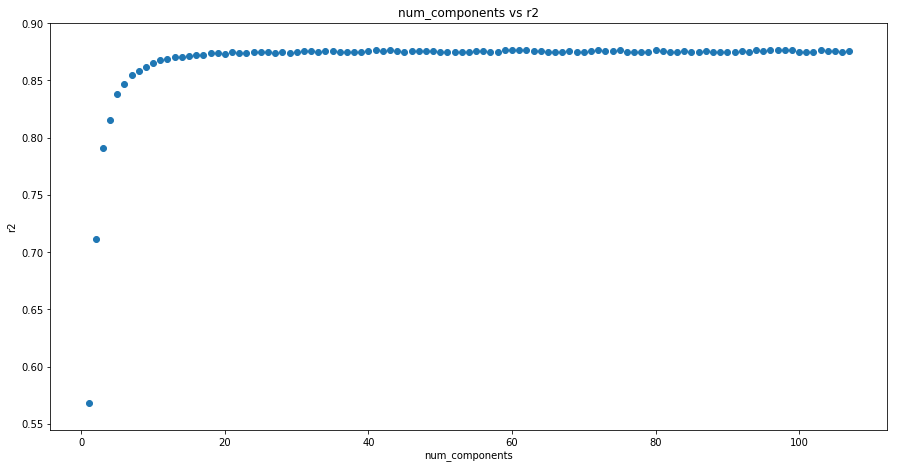

In [263]:
plt.figure(figsize=(15,7.5))
var_explained_plot = plt.scatter(score_lst_df.index+1 , score_lst_df['r2'])
plt.xlabel('num_components')
plt.ylabel('r2')
plt.title('num_components vs r2')
plt.show()

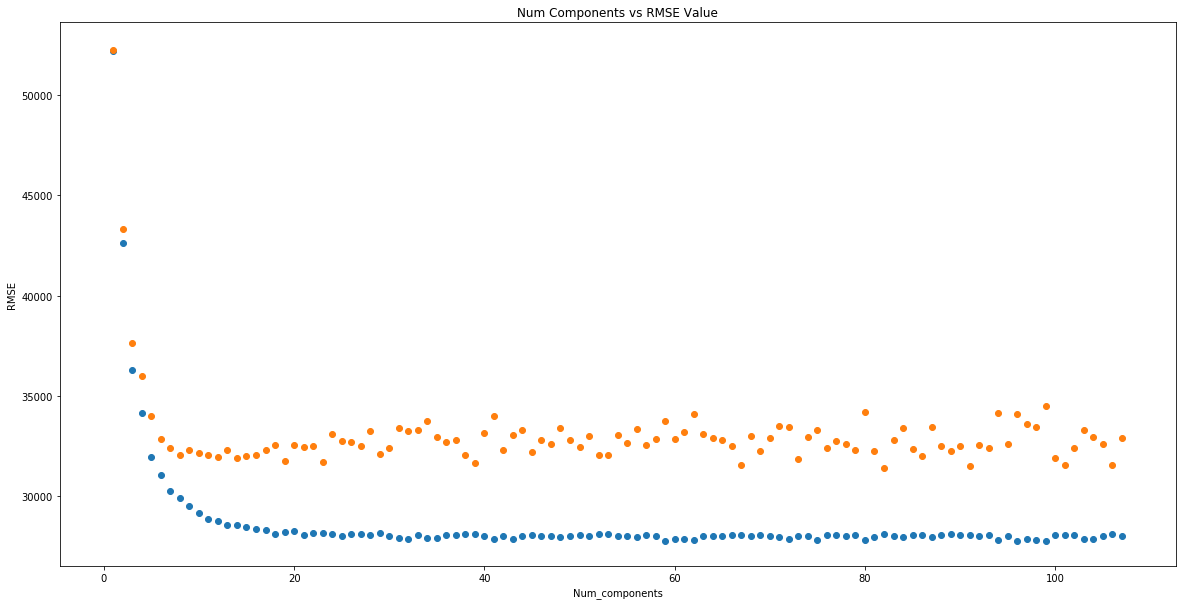

In [264]:
# Plots the train and validation rmse
score_lst_df = pd.DataFrame(score_lst)
plt.figure(figsize=(20,10))
pca_plot = plt.scatter(score_lst_df.index +1 , score_lst_df['train_rmse'])
plt.scatter(score_lst_df.index +1, score_lst_df['validate_rmse'])
plt.xlabel('Num_components')
plt.ylabel('RMSE')
plt.title('Num Components vs RMSE Value')
plt.show()

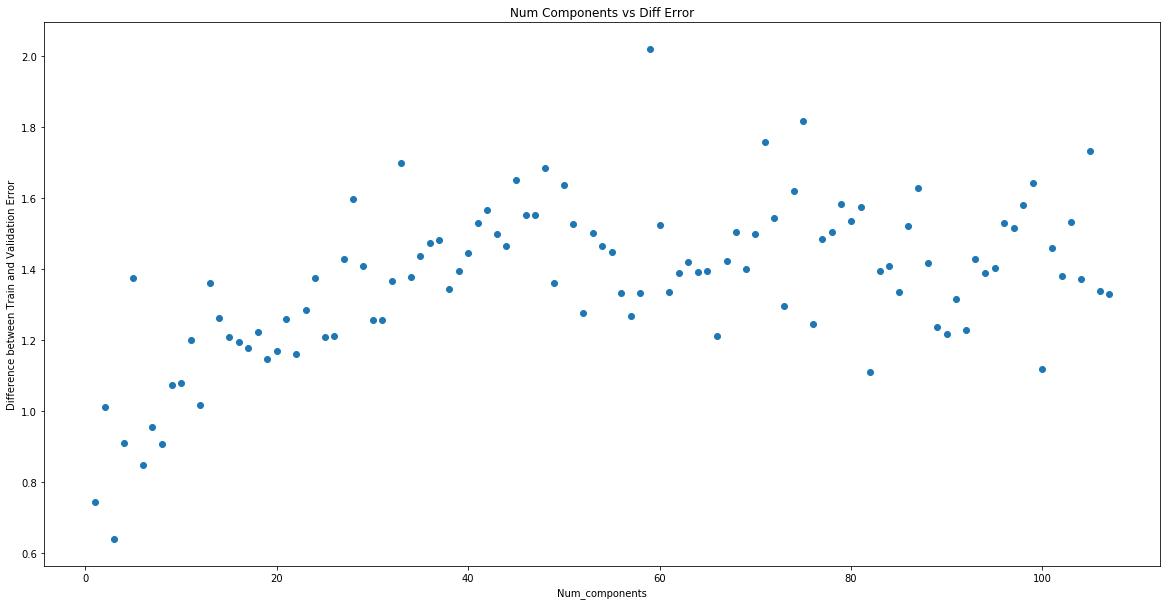

In [267]:
# Plots the diff err
score_lst_df = pd.DataFrame(score_lst)
plt.figure(figsize=(20,10))
pca_plot = plt.scatter(score_lst_df.index +1 , score_lst_df['diff_err'])
plt.xlabel('Num_components')
plt.ylabel('Difference between Train and Validation Error')
plt.title('Num Components vs Diff Error')
plt.show()

In [260]:
# Rank of the training data matrix to check if it has linearly dependent columns
np.linalg.matrix_rank(train_data)

107

# Random Forrest

In [4]:
# def feature_eng(model_data, max_predictor_corr_delete, max_predictor_corr_dim_red, min_response_corr):
def feature_eng_rf(model_data, min_corr_saleprice, corr_features_thres, is_train):

    id_col = model_data['Id']
    
    model_data['GarageYrBlt'] = model_data['GarageYrBlt'].fillna(0)
    model_data['GarageCars'] = model_data['GarageCars'].fillna(0)
    model_data['LotFrontage'] = model_data['LotFrontage'].fillna(0)
    model_data['MasVnrArea'] = model_data['MasVnrArea'].fillna(0)

    # Replace any null values in categorical variables with 'Not Available'
    for i in model_data.columns:
        if model_data[i].dtypes == 'object':
            model_data[i] = model_data[i].fillna('Not_Available')
            
    model_data['NumBath'] = (model_data['FullBath'].fillna(0) + model_data['HalfBath'].fillna(0)/2 + 
                       model_data['BsmtHalfBath'].fillna(0)/2 + model_data['BsmtFullBath'].fillna(0))
    
    
    model_data['LivingSF'] = (model_data['1stFlrSF'].fillna(0) + model_data['2ndFlrSF'].fillna(0) 
                               + model_data['TotalBsmtSF'].fillna(0))

    
    model_data['TotalLotArea'] = model_data['LotArea'] + model_data['LotFrontage']

    
    
    # combine total SF features outside
    model_data['NonLivingSF'] = (model_data['EnclosedPorch'].fillna(0) + model_data['PoolArea'].fillna(0) + 
                                 model_data['GarageArea'].fillna(0) + model_data['ScreenPorch'].fillna(0) + 
                                 model_data['OpenPorchSF'].fillna(0) +  model_data['WoodDeckSF'].fillna(0))
    
    model_data['MSSubClassCat'] = model_data['MSSubClass'].astype('category')
    
    
    # Add int variables for ExterQual and ExterCond
    model_data['ExterQualInt'] =  np.where(model_data['ExterQual'] == "Ex", 9, 
                                            np.where(model_data['ExterQual'] == "Gd", 7, 
                                                    np.where(model_data['ExterQual'] == "TA", 5, 
                                                            np.where(model_data['ExterQual'] == "Fa", 3, 
                                                                    np.where(model_data['ExterQual'] == "Po", 2,0)))))

    # Add int variables for all categorical basement variables
    model_data['BsmtQualInt'] =  np.where(model_data['BsmtQual'] == "Ex", 9, 
                                            np.where(model_data['BsmtQual'] == "Gd", 7, 
                                                    np.where(model_data['BsmtQual'] == "TA", 5, 
                                                            np.where(model_data['BsmtQual'] == "Fa", 3, 
                                                                    np.where(model_data['BsmtQual'] == "Po", 2,0)))))


    model_data['GarageQualInt'] =  np.where(model_data['GarageQual'] == "Ex", 9, 
                                            np.where(model_data['GarageQual'] == "Gd", 7, 
                                                    np.where(model_data['GarageQual'] == "TA", 5, 
                                                            np.where(model_data['GarageQual'] == "Fa", 3, 
                                                                    np.where(model_data['GarageQual'] == "Po", 2,0)))))
    # Add interaction variables for KitchenQual
    model_data['KitchenQualInt'] =  np.where(model_data['KitchenQual'] == "Ex", 9, 
                                            np.where(model_data['KitchenQual'] == "Gd", 7, 
                                                    np.where(model_data['KitchenQual'] == "TA", 5, 
                                                            np.where(model_data['KitchenQual'] == "Fa", 3, 
                                                                    np.where(model_data['KitchenQual'] == "Po", 2,0)))))

    model_data = model_data.drop(columns=['EnclosedPorch', 'PoolArea', 'GarageArea', 'ScreenPorch', 
                                          'OpenPorchSF', 'WoodDeckSF', 'MSSubClass', 'KitchenAbvGr', 
                                          'OverallCond', 'BsmtFinType1', 'BsmtFinType2', 'Exterior2nd', 
                                          'Condition2', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'BsmtUnfSF',
                                          'BsmtFinSF1', 'LotArea', 'LotFrontage', 'YrSold', 'LowQualFinSF', 
                                          'MiscVal', 'BsmtFinSF2', '3SsnPorch', 'MoSold', 'Id', 'FullBath', 
                                          'HalfBath', 'BsmtHalfBath', 'BsmtFullBath', 'PoolQC', 'MiscFeature', 
                                          'Alley', 'Fence', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
                                          'BsmtExposure', 'GarageCond', 'GarageQual', 'KitchenQual'])
    
    model_data = pd.get_dummies(model_data, drop_first=True)

    # Delete any Not_Available columns (no use in the model)
    model_data = model_data[model_data.columns.drop(list(model_data.filter(regex='Not_Available')))]
#     print(model_data.isnull().sum())
    if is_train:
        # Delete any variables that have less than a threshold of correlation with SalePrice
        saleprice_corr = model_data[model_data.columns].corr()['SalePrice']
        saleprice_corr = pd.DataFrame(saleprice_corr)
        saleprice_corr.sort_values(by='SalePrice', ascending = False)
        saleprice_corr = saleprice_corr.reset_index()
        saleprice_corr.columns = ['Feature', 'SalePrice']
        features_to_delete = saleprice_corr[
            (saleprice_corr['SalePrice'] < min_corr_saleprice) & (saleprice_corr['SalePrice'] > -min_corr_saleprice)]
        features_to_delete = features_to_delete['Feature'].unique()
        model_data = model_data.drop(columns = features_to_delete)
        saleprice_corr = saleprice_corr.set_index('Feature')

        # The following shows correlations of features with each other
        correlation_mat = model_data.corr()
        corr_df = []
        for i in range(0, correlation_mat.shape[0], 1):
            for j in range(i+1, correlation_mat.shape[1],1):
                if abs(correlation_mat.iloc[i,j]) >= corr_features_thres:
                    corr_df.append([correlation_mat.columns[i], correlation_mat.columns[j], correlation_mat.iloc[i,j]])
        corr_df = pd.DataFrame(corr_df, columns=['col1', 'col2', 'correlation'])
        corr_df = corr_df.sort_values(by='correlation', ascending=False)
#         print(corr_df)
        
        # Deletes one of two highly correlated features if it is greater than the threshold. Deletes feature that has
        # lower correlation with SalePrice
        for index, row in corr_df.iterrows():
            if (str(row['col1']) == 'SalePrice') or (str(row['col2']) == 'SalePrice'):
                continue
            else:
                if abs(saleprice_corr.loc[row['col1'], 'SalePrice']) >= abs(saleprice_corr.loc[row['col2'], 'SalePrice']) :
                    if row['col2'] in model_data.columns:
                        model_data = model_data.drop(columns = [row['col2']])
                else:
                    if row['col1'] in model_data.columns:
                        model_data = model_data.drop(columns = [row['col1']])
        
        model_data = model_data.drop(columns = ['SalePrice'])
    
    
#     model_data_col = model_data.columns
#     model_data = MinMaxScaler().fit_transform(model_data)
#     model_data = scale(model_data)
#     model_data = pd.DataFrame(model_data, columns=model_data_col)
        
    return model_data, id_col
    

In [140]:
def run_model_inputs_rf(train_data, train_saleprice, k, estimators, depth, features, samples_leaf, impurity_decrease):
    kf = KFold(n_splits=k, shuffle=True, random_state=round(random.uniform(1, 40000)))
    kf.get_n_splits(train_data)
    forest = RandomForestRegressor(
        n_estimators=estimators, max_depth=depth, max_features=features, min_samples_leaf=samples_leaf, 
        min_impurity_decrease=impurity_decrease)
    scores = []
    for train_index, test_index in kf.split(train_data):
        train_X, validate_X = train_data.loc[train_index,:], train_data.loc[test_index,:]
        train_y, validate_y = train_saleprice.loc[train_index], train_saleprice.loc[test_index]
        forest.fit(train_X,train_y)
        
        # For training data
        train_predictions = forest.predict(train_X)
        train_predictions = pd.DataFrame(train_predictions)
        train_predictions.columns = ['PredSalePrice']
        train_y_df = pd.DataFrame(train_y)
        train_y_df = train_y_df.reset_index(drop=True)
        train_predictions['SalePrice'] = train_y_df['SalePrice']
        train_predictions['PredErr'] = (abs(
            train_predictions['PredSalePrice'] - train_predictions['SalePrice'])/train_predictions['SalePrice'])
        avg_train_err = train_predictions['PredErr'].mean()
        
        # For validation data
        validate_predictions = forest.predict(validate_X)
        validate_predictions = pd.DataFrame(validate_predictions)
        validate_predictions.columns = ['PredSalePrice']
        validate_y_df = pd.DataFrame(validate_y)
        validate_y_df = validate_y_df.reset_index(drop=True)
        validate_predictions['SalePrice'] = validate_y_df['SalePrice']
        validate_predictions['PredErr'] = (abs(
            validate_predictions['PredSalePrice'] - validate_predictions['SalePrice'])/validate_predictions['SalePrice'])
        avg_validate_err = validate_predictions['PredErr'].mean()
        
        # append scores list
        scores.append([estimators, depth, features, samples_leaf, impurity_decrease,
                     forest.score(train_X, train_y), avg_train_err, avg_validate_err, 
                     abs(avg_train_err-avg_validate_err), 
                     round(sqrt(mean_squared_error(train_predictions['SalePrice'], train_predictions['PredSalePrice']))), 
                     round(sqrt(mean_squared_error(validate_predictions['SalePrice'], validate_predictions['PredSalePrice'])))])
        
    scores = pd.DataFrame(scores, columns = ['n_estimators', 'max_depth', 'max_features', 'min_samples_leaf', 'min_impurity_decrease','r2', 
                                                 'train_err', 'validate_err', 'diff_err', 'train_rmse', 'validate_rmse'])
    
    return scores.mean()

In [141]:
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')
print('Shape of train data:', train_data.shape)
print('Shape of test data:', test_data.shape)

train_saleprice = train_data['SalePrice']
train_data, train_id = feature_eng_rf(train_data, 0, 2, True)
test_data, test_id = feature_eng_rf(test_data, 0, 2, False)

for i in train_data.columns:
    if i not in test_data.columns:
        train_data = train_data.drop(columns = i)
print('Shape of train data:', train_data.shape)
test_data = test_data[train_data.columns]
print('Shape of test data:', test_data.shape)

Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 162)
Shape of test data: (1459, 162)


No handles with labels found to put in legend.


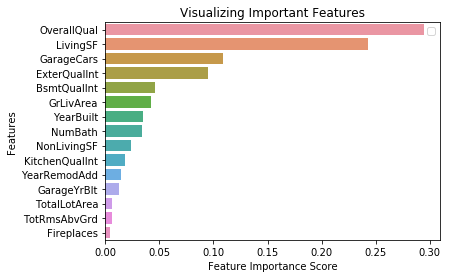

In [143]:
# Create a classifier
forest = RandomForestRegressor(n_estimators=100, max_depth=20, max_features=50, min_samples_leaf=50)
train_X, validate_X, train_y, validate_y = train_test_split(train_data, train_saleprice, test_size=0.2)
forest.fit(train_X,train_y)
feature_imp = pd.Series(forest.feature_importances_, index = train_data.columns).sort_values(ascending=False)
feature_imp
feature_imp_head = feature_imp.head(15)

sns.barplot(x=feature_imp_head, y=feature_imp_head.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [144]:
train_predictions = forest.predict(train_X)
train_predictions = pd.DataFrame(train_predictions)
train_predictions.columns = ['PredSalePrice']
train_y_df = pd.DataFrame(train_y)
train_y_df = train_y_df.reset_index(drop=True)
train_predictions['SalePrice'] = train_y_df['SalePrice']
train_predictions['PredErr'] = (abs(
    train_predictions['PredSalePrice'] - train_predictions['SalePrice'])/train_predictions['SalePrice'])
avg_train_err = train_predictions['PredErr'].mean()
avg_train_err

0.1273333977874515

In [145]:
forest.score(train_X, train_y)

0.7886522238170446

In [146]:
validate_predictions = forest.predict(validate_X)
validate_predictions = pd.DataFrame(validate_predictions)
validate_predictions.columns = ['PredSalePrice']
validate_y_df = pd.DataFrame(validate_y)
validate_y_df = validate_y_df.reset_index(drop=True)
validate_predictions['SalePrice'] = validate_y_df['SalePrice']
validate_predictions['PredErr'] = (abs(
    validate_predictions['PredSalePrice'] - validate_predictions['SalePrice'])/validate_predictions['SalePrice'])
avg_validate_err = validate_predictions['PredErr'].mean()
avg_validate_err

0.12160720922236591

In [147]:
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')
print('Shape of train data:', train_data.shape)
print('Shape of test data:', test_data.shape)

train_saleprice = train_data['SalePrice']
train_data, train_id = feature_eng_rf(train_data, 0, 2, True)
test_data, test_id = feature_eng_rf(test_data, 0, 2, False)

for i in train_data.columns:
    if i not in test_data.columns:
        train_data = train_data.drop(columns = i)
print('Shape of train data:', train_data.shape)
test_data = test_data[train_data.columns]
print('Shape of test data:', test_data.shape)

Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 162)
Shape of test data: (1459, 162)


In [149]:
n_est = [10,20,30,40,50,75,100,150,200,300,400,500,600,700,800,900,1000]
score_lst = []
for i in n_est:
    scores = run_model_inputs_rf(
        train_data, train_saleprice, 2, estimators=i, depth=1000000, features=train_data.shape[1], samples_leaf=1, 
        impurity_decrease = 0)
    score_lst.append(scores)

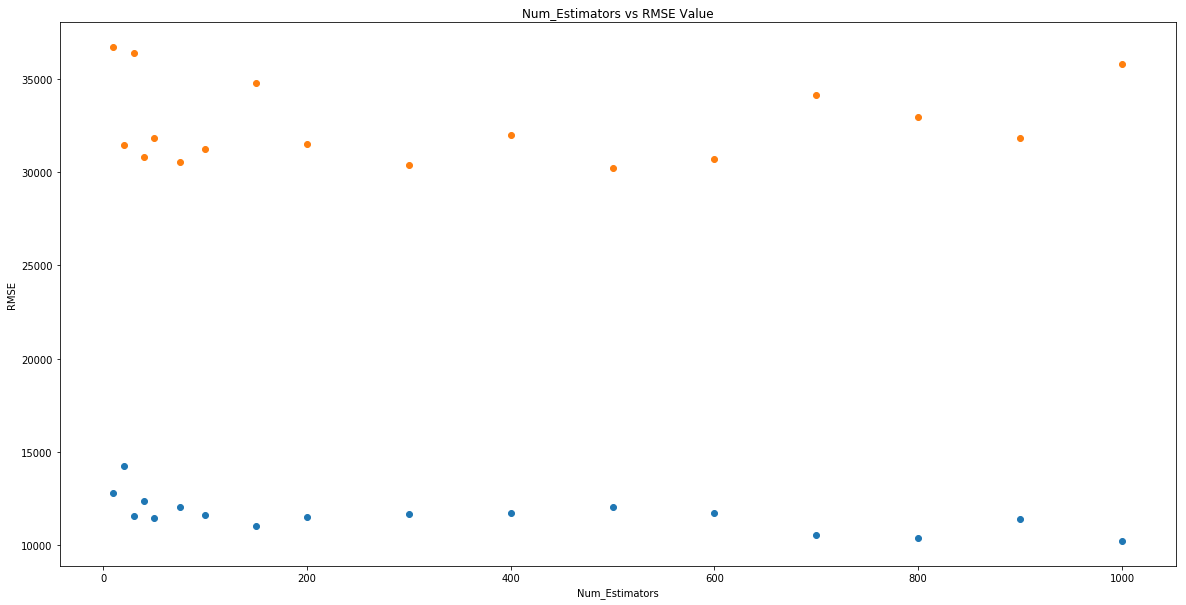

In [150]:
# Plots the train and validation rmse
score_lst_df = pd.DataFrame(score_lst)
plt.figure(figsize=(20,10))
n_est_plot = plt.scatter(score_lst_df['n_estimators'] , score_lst_df['train_rmse'])
plt.scatter(score_lst_df['n_estimators'], score_lst_df['validate_rmse'])
plt.xlabel('Num_Estimators')
plt.ylabel('RMSE')
plt.title('Num_Estimators vs RMSE Value')
plt.show()

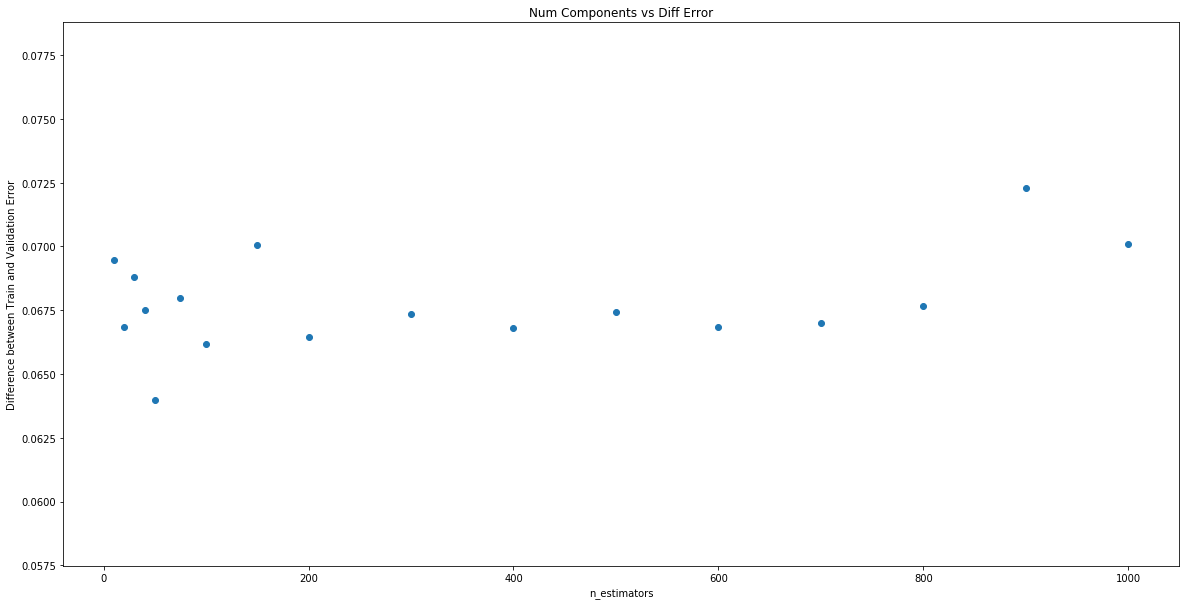

In [152]:
# Plots the diff err
plt.figure(figsize=(20,10))
pca_plot = plt.scatter(score_lst_df['n_estimators'] , score_lst_df['diff_err'])
plt.xlabel('n_estimators')
plt.ylabel('Difference between Train and Validation Error')
plt.title('Num Components vs Diff Error')
plt.show()

In [153]:
max_depth = [10,20,30,40,50,75,100,150,200,300,400,500,600,700,800,900,1000]
score_lst_max_depth = []
for i in max_depth:
    scores = run_model_inputs_rf(
        train_data, train_saleprice, 2, estimators=40, depth=i,
        features=train_data.shape[1], samples_leaf=1, impurity_decrease = 0)
    score_lst_max_depth.append(scores)

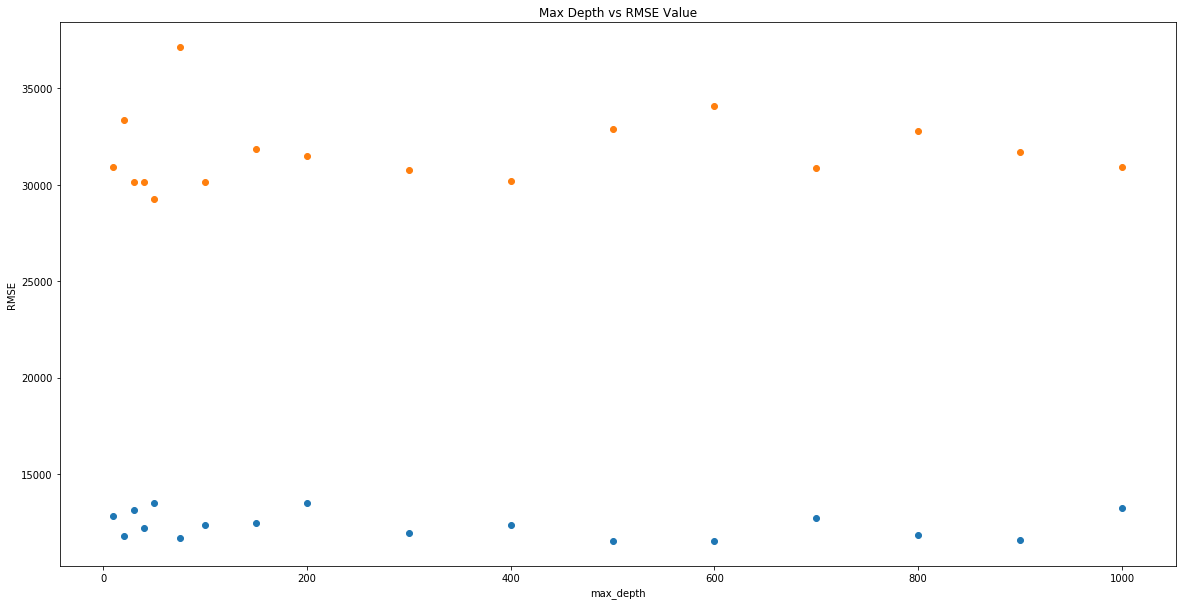

In [154]:
# Plots the train and validation rmse fro max_depth
score_lst_max_depth_df = pd.DataFrame(score_lst_max_depth)
plt.figure(figsize=(20,10))
n_est_plot = plt.scatter(score_lst_max_depth_df['max_depth'] , score_lst_max_depth_df['train_rmse'])
plt.scatter(score_lst_max_depth_df['max_depth'], score_lst_max_depth_df['validate_rmse'])
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.title('Max Depth vs RMSE Value')
plt.show()

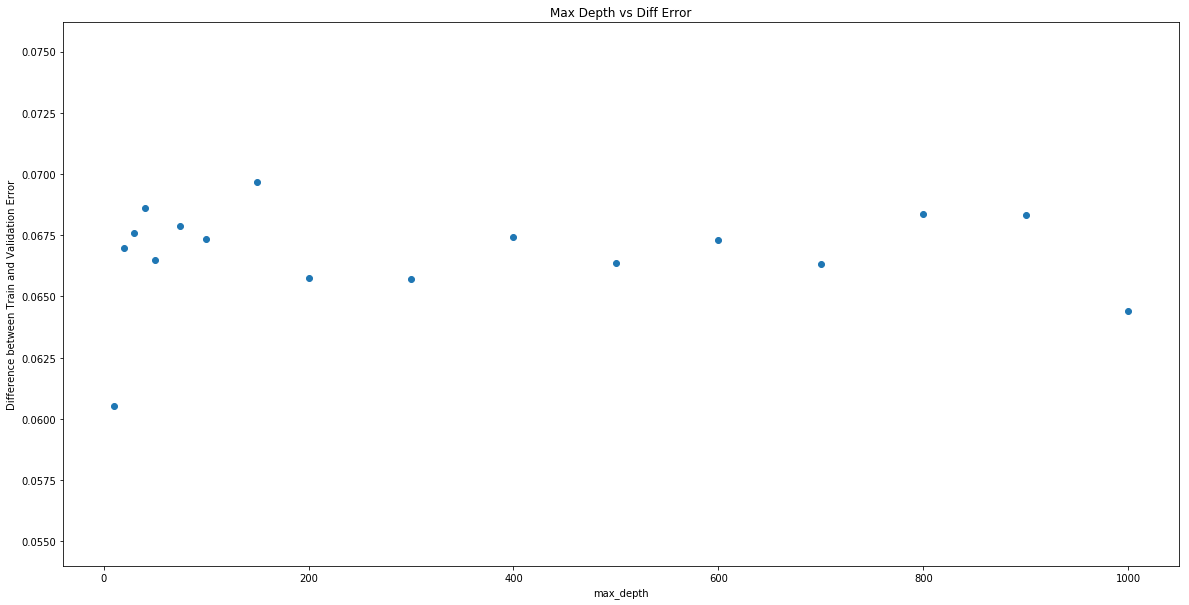

In [155]:
# Plots the diff err for max_depth
plt.figure(figsize=(20,10))
pca_plot = plt.scatter(score_lst_max_depth_df['max_depth'] , score_lst_max_depth_df['diff_err'])
plt.xlabel('max_depth')
plt.ylabel('Difference between Train and Validation Error')
plt.title('Max Depth vs Diff Error')
plt.show()

In [156]:
max_features = range(1,train_data.shape[1],1)
score_lst_features = []
for i in max_features:
    scores = run_model_inputs_rf(
        train_data, train_saleprice, 5, estimators=40, depth=50,
        features=i, samples_leaf=1, impurity_decrease = 0)
    score_lst_features.append(scores)

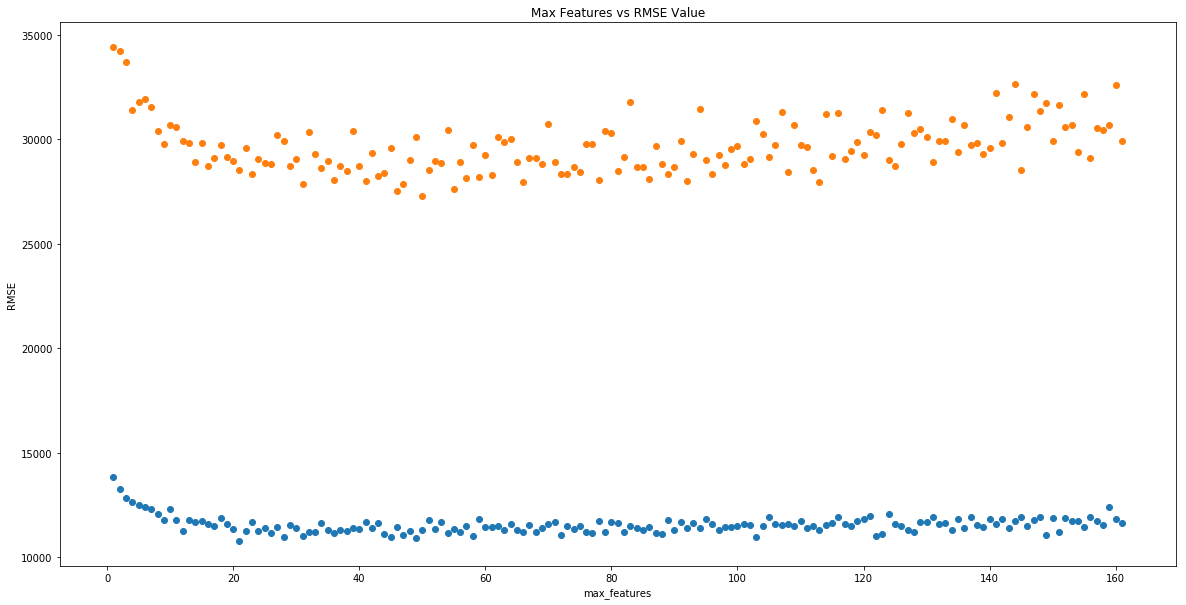

In [157]:
# Plots the train and validation rmse fro max_features
score_lst_features_df = pd.DataFrame(score_lst_features)
plt.figure(figsize=(20,10))
n_est_plot = plt.scatter(score_lst_features_df['max_features'] , score_lst_features_df['train_rmse'])
plt.scatter(score_lst_features_df['max_features'], score_lst_features_df['validate_rmse'])
plt.xlabel('max_features')
plt.ylabel('RMSE')
plt.title('Max Features vs RMSE Value')
plt.show()

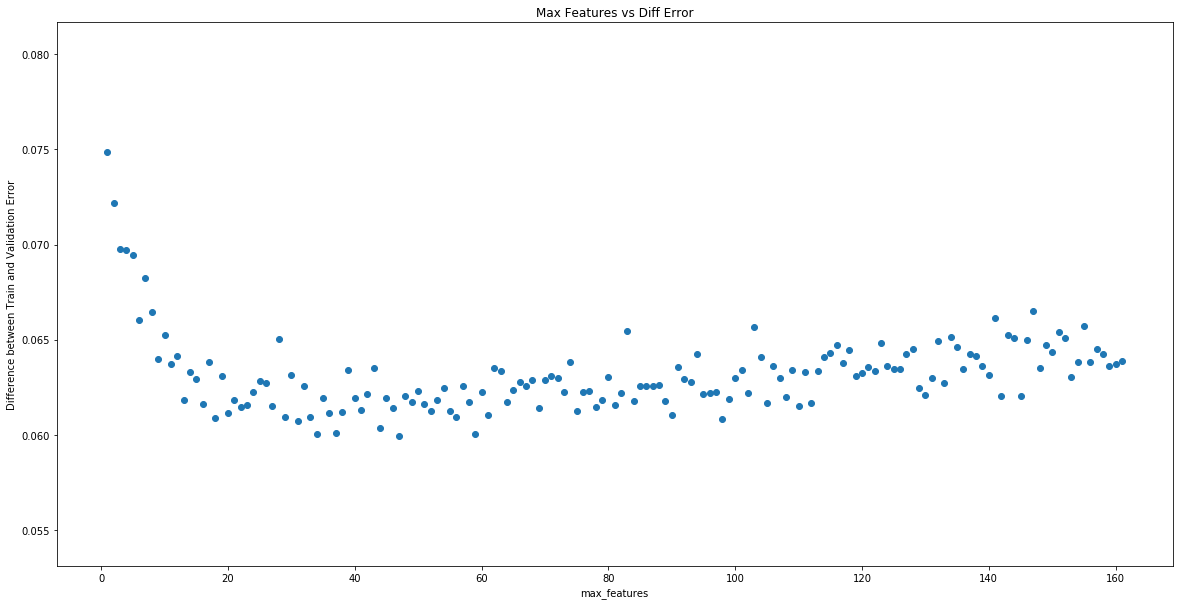

In [158]:
# Plots the diff err for max_features
plt.figure(figsize=(20,10))
pca_plot = plt.scatter(score_lst_features_df['max_features'] , score_lst_features_df['diff_err'])
plt.xlabel('max_features')
plt.ylabel('Difference between Train and Validation Error')
plt.title('Max Features vs Diff Error')
plt.show()

In [59]:
a = score_lst_features_df.sort_values(by=['train_rmse', 'validate_rmse','diff_err'], ascending= True)
feature_lr_trail = [39, 49, 130, 58, 73, 69, 22, 65]
feature_lr_trail = [87, 80, 67, 21, 55, 84, 63, 71, 40]
feature_lr_trail = [77,42,82,68,59,43,95,46]
a[a['validate_rmse'] < 28500]

n_estimators  max_depth  max_features  min_samples_leaf        r2  \
45           40.0       50.0          46.0               1.0  0.980867   
53           40.0       50.0          54.0               1.0  0.980750   
94           40.0       50.0          95.0               1.0  0.980346   
42           40.0       50.0          43.0               1.0  0.980243   
56           40.0       50.0          57.0               1.0  0.980052   
58           40.0       50.0          59.0               1.0  0.979929   
31           40.0       50.0          32.0               1.0  0.979879   
43           40.0       50.0          44.0               1.0  0.979411   
67           40.0       50.0          68.0               1.0  0.979293   
107          40.0       50.0         108.0               1.0  0.979270   
90           40.0       50.0          91.0               1.0  0.978784   
62           40.0       50.0          63.0               1.0  0.978803   
81           40.0       50.0          82.0               1.0  0.978787   
33           40.0       50.0          34.0               1.0  0.978744   
41           40.0       50.0          42.0               1.0  0.978730   
51           40.0       50.0          52.0               1.0  0.978634   
76           40.0       50.0          77.0               1.0  0.978632   
95           40.0       50.0          96.0               1.0  0.978543   
86           40.0       50.0          87.0               1.0  0.978373   
104          40.0       50.0         105.0               1.0  0.978385   
24           40.0       50.0          25.0               1.0  0.977718   
148          40.0       50.0         149.0               1.0  0.976293   

     train_err  validate_err  diff_err  train_rmse  validate_rmse  
45    0.038517      0.098249  0.059732     10971.4        27642.0  
53    0.038197      0.100997  0.062801     10996.6        28335.2  
94    0.038515      0.100943  0.062428     11122.0        27811.2  
42    0.038307      0.098901  0.060594     11147.6        27896.6  
56    0.038540      0.100387  0.061847     11205.6        28382.8  
58    0.038389      0.100971  0.062582     11241.4        27526.0  
31    0.038701      0.100154  0.061453     11242.4        28320.4  
43    0.038285      0.098654  0.060369     11360.6        28307.0  
67    0.038923      0.098472  0.059549     11408.0        27949.6  
107   0.038669      0.102556  0.063887     11421.2        28444.0  
90    0.038543      0.100716  0.062173     11534.2        28295.4  
62    0.038495      0.099401  0.060905     11534.4        28245.4  
81    0.038616      0.100633  0.062017     11535.4        27635.0  
33    0.038488      0.100302  0.061813     11558.6        28039.0  
41    0.038891      0.099156  0.060265     11569.4        27990.6  
51    0.038424      0.101084  0.062660     11584.6        28391.0  
76    0.038814      0.100490  0.061676     11603.2        27825.6  
95    0.039115      0.100675  0.061560     11623.0        28428.6  
86    0.038529      0.100255  0.061726     11657.6        28057.8  
104   0.038346      0.101609  0.063263     11664.6        28278.0  
24    0.038812      0.100102  0.061290     11849.6        28333.6  
148   0.039727      0.103023  0.063295     12207.0        28306.0

In [159]:
min_samples_leaf = [1,5,10,20,30,40,50,75,100,150,200,300, 400, 500, 1000, 1500, 2000]
score_lst_leaf = []
for i in min_samples_leaf:
    scores = run_model_inputs_rf(
        train_data, train_saleprice, 2, estimators=40, depth=50,
        features=42, samples_leaf=i, impurity_decrease = 0)
    score_lst_leaf.append(scores)

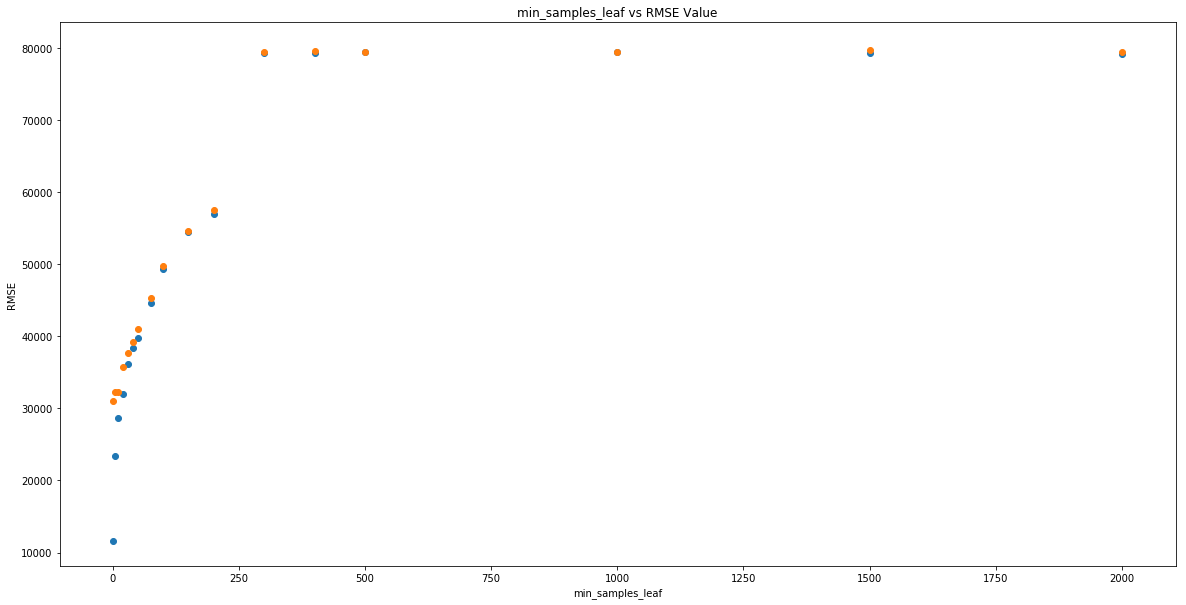

In [160]:
# Plots the train and validation rmse fro min_leaf
score_lst_leaf_df = pd.DataFrame(score_lst_leaf)
plt.figure(figsize=(20,10))
n_est_plot = plt.scatter(score_lst_leaf_df['min_samples_leaf'] , score_lst_leaf_df['train_rmse'])
plt.scatter(score_lst_leaf_df['min_samples_leaf'], score_lst_leaf_df['validate_rmse'])
plt.xlabel('min_samples_leaf')
plt.ylabel('RMSE')
plt.title('min_samples_leaf vs RMSE Value')
plt.show()

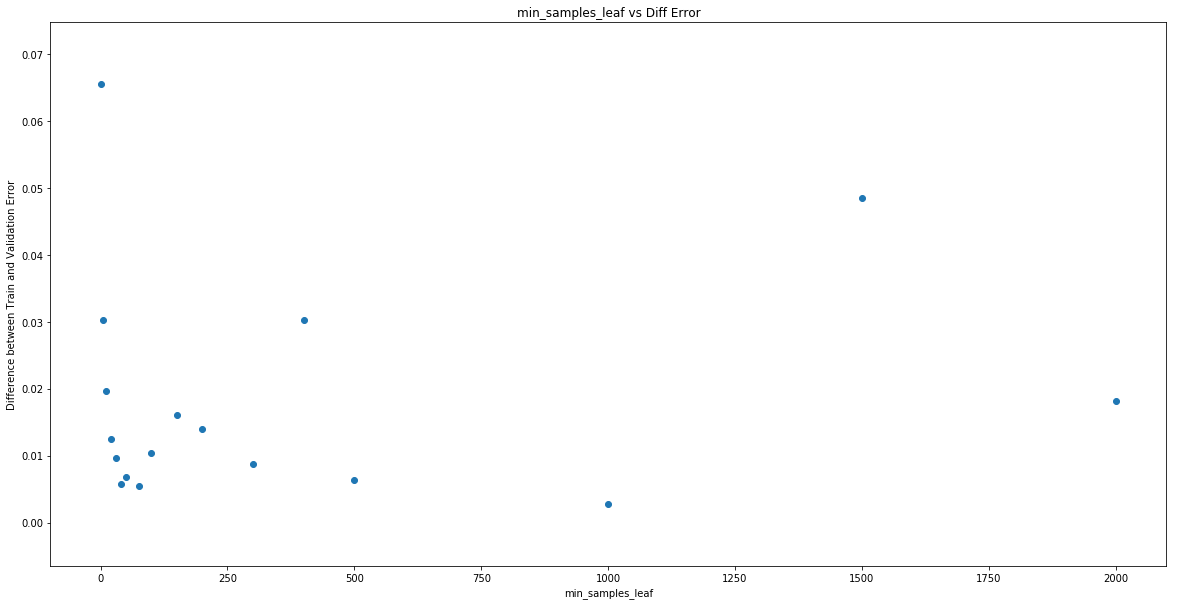

In [161]:
# Plots the diff err for min_leaf
plt.figure(figsize=(20,10))
pca_plot = plt.scatter(score_lst_leaf_df['min_samples_leaf'] , score_lst_leaf_df['diff_err'])
plt.xlabel('min_samples_leaf')
plt.ylabel('Difference between Train and Validation Error')
plt.title('min_samples_leaf vs Diff Error')
plt.show()

In [162]:
min_impurity_decrease = np.arange(0.0, 1.0, 0.01)
score_lst_impurity_split = []
for i in min_impurity_decrease:
    scores = run_model_inputs_rf(
        train_data, train_saleprice, 2, estimators=40, depth=50,
        features=42, samples_leaf=1, impurity_decrease = i)
    score_lst_impurity_split.append(scores)

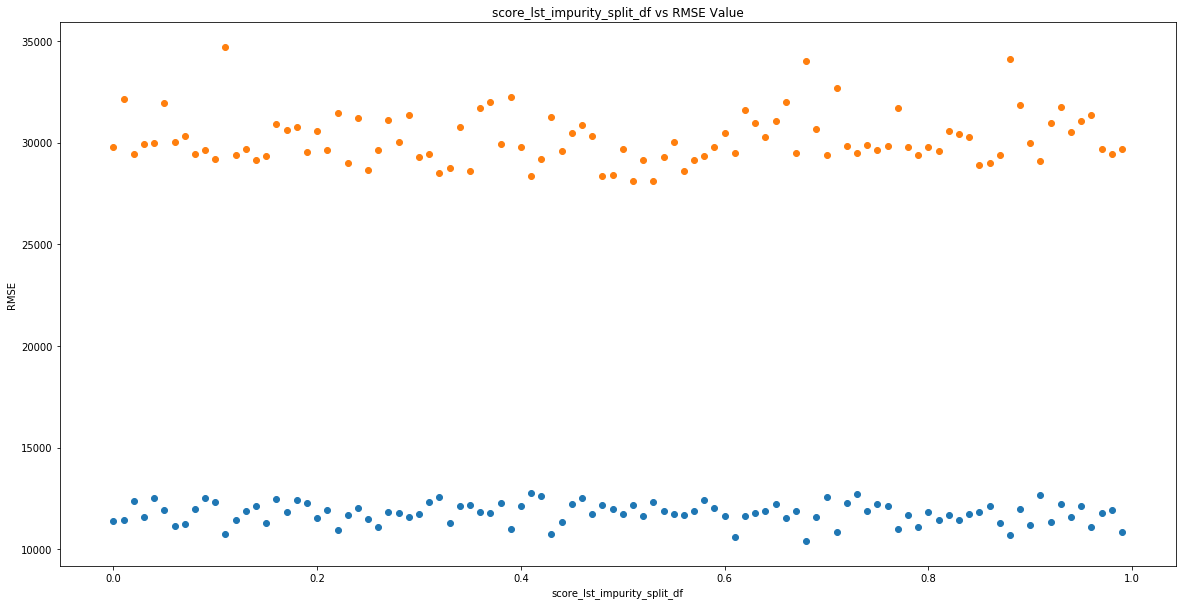

In [163]:
# Plots the train and validation rmse fro min_leaf
score_lst_impurity_split_df = pd.DataFrame(score_lst_impurity_split)
plt.figure(figsize=(20,10))
n_est_plot = plt.scatter(score_lst_impurity_split_df['min_impurity_decrease'] , score_lst_impurity_split_df['train_rmse'])
plt.scatter(score_lst_impurity_split_df['min_impurity_decrease'], score_lst_impurity_split_df['validate_rmse'])
plt.xlabel('score_lst_impurity_split_df')
plt.ylabel('RMSE')
plt.title('score_lst_impurity_split_df vs RMSE Value')
plt.show()

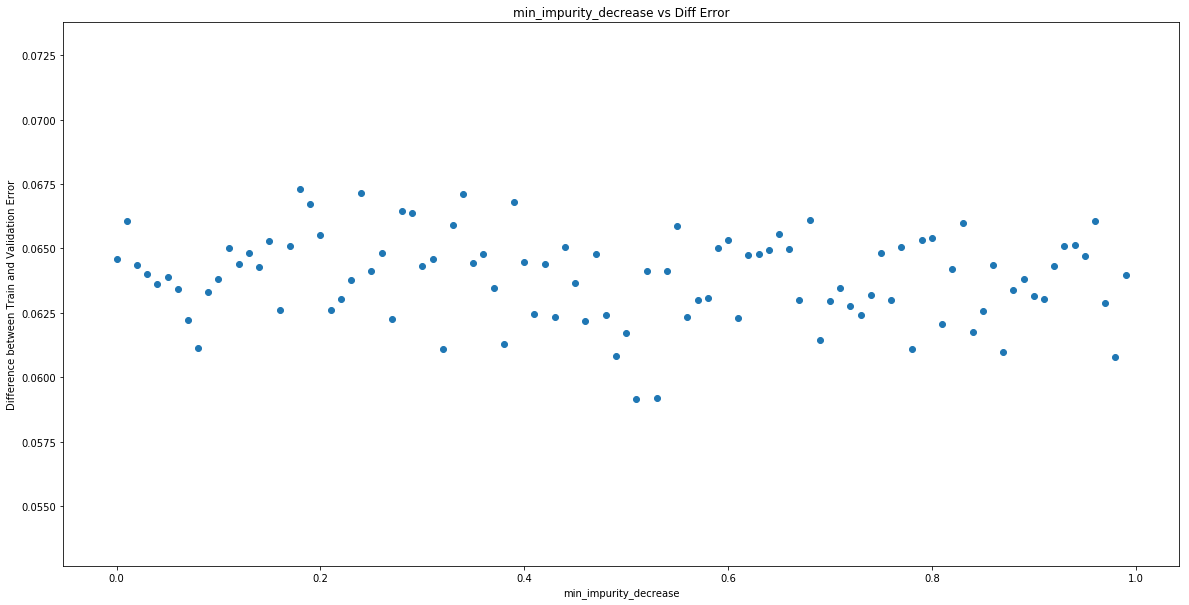

In [164]:
# Plots the diff err for min_leaf
plt.figure(figsize=(20,10))
pca_plot = plt.scatter(score_lst_impurity_split_df['min_impurity_decrease'] , score_lst_impurity_split_df['diff_err'])
plt.xlabel('min_impurity_decrease')
plt.ylabel('Difference between Train and Validation Error')
plt.title('min_impurity_decrease vs Diff Error')
plt.show()

In [63]:
forest.estimator_params

('criterion',
 'max_depth',
 'min_samples_split',
 'min_samples_leaf',
 'min_weight_fraction_leaf',
 'max_features',
 'max_leaf_nodes',
 'min_impurity_decrease',
 'min_impurity_split',
 'random_state')

In [ ]:
# Idea to model regresion model on first 10-----100 important components and view results
pd.DataFrame(feature_imp).reset_index()

# Random Forest with Mininal Feature Engineering

In [177]:
# def feature_eng(model_data, max_predictor_corr_delete, max_predictor_corr_dim_red, min_response_corr):
def min_feature_eng_rf(model_data, is_train):

    id_col = model_data['Id']
    
    model_data['GarageYrBlt'] = model_data['GarageYrBlt'].fillna(0)
    model_data['GarageCars'] = model_data['GarageCars'].fillna(0)
    model_data['LotFrontage'] = model_data['LotFrontage'].fillna(0)
    model_data['MasVnrArea'] = model_data['MasVnrArea'].fillna(0)

    # Replace any null values in categorical variables with 'Not Available'
    for i in model_data.columns:
        if model_data[i].dtypes == 'object':
            model_data[i] = model_data[i].fillna('Not_Available')
            
    model_data['NumBath'] = (model_data['FullBath'].fillna(0) + model_data['HalfBath'].fillna(0)/2 + 
                       model_data['BsmtHalfBath'].fillna(0)/2 + model_data['BsmtFullBath'].fillna(0))
    
    
    model_data['LivingSF'] = (model_data['1stFlrSF'].fillna(0) + model_data['2ndFlrSF'].fillna(0) 
                               + model_data['TotalBsmtSF'].fillna(0))

    
    model_data['TotalLotArea'] = model_data['LotArea'] + model_data['LotFrontage']

    
    
    # combine total SF features outside
    model_data['NonLivingSF'] = (model_data['EnclosedPorch'].fillna(0) + model_data['PoolArea'].fillna(0) + 
                                 model_data['GarageArea'].fillna(0) + model_data['ScreenPorch'].fillna(0) + 
                                 model_data['OpenPorchSF'].fillna(0) +  model_data['WoodDeckSF'].fillna(0))
    
    model_data['MSSubClassCat'] = model_data['MSSubClass'].astype('category')
    
    
    # Add int variables for ExterQual and ExterCond
    model_data['ExterQualInt'] =  np.where(model_data['ExterQual'] == "Ex", 9, 
                                            np.where(model_data['ExterQual'] == "Gd", 7, 
                                                    np.where(model_data['ExterQual'] == "TA", 5, 
                                                            np.where(model_data['ExterQual'] == "Fa", 3, 
                                                                    np.where(model_data['ExterQual'] == "Po", 2,0)))))

    # Add int variables for all categorical basement variables
    model_data['BsmtQualInt'] =  np.where(model_data['BsmtQual'] == "Ex", 9, 
                                            np.where(model_data['BsmtQual'] == "Gd", 7, 
                                                    np.where(model_data['BsmtQual'] == "TA", 5, 
                                                            np.where(model_data['BsmtQual'] == "Fa", 3, 
                                                                    np.where(model_data['BsmtQual'] == "Po", 2,0)))))


    model_data['GarageQualInt'] =  np.where(model_data['GarageQual'] == "Ex", 9, 
                                            np.where(model_data['GarageQual'] == "Gd", 7, 
                                                    np.where(model_data['GarageQual'] == "TA", 5, 
                                                            np.where(model_data['GarageQual'] == "Fa", 3, 
                                                                    np.where(model_data['GarageQual'] == "Po", 2,0)))))
    # Add interaction variables for KitchenQual
    model_data['KitchenQualInt'] =  np.where(model_data['KitchenQual'] == "Ex", 9, 
                                            np.where(model_data['KitchenQual'] == "Gd", 7, 
                                                    np.where(model_data['KitchenQual'] == "TA", 5, 
                                                            np.where(model_data['KitchenQual'] == "Fa", 3, 
                                                                    np.where(model_data['KitchenQual'] == "Po", 2,0)))))

#     model_data = model_data.drop(columns=['EnclosedPorch', 'PoolArea', 'GarageArea', 'ScreenPorch', 
#                                           'OpenPorchSF', 'WoodDeckSF', 'MSSubClass', 'KitchenAbvGr', 
#                                           'OverallCond', 'BsmtFinType1', 'BsmtFinType2', 'Exterior2nd', 
#                                           'Condition2', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'BsmtUnfSF',
#                                           'BsmtFinSF1', 'LotArea', 'LotFrontage', 'YrSold', 'LowQualFinSF', 
#                                           'MiscVal', 'BsmtFinSF2', '3SsnPorch', 'MoSold', 'Id', 'FullBath', 
#                                           'HalfBath', 'BsmtHalfBath', 'BsmtFullBath', 'PoolQC', 'MiscFeature', 
#                                           'Alley', 'Fence', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
#                                           'BsmtExposure', 'GarageCond', 'GarageQual', 'KitchenQual'])
    
    model_data = pd.get_dummies(model_data, drop_first=True)

    # Delete any Not_Available columns (no use in the model)
#     model_data = model_data[model_data.columns.drop(list(model_data.filter(regex='Not_Available')))]

    if is_train:   
        model_data = model_data.drop(columns = ['SalePrice'])
    
    
#     model_data_col = model_data.columns
#     model_data = MinMaxScaler().fit_transform(model_data)
#     model_data = scale(model_data)
#     model_data = pd.DataFrame(model_data, columns=model_data_col)
        
    return model_data, id_col
    

In [166]:
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')
print('Shape of train data:', train_data.shape)
print('Shape of test data:', test_data.shape)

train_saleprice = train_data['SalePrice']
train_data, train_id = min_feature_eng_rf(train_data, True)
test_data, test_id = min_feature_eng_rf(test_data, False)

for i in train_data.columns:
    if i not in test_data.columns:
        train_data = train_data.drop(columns = i)
print('Shape of train data:', train_data.shape)
test_data = test_data[train_data.columns]
print('Shape of test data:', test_data.shape)

Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 265)
Shape of test data: (1459, 265)


No handles with labels found to put in legend.


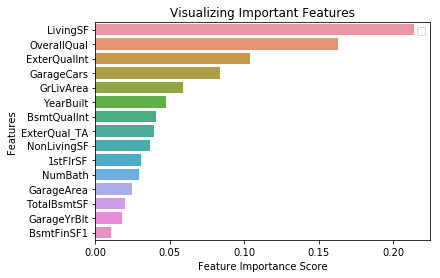

In [167]:
# Create a classifier
forest = RandomForestRegressor(n_estimators=100, max_depth=20, max_features=50, min_samples_leaf=50)
train_X, validate_X, train_y, validate_y = train_test_split(train_data, train_saleprice, test_size=0.2)
forest.fit(train_X,train_y)
feature_imp = pd.Series(forest.feature_importances_, index = train_data.columns).sort_values(ascending=False)
feature_imp
feature_imp_head = feature_imp.head(15)

sns.barplot(x=feature_imp_head, y=feature_imp_head.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [168]:
train_predictions = forest.predict(train_X)
train_predictions = pd.DataFrame(train_predictions)
train_predictions.columns = ['PredSalePrice']
train_y_df = pd.DataFrame(train_y)
train_y_df = train_y_df.reset_index(drop=True)
train_predictions['SalePrice'] = train_y_df['SalePrice']
train_predictions['PredErr'] = (abs(
    train_predictions['PredSalePrice'] - train_predictions['SalePrice'])/train_predictions['SalePrice'])
avg_train_err = train_predictions['PredErr'].mean()
avg_train_err

0.1307083097482599

In [169]:
forest.score(train_X, train_y)

0.7763036537359428

In [170]:
validate_predictions = forest.predict(validate_X)
validate_predictions = pd.DataFrame(validate_predictions)
validate_predictions.columns = ['PredSalePrice']
validate_y_df = pd.DataFrame(validate_y)
validate_y_df = validate_y_df.reset_index(drop=True)
validate_predictions['SalePrice'] = validate_y_df['SalePrice']
validate_predictions['PredErr'] = (abs(
    validate_predictions['PredSalePrice'] - validate_predictions['SalePrice'])/validate_predictions['SalePrice'])
avg_validate_err = validate_predictions['PredErr'].mean()
avg_validate_err

0.12082458605258976

In [173]:
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')
print('Shape of train data:', train_data.shape)
print('Shape of test data:', test_data.shape)

train_saleprice = train_data['SalePrice']
train_data, train_id = min_feature_eng_rf(train_data, True)
test_data, test_id = min_feature_eng_rf(test_data, False)

for i in train_data.columns:
    if i not in test_data.columns:
        train_data = train_data.drop(columns = i)
print('Shape of train data:', train_data.shape)
test_data = test_data[train_data.columns]
print('Shape of test data:', test_data.shape)

Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 265)
Shape of test data: (1459, 265)


In [174]:
n_est = [10,20,30,40,50,75,100,150,200,300,400,500,600,700,800,900,1000]
score_lst = []
for i in n_est:
    scores = run_model_inputs_rf(
        train_data, train_saleprice, 2, estimators=i, depth=1000000, features=train_data.shape[1], samples_leaf=1, 
        impurity_decrease = 0)
    score_lst.append(scores)

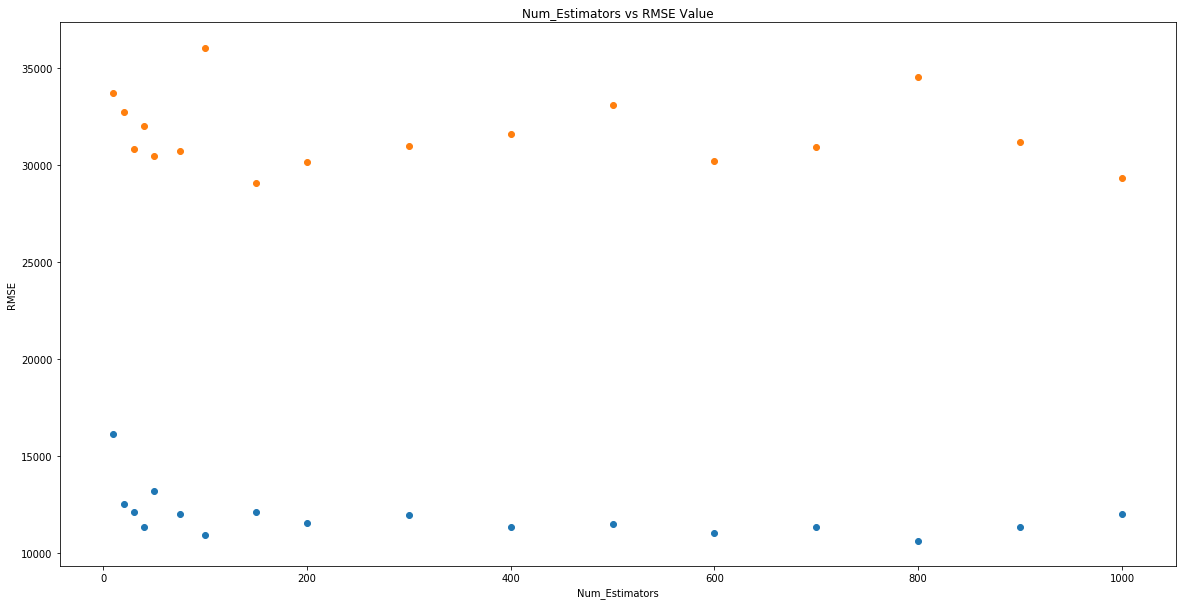

In [175]:
# Plots the train and validation rmse
score_lst_df = pd.DataFrame(score_lst)
plt.figure(figsize=(20,10))
n_est_plot = plt.scatter(score_lst_df['n_estimators'] , score_lst_df['train_rmse'])
plt.scatter(score_lst_df['n_estimators'], score_lst_df['validate_rmse'])
plt.xlabel('Num_Estimators')
plt.ylabel('RMSE')
plt.title('Num_Estimators vs RMSE Value')
plt.show()

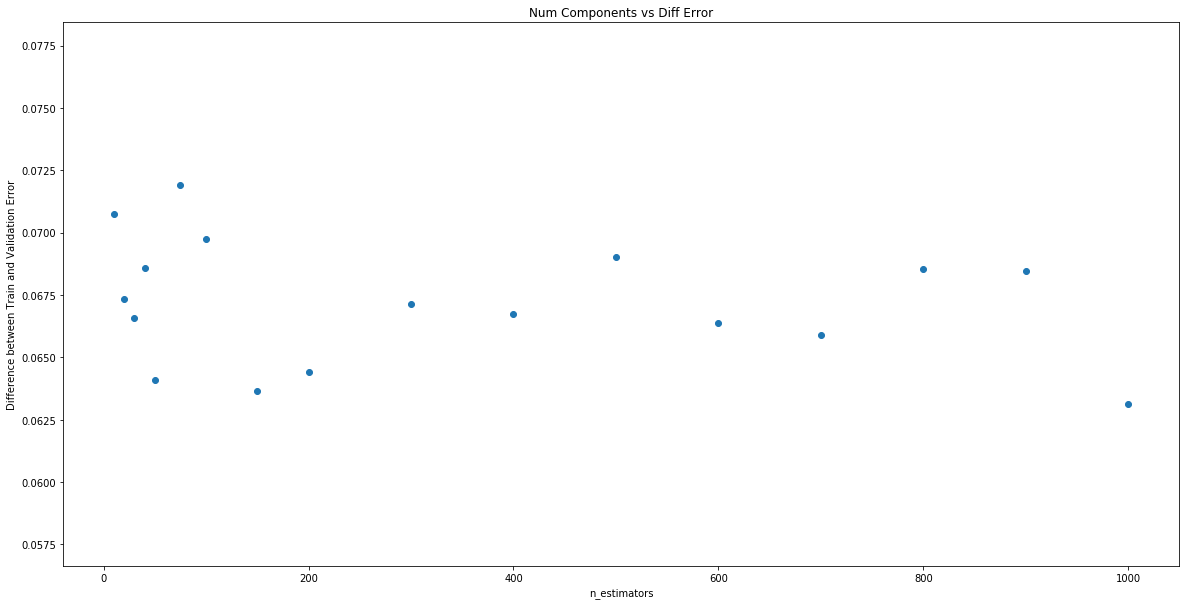

In [176]:
# Plots the diff err
plt.figure(figsize=(20,10))
pca_plot = plt.scatter(score_lst_df['n_estimators'] , score_lst_df['diff_err'])
plt.xlabel('n_estimators')
plt.ylabel('Difference between Train and Validation Error')
plt.title('Num Components vs Diff Error')
plt.show()

In [178]:
max_depth = [10,20,30,40,50,75,100,150,200,300,400,500,600,700,800,900,1000]
score_lst_max_depth = []
for i in max_depth:
    scores = run_model_inputs_rf(
        train_data, train_saleprice, 2, estimators=40, depth=i,
        features=train_data.shape[1], samples_leaf=1, impurity_decrease = 0)
    score_lst_max_depth.append(scores)

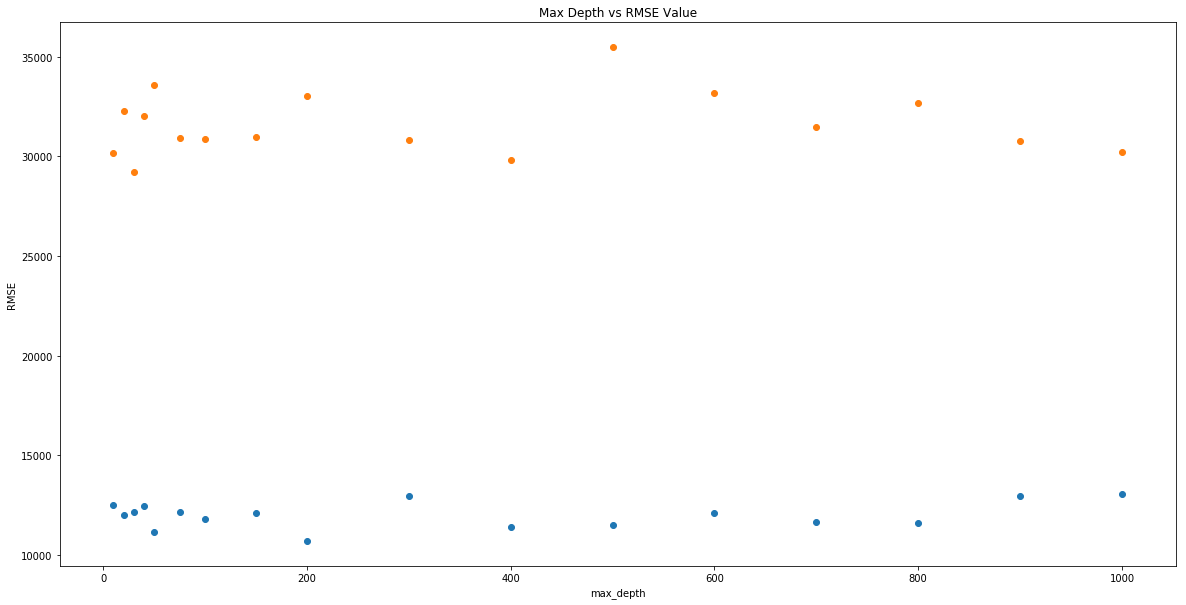

In [179]:
# Plots the train and validation rmse fro max_depth
score_lst_max_depth_df = pd.DataFrame(score_lst_max_depth)
plt.figure(figsize=(20,10))
n_est_plot = plt.scatter(score_lst_max_depth_df['max_depth'] , score_lst_max_depth_df['train_rmse'])
plt.scatter(score_lst_max_depth_df['max_depth'], score_lst_max_depth_df['validate_rmse'])
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.title('Max Depth vs RMSE Value')
plt.show()

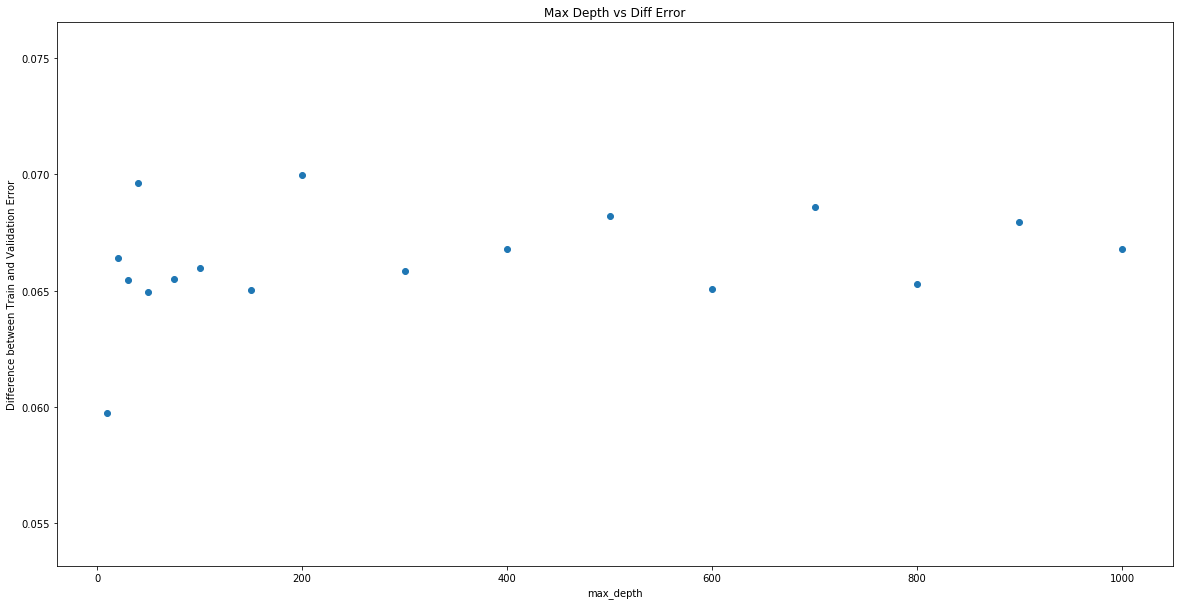

In [180]:
# Plots the diff err for max_depth
plt.figure(figsize=(20,10))
pca_plot = plt.scatter(score_lst_max_depth_df['max_depth'] , score_lst_max_depth_df['diff_err'])
plt.xlabel('max_depth')
plt.ylabel('Difference between Train and Validation Error')
plt.title('Max Depth vs Diff Error')
plt.show()

In [181]:
max_features = range(1,train_data.shape[1],1)
score_lst_features = []
for i in max_features:
    scores = run_model_inputs_rf(
        train_data, train_saleprice, 2, estimators=40, depth=50,
        features=i, samples_leaf=1, impurity_decrease = 0)
    score_lst_features.append(scores)

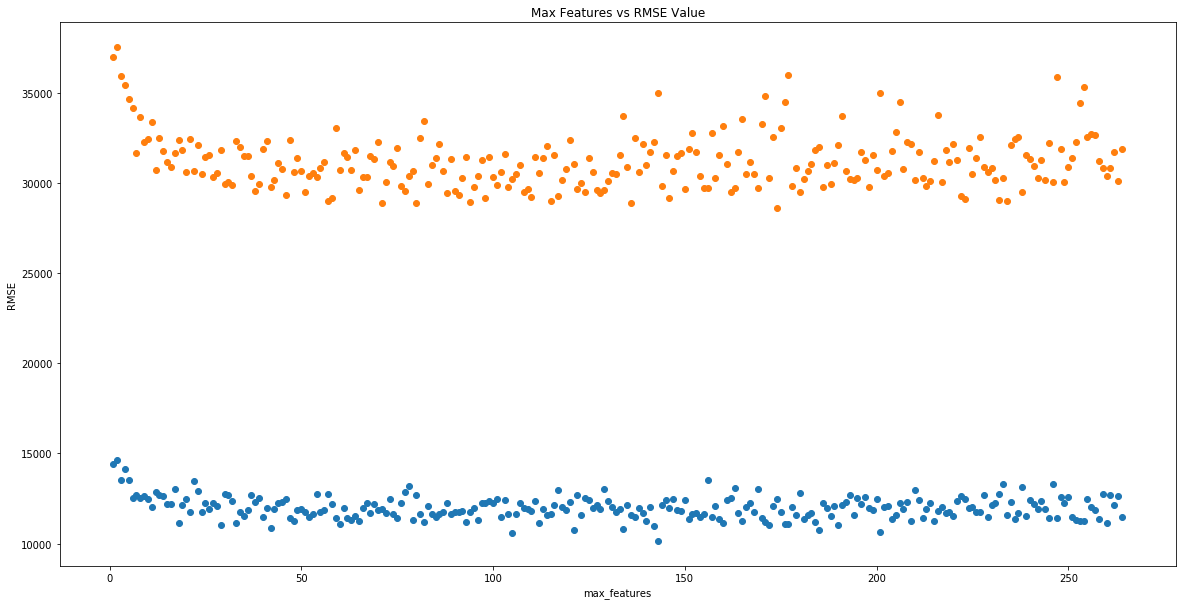

In [182]:
# Plots the train and validation rmse fro max_features
score_lst_features_df = pd.DataFrame(score_lst_features)
plt.figure(figsize=(20,10))
n_est_plot = plt.scatter(score_lst_features_df['max_features'] , score_lst_features_df['train_rmse'])
plt.scatter(score_lst_features_df['max_features'], score_lst_features_df['validate_rmse'])
plt.xlabel('max_features')
plt.ylabel('RMSE')
plt.title('Max Features vs RMSE Value')
plt.show()

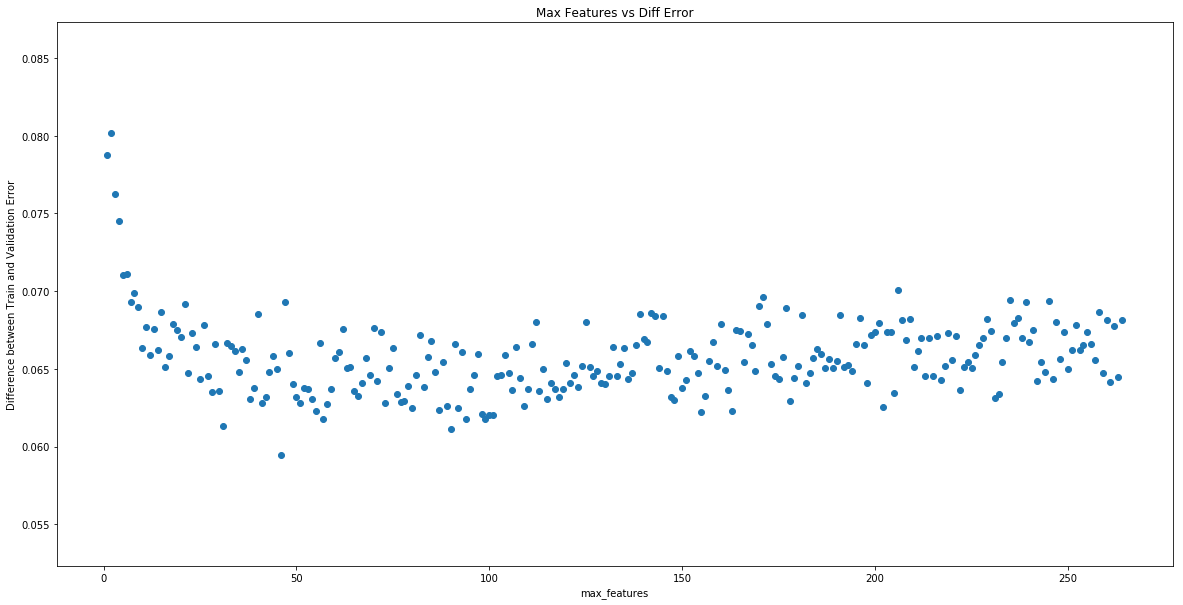

In [183]:
# Plots the diff err for max_features
plt.figure(figsize=(20,10))
pca_plot = plt.scatter(score_lst_features_df['max_features'] , score_lst_features_df['diff_err'])
plt.xlabel('max_features')
plt.ylabel('Difference between Train and Validation Error')
plt.title('Max Features vs Diff Error')
plt.show()

In [184]:
min_samples_leaf = [1,5,10,20,30,40,50,75,100,150,200,300, 400, 500, 1000]
score_lst_leaf = []
for i in min_samples_leaf:
    scores = run_model_inputs_rf(
        train_data, train_saleprice, 2, estimators=40, depth=50,
        features=42, samples_leaf=i, impurity_decrease = 0)
    score_lst_leaf.append(scores)

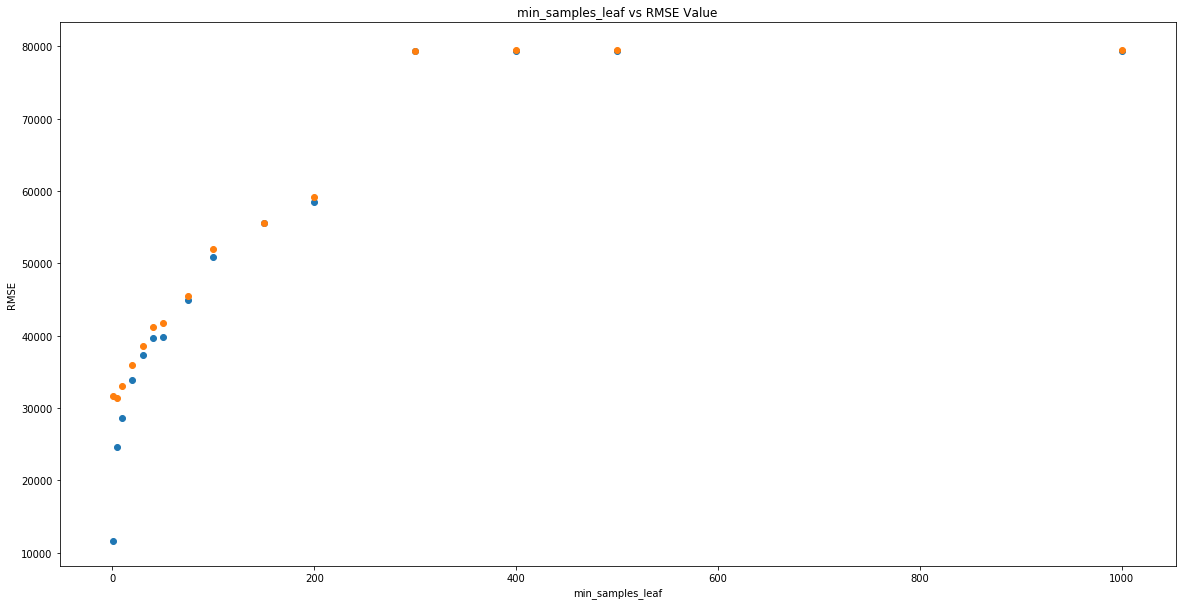

In [185]:
# Plots the train and validation rmse fro min_leaf
score_lst_leaf_df = pd.DataFrame(score_lst_leaf)
plt.figure(figsize=(20,10))
n_est_plot = plt.scatter(score_lst_leaf_df['min_samples_leaf'] , score_lst_leaf_df['train_rmse'])
plt.scatter(score_lst_leaf_df['min_samples_leaf'], score_lst_leaf_df['validate_rmse'])
plt.xlabel('min_samples_leaf')
plt.ylabel('RMSE')
plt.title('min_samples_leaf vs RMSE Value')
plt.show()

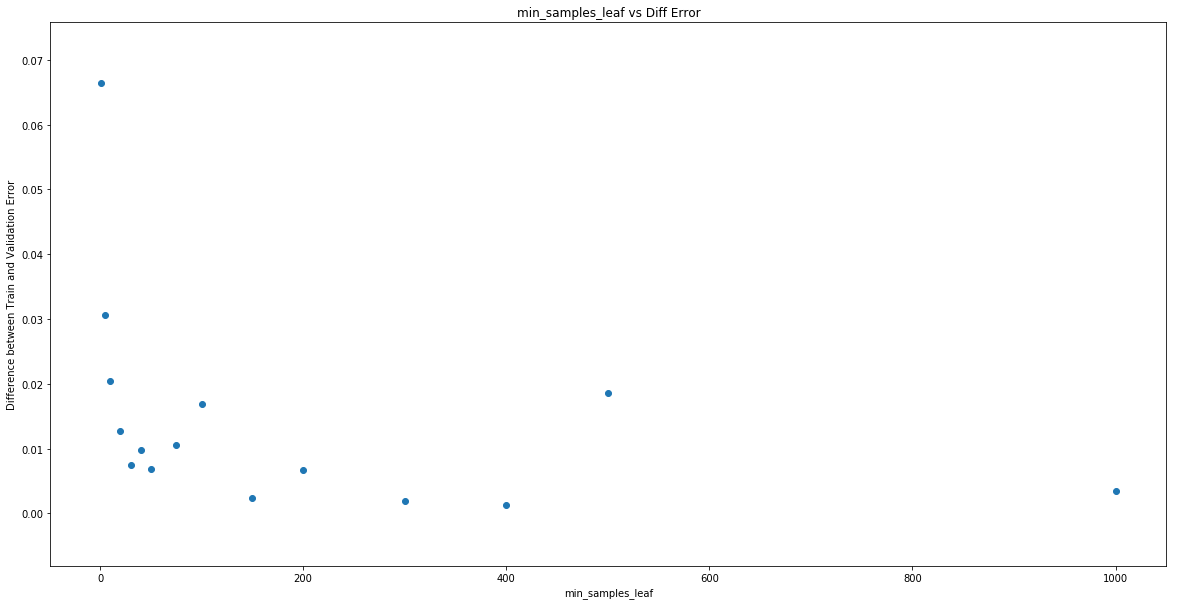

In [186]:
# Plots the diff err for min_leaf
plt.figure(figsize=(20,10))
pca_plot = plt.scatter(score_lst_leaf_df['min_samples_leaf'] , score_lst_leaf_df['diff_err'])
plt.xlabel('min_samples_leaf')
plt.ylabel('Difference between Train and Validation Error')
plt.title('min_samples_leaf vs Diff Error')
plt.show()

In [187]:
min_impurity_decrease = np.arange(0.0, 1.0, 0.02)
score_lst_impurity_split = []
for i in min_impurity_decrease:
    scores = run_model_inputs_rf(
        train_data, train_saleprice, 2, estimators=40, depth=50,
        features=42, samples_leaf=1, impurity_decrease = i)
    score_lst_impurity_split.append(scores)

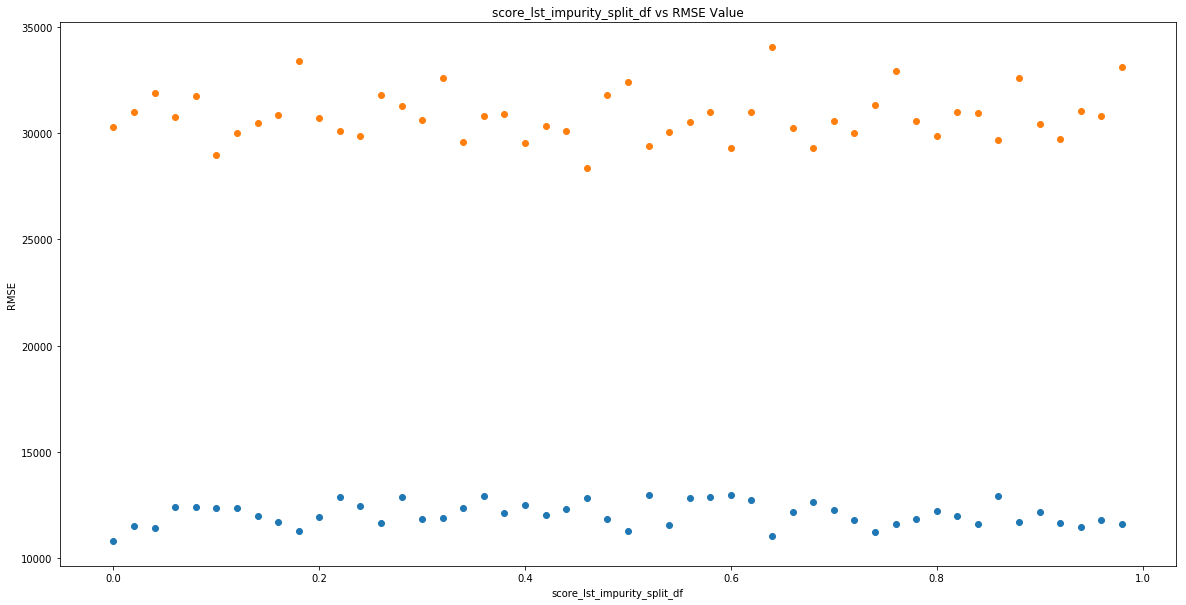

In [188]:
# Plots the train and validation rmse fro min_leaf
score_lst_impurity_split_df = pd.DataFrame(score_lst_impurity_split)
plt.figure(figsize=(20,10))
n_est_plot = plt.scatter(score_lst_impurity_split_df['min_impurity_decrease'] , score_lst_impurity_split_df['train_rmse'])
plt.scatter(score_lst_impurity_split_df['min_impurity_decrease'], score_lst_impurity_split_df['validate_rmse'])
plt.xlabel('score_lst_impurity_split_df')
plt.ylabel('RMSE')
plt.title('score_lst_impurity_split_df vs RMSE Value')
plt.show()

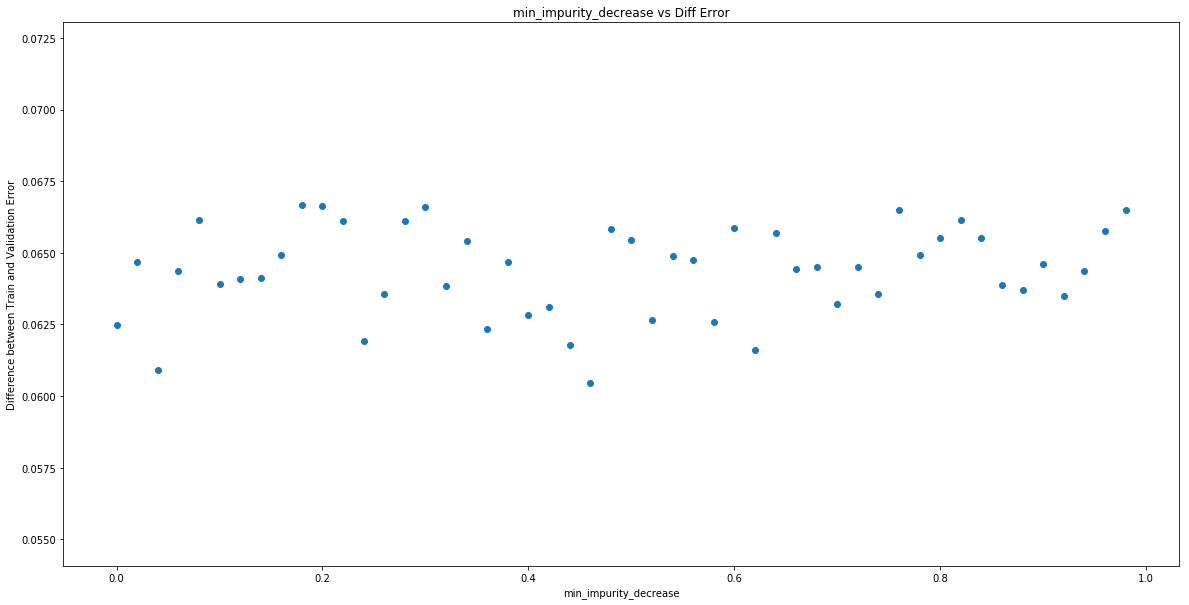

In [189]:
# Plots the diff err for min_leaf
plt.figure(figsize=(20,10))
pca_plot = plt.scatter(score_lst_impurity_split_df['min_impurity_decrease'] , score_lst_impurity_split_df['diff_err'])
plt.xlabel('min_impurity_decrease')
plt.ylabel('Difference between Train and Validation Error')
plt.title('min_impurity_decrease vs Diff Error')
plt.show()

# LR model with Top 20-40 Features from RF

In [190]:
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')
print('Shape of train data:', train_data.shape)
print('Shape of test data:', test_data.shape)

train_saleprice = train_data['SalePrice']
train_data, train_id = feature_eng(train_data,0, 2, True)
test_data, test_id = feature_eng(test_data,0, 2, False)

for i in train_data.columns:
    if i not in test_data.columns:
        train_data = train_data.drop(columns = i)
print('Shape of train data:', train_data.shape)
test_data = test_data[train_data.columns]
print('Shape of test data:', test_data.shape)

Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 162)
Shape of test data: (1459, 162)


In [205]:
# Create a classifier
forest = RandomForestRegressor(n_estimators=100, max_depth=20, max_features=50, min_samples_leaf=50)
train_X, validate_X, train_y, validate_y = train_test_split(train_data, train_saleprice, test_size=0.2)
forest.fit(train_X,train_y)
feature_imp = pd.Series(forest.feature_importances_, index = train_data.columns).sort_values(ascending=False)
feature_imp_df = pd.DataFrame(feature_imp).reset_index()
feature_imp_df.columns = ['col_name', 'feature_imp']

In [206]:
def run_model_inputs(train_data, train_saleprice, test_data, test_id, k):
    kf = KFold(n_splits=k, shuffle=True, random_state=round(random.uniform(1, 40000)))
    # kf = KFold(n_splits=10, shuffle=True, random_state=6104)
    kf.get_n_splits(train_data)
    print(kf)
    log_scores = []
    scores = []
    for train_index, test_index in kf.split(train_data):
        train_X, validate_X = train_data.loc[train_index,:], train_data.loc[test_index,:]
        train_y, validate_y = train_saleprice.loc[train_index], train_saleprice.loc[test_index]
        model = sm.OLS(train_y, sm.add_constant(train_X)).fit()
#         print(model.summary())
        # calculations to get percent error
        train_predictions = model.predict(sm.add_constant(train_X, has_constant='add'))
        avg_train_err = round(((abs(train_y - train_predictions))/train_y).mean()*100,2)
        
        train_predictions = pd.DataFrame(train_predictions)
        print(train_predictions[train_predictions.loc[:,0] <= 0])

        validate_predictions = model.predict(sm.add_constant(validate_X, has_constant='add'))
        avg_validate_err = ((abs(validate_y - validate_predictions))/validate_y).mean()*100
        
        scores.append([model.rsquared_adj, avg_train_err, avg_validate_err, abs(avg_train_err-avg_validate_err),
                       round(sqrt(mean_squared_error(train_y, train_predictions))), 
                       round(sqrt(mean_squared_error(validate_y, validate_predictions)))])

        # fitted values
        model_fitted = pd.DataFrame(model.fittedvalues)

        # model residuals
        model_residuals = pd.DataFrame(model.resid)

        # Residual plot
        residual_plot = plt.scatter(model_fitted , model_residuals)
        plt.show()

    scores = pd.DataFrame(scores, columns = ['adjr2', 'train_err', 'validate_err', 'diff_err', 
                                             'train_rmse', 'validate_rmse'])
    print(scores)
    print(scores.describe())
    
    final_model = sm.OLS(train_saleprice, sm.add_constant(train_data)).fit()
    
    test_predictions = final_model.predict(sm.add_constant(test_data))
    test_predictions = pd.DataFrame(test_predictions)
    test_predictions.columns = ['SalePrice']
    test_predictions = pd.concat([test_id, test_predictions], axis=1)
    
    return test_predictions, scores

KFold(n_splits=5, random_state=30591, shuffle=True)
Empty DataFrame
Columns: [0]
Index: []


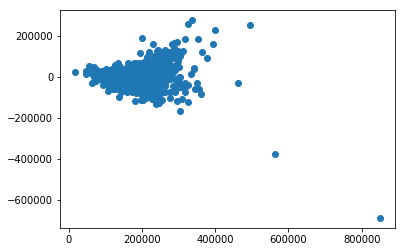

Empty DataFrame
Columns: [0]
Index: []


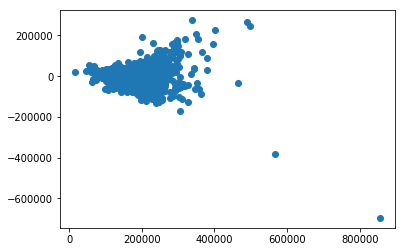

Empty DataFrame
Columns: [0]
Index: []


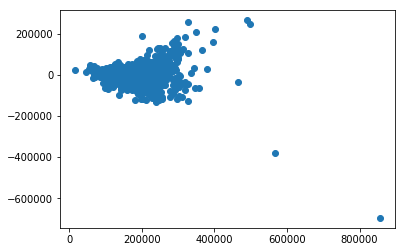

Empty DataFrame
Columns: [0]
Index: []


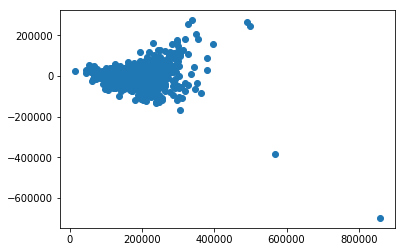

Empty DataFrame
Columns: [0]
Index: []


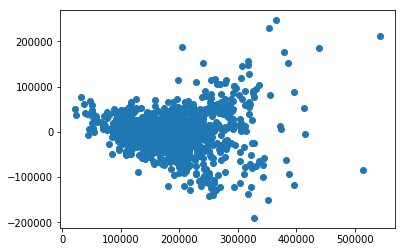

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.592080      19.26     18.693900  0.566100       50537          45260
1  0.590594      19.11     19.606533  0.496533       51084          42617
2  0.596393      19.06     19.513235  0.453235       50365          45894
3  0.596015      19.45     17.883754  1.566246       50128          46888
4  0.694684      19.11     21.882358  2.772358       44078          69597
          adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
count  5.000000   5.000000      5.000000  5.000000      5.0000       5.000000
mean   0.613953  19.198000     19.515956  1.170895  49238.4000   50051.200000
std    0.045199   0.159593      1.495655  1.007046   2906.1549   11040.260083
min    0.590594  19.060000     17.883754  0.453235  44078.0000   42617.000000
25%    0.592080  19.110000     18.693900  0.496533  50128.0000   45260.000000
50%    0.596015  19.110000     19.513235  0.566100  50365.0000   45894.000000
75%    0.5

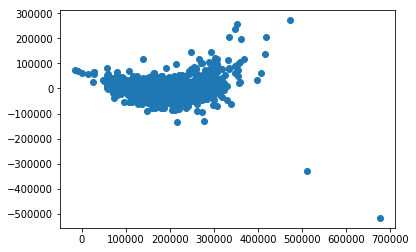

                 0
375   -5501.438700
533  -57425.819725
916   -2991.026505
1100 -12605.117804


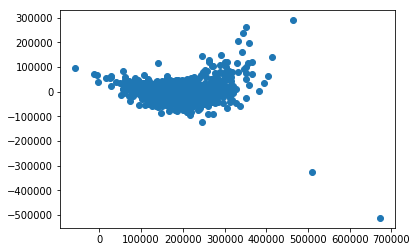

                 0
375   -1980.797202
533  -69815.749716
636   -4767.243824
916  -10397.599021
1100 -22957.622152


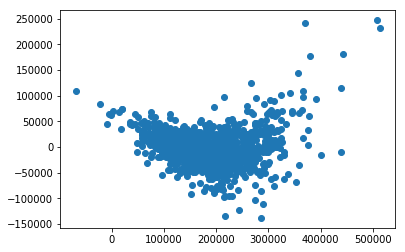

                0
533 -60695.074307
636   -795.407325
916  -5265.803266


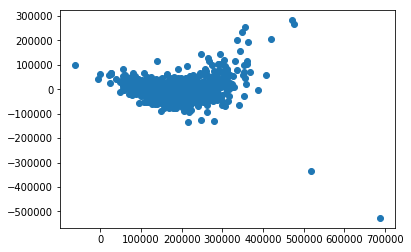

                 0
375    -425.640763
533  -54207.932947
1100  -9938.850782


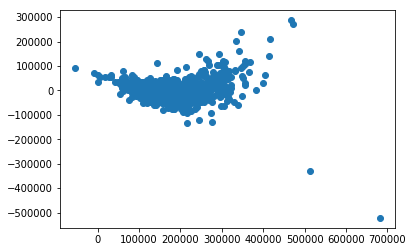

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.734688      15.93     17.118516  1.188516       41053          37533
1  0.727364      16.16     15.560324  0.599676       40752          38890
2  0.799443      16.06     18.563697  2.503697       35479          57498
3  0.724266      16.56     14.523959  2.036041       42265          31542
4  0.729322      16.11     15.292389  0.817611       41220          36801
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000   5.000000      5.000000  5.000000      5.000000   
mean   0.743017  16.164000     16.211777  1.429108  40153.800000   
std    0.031770   0.237339      1.618031  0.812847   2674.607766   
min    0.724266  15.930000     14.523959  0.599676  35479.000000   
25%    0.727364  16.060000     15.292389  0.817611  40752.000000   
50%    0.729322  16.110000     15.560324  1.188516  41053.000000   
75%    0.734688  16.160000     17.118516  2.036041  41220.000000   
max    0.799

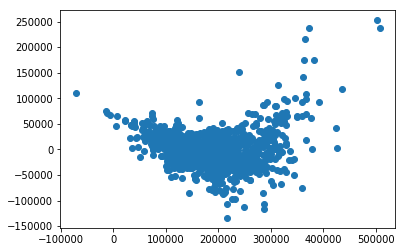

                 0
375  -13624.407732
533  -58099.187041
636   -7148.630791
1100  -1046.042741


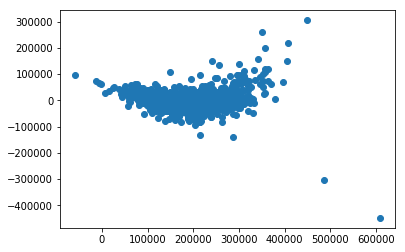

                0
1100 -1567.733727


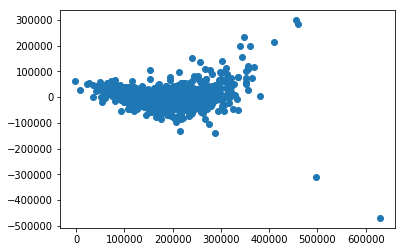

                0
375  -8902.465795
533 -55768.490029
636  -4867.881100


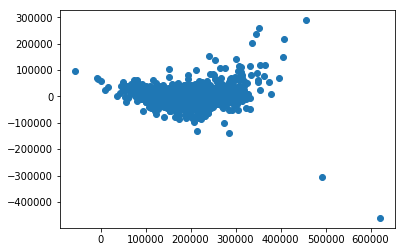

                0
375 -12792.266858
533 -63073.175402
636 -10181.664873


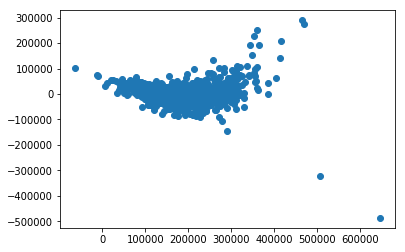

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.804236      15.66     17.543564  1.883564       35645          52614
1  0.754973      15.59     14.512382  1.077618       38746          40265
2  0.742411      15.30     15.287880  0.012120       39900          34973
3  0.748307      15.29     14.927427  0.362573       39084          38667
4  0.753114      15.60     15.441276  0.158724       40308          32971
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000   5.000000      5.000000  5.000000      5.000000   
mean   0.760608  15.488000     15.542506  0.698920  38736.600000   
std    0.024868   0.178241      1.174606  0.778368   1837.223666   
min    0.742411  15.290000     14.512382  0.012120  35645.000000   
25%    0.748307  15.300000     14.927427  0.158724  38746.000000   
50%    0.753114  15.590000     15.287880  0.362573  39084.000000   
75%    0.754973  15.600000     15.441276  1.077618  39900.000000   
max    0.804

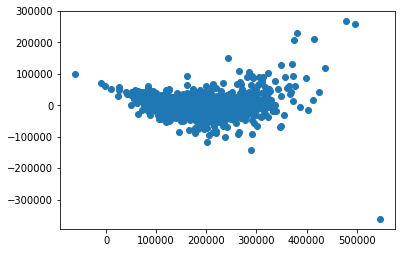

                0
375 -13374.371884
533 -59759.298377
636 -13547.818856


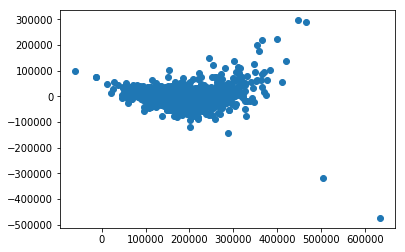

                0
533 -55939.088198
636 -10782.643287


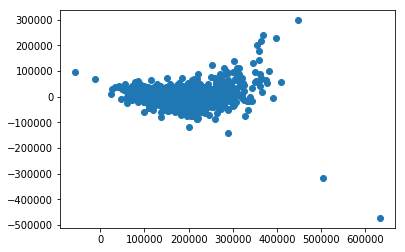

               0
375 -8305.586503


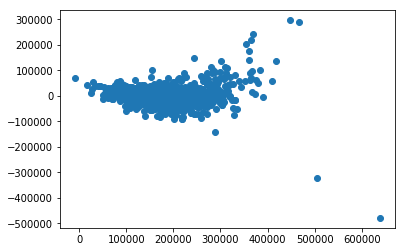

                0
375  -8131.502624
533 -56515.083027
636 -10387.731686


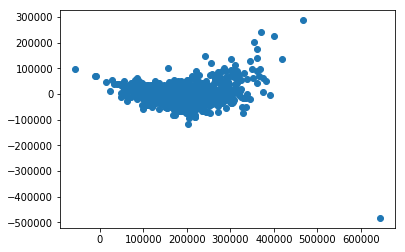

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.799660      14.54     16.313704  1.773704       35666          47562
1  0.760107      15.04     13.610306  1.429694       39223          32827
2  0.764013      14.49     15.223742  0.733742       38437          36364
3  0.757311      14.53     14.913083  0.383083       39157          33028
4  0.775405      14.72     14.243796  0.476204       36949          41960
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000   5.000000      5.000000  5.000000      5.000000   
mean   0.771299  14.664000     14.860926  0.959286  37886.400000   
std    0.017286   0.228101      1.023453  0.612537   1542.155894   
min    0.757311  14.490000     13.610306  0.383083  35666.000000   
25%    0.760107  14.530000     14.243796  0.476204  36949.000000   
50%    0.764013  14.540000     14.913083  0.733742  38437.000000   
75%    0.775405  14.720000     15.223742  1.429694  39157.000000   
max    0.799

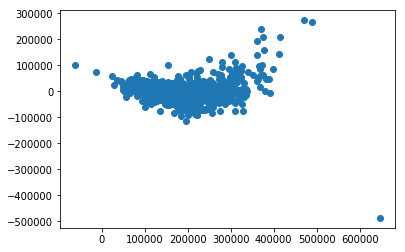

               0
375 -9691.412878
636 -8136.312190


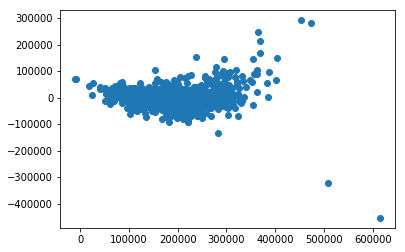

                0
375  -9604.570912
533 -54838.750957
636  -7089.783136


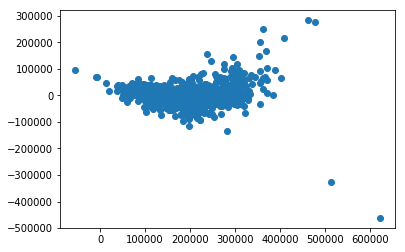

                0
533 -60791.263827
636  -8857.270198


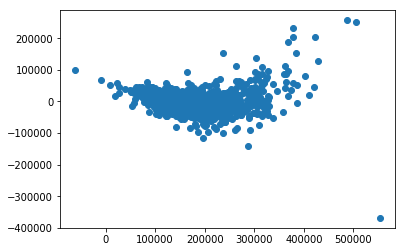

                0
375 -10296.904515
533 -49934.515319
636  -6479.720916


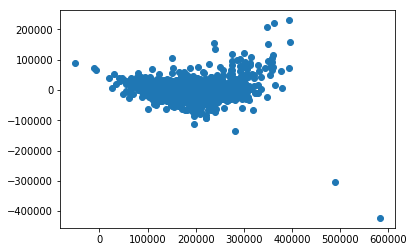

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.781971      14.74     15.806744  1.066744       37855          37477
1  0.760527      14.76     14.022707  0.737293       38463          34866
2  0.766168      15.04     13.377017  1.662983       38928          32709
3  0.793910      14.65     15.813351  1.163351       36191          45317
4  0.772039      14.46     15.012292  0.552292       36398          43607
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000       5.00      5.000000  5.000000      5.000000   
mean   0.774923      14.73     14.806422  1.036533  37567.000000   
std    0.013251       0.21      1.085627  0.428214   1224.542568   
min    0.760527      14.46     13.377017  0.552292  36191.000000   
25%    0.766168      14.65     14.022707  0.737293  36398.000000   
50%    0.772039      14.74     15.012292  1.066744  37855.000000   
75%    0.781971      14.76     15.806744  1.163351  38463.000000   
max    0.793

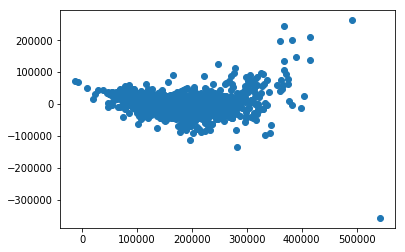

                0
375 -16994.559129
533 -58371.648333
636 -12746.160144


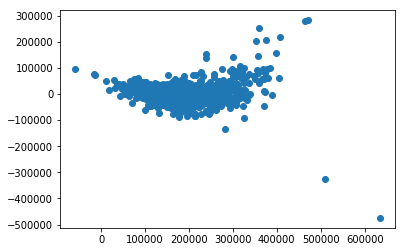

                0
533 -46337.812136
636  -4266.592536


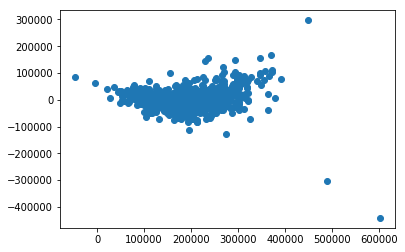

                0
375 -12151.211964
533 -57939.074836
636 -12247.353739


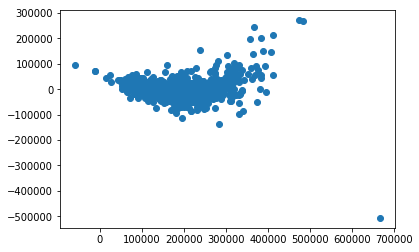

                0
375 -12598.989750
533 -55798.775486


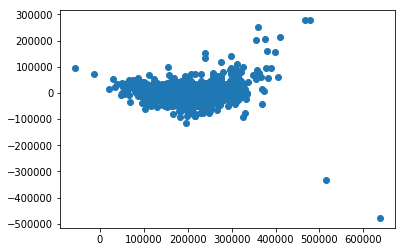

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.799885      14.43     14.508460  0.078460       35127          47097
1  0.773328      14.81     13.617400  1.192600       39070          30574
2  0.769261      14.01     14.826823  0.816823       35660          45038
3  0.778191      14.50     14.987570  0.487570       38061          35414
4  0.766596      14.43     15.202965  0.772965       38712          32386
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000   5.000000      5.000000  5.000000      5.000000   
mean   0.777452  14.436000     14.628644  0.669684  37326.000000   
std    0.013283   0.285272      0.619477  0.414870   1810.656925   
min    0.766596  14.010000     13.617400  0.078460  35127.000000   
25%    0.769261  14.430000     14.508460  0.487570  35660.000000   
50%    0.773328  14.430000     14.826823  0.772965  38061.000000   
75%    0.778191  14.500000     14.987570  0.816823  38712.000000   
max    0.799

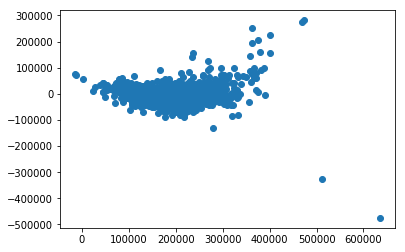

                0
375  -8779.245097
533 -52059.611193
636  -9548.199139


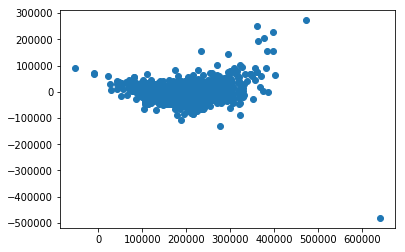

               0
533 -56580.15656


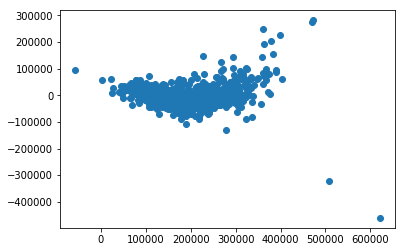

                0
375  -6469.882027
533 -47565.958042
636  -6206.215402


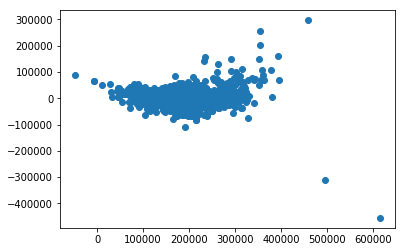

                 0
375   -6560.879272
533  -60295.698613
636  -12864.530030
1100  -2485.040111


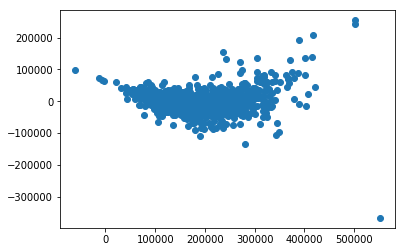

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.771511      14.43     13.745785  0.684215       38577          29801
1  0.785953      14.07     14.639080  0.569080       36014          40598
2  0.776118      14.43     14.664895  0.234895       38356          31190
3  0.770567      13.88     13.873608  0.006392       36114          40882
4  0.812472      14.40     14.790672  0.390672       34937          46045
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000   5.000000      5.000000  5.000000      5.000000   
mean   0.783324  14.242000     14.342808  0.377051  36799.600000   
std    0.017398   0.253121      0.492109  0.268797   1592.013285   
min    0.770567  13.880000     13.745785  0.006392  34937.000000   
25%    0.771511  14.070000     13.873608  0.234895  36014.000000   
50%    0.776118  14.400000     14.639080  0.390672  36114.000000   
75%    0.785953  14.430000     14.664895  0.569080  38356.000000   
max    0.812

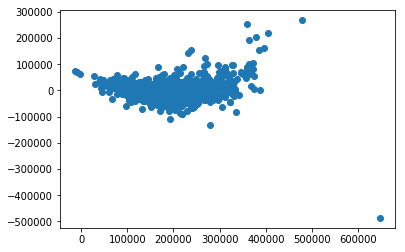

                0
375  -8088.567328
533 -44349.307867
636  -4595.661960


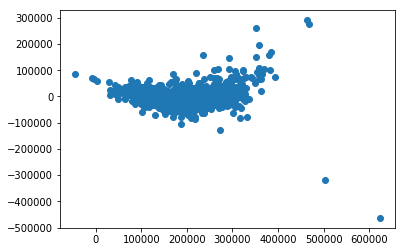

                0
533  -53080.93833
1100  -5396.48412


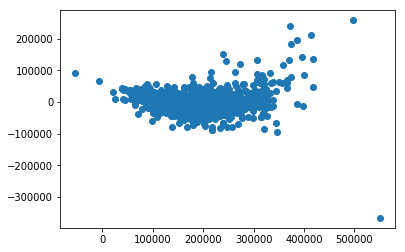

                0
375  -8812.467837
533 -46894.414747
636  -6365.608913


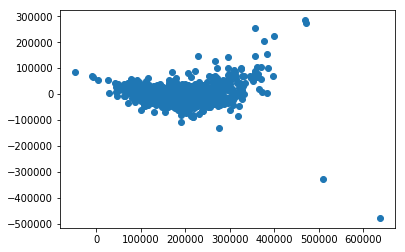

                0
375  -5395.457779
533 -43081.674472
636  -2012.953383


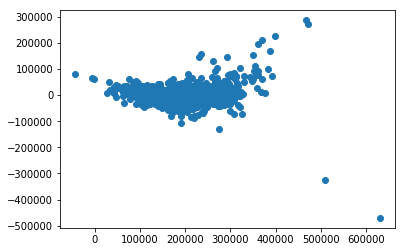

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.788087      13.98     14.041824  0.061824       36513          37785
1  0.778286      14.13     12.274176  1.855824       37581          33632
2  0.811524      13.45     16.300206  2.850206       33925          48186
3  0.774211      13.98     13.152522  0.827478       37869          32031
4  0.777786      13.48     14.330120  0.850120       37109          35634
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000   5.000000      5.000000  5.000000      5.000000   
mean   0.785979  13.804000     14.019769  1.289090  36599.400000   
std    0.015180   0.315642      1.508013  1.080536   1580.743116   
min    0.774211  13.450000     12.274176  0.061824  33925.000000   
25%    0.777786  13.480000     13.152522  0.827478  36513.000000   
50%    0.778286  13.980000     14.041824  0.850120  37109.000000   
75%    0.788087  13.980000     14.330120  1.855824  37581.000000   
max    0.811

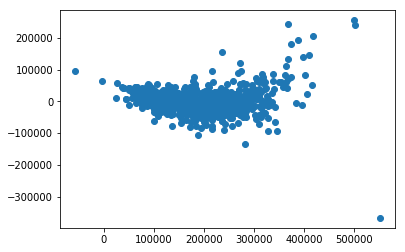

                0
375  -5957.267626
533 -49607.108808


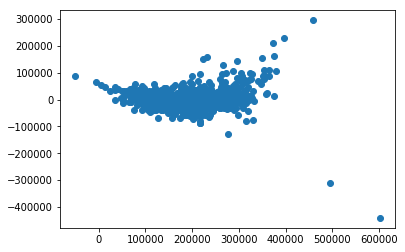

               0
375 -8357.538728
636   -98.253732


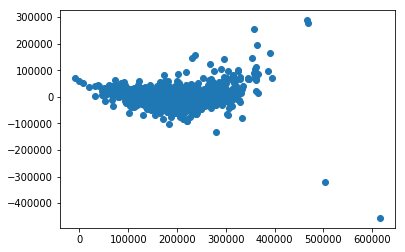

                0
375  -8643.943683
533 -58900.536445
636  -1218.427557


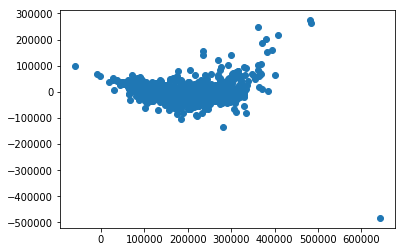

                0
375  -6999.680302
533 -53052.902459
636     -2.685101


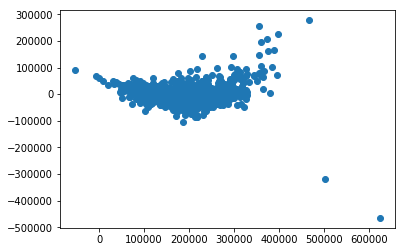

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.811792      13.71     15.445625  1.735625       34750          45337
1  0.777875      13.52     14.641170  1.121170       35948          39927
2  0.775011      14.05     13.638691  0.411309       37557          32937
3  0.792793      14.20     14.097636  0.102364       37025          35192
4  0.777653      14.12     12.560453  1.559547       37038          35099
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000    5.00000      5.000000  5.000000      5.000000   
mean   0.787024   13.92000     14.076715  0.986003  36463.600000   
std    0.015513    0.29129      1.082113  0.710677   1122.819799   
min    0.775011   13.52000     12.560453  0.102364  34750.000000   
25%    0.777653   13.71000     13.638691  0.411309  35948.000000   
50%    0.777875   14.05000     14.097636  1.121170  37025.000000   
75%    0.792793   14.12000     14.641170  1.559547  37038.000000   
max    0.811

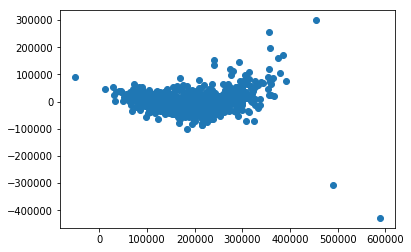

                0
375  -2566.412119
533 -50636.704744


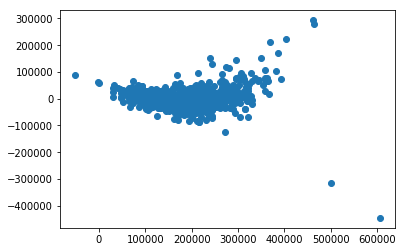

                0
375  -6949.186149
533 -59965.878899
636  -5417.945168


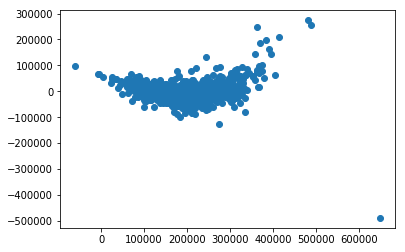

               0
375 -8885.574263
636 -4996.296361


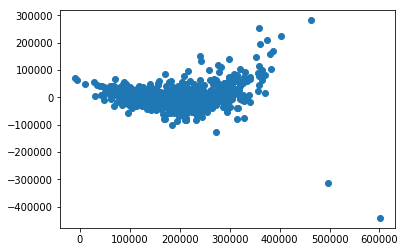

                 0
533  -53213.359179
636   -4859.965579
1100  -1047.185929


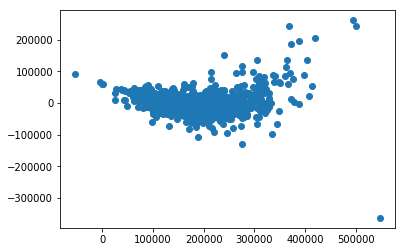

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.786369      13.70     14.160913  0.460913       35779          39349
1  0.782675      13.69     13.943872  0.253872       36476          36419
2  0.797105      14.29     13.850919  0.439081       36517          36355
3  0.772577      14.13     13.398354  0.731646       37801          30511
4  0.811539      13.56     15.261397  1.701397       34421          45494
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000   5.000000      5.000000  5.000000      5.000000   
mean   0.790053  13.874000     14.123091  0.717382  36198.800000   
std    0.014873   0.316749      0.694372  0.575882   1233.079559   
min    0.772577  13.560000     13.398354  0.253872  34421.000000   
25%    0.782675  13.690000     13.850919  0.439081  35779.000000   
50%    0.786369  13.700000     13.943872  0.460913  36476.000000   
75%    0.797105  14.130000     14.160913  0.731646  36517.000000   
max    0.811

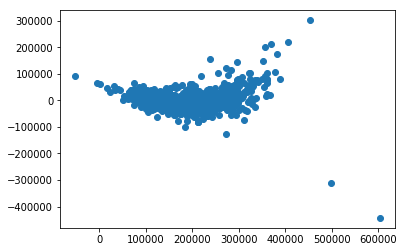

                0
375  -5465.098643
533 -56097.511318
636  -2719.549967


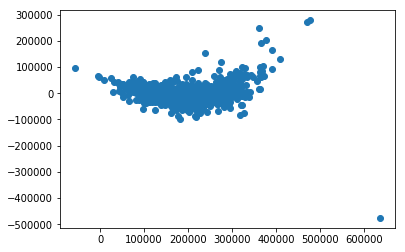

                0
375  -6339.146055
533 -52829.728077
636  -3925.134905


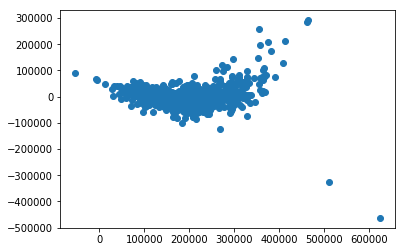

                0
636  -6864.322638
1100 -1000.829991


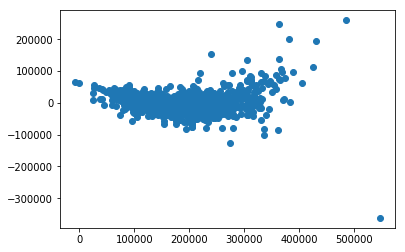

                0
375  -5210.171545
533 -54911.575141


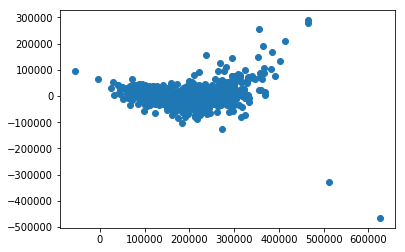

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.786944      13.32     13.939124  0.619124       35823          36715
1  0.801862      13.83     13.505902  0.324098       35369          38210
2  0.780546      13.94     11.700874  2.239126       37540          28690
3  0.828685      12.73     16.349198  3.619198       32501          48786
4  0.778945      13.68     13.171006  0.508994       37351          29487
          adjr2  train_err  validate_err  diff_err   train_rmse  validate_rmse
count  5.000000   5.000000      5.000000  5.000000      5.00000       5.000000
mean   0.795397  13.500000     13.733221  1.462108  35716.80000   36377.600000
std    0.020692   0.489949      1.687004  1.429240   2029.05648    8124.338145
min    0.778945  12.730000     11.700874  0.324098  32501.00000   28690.000000
25%    0.780546  13.320000     13.171006  0.508994  35369.00000   29487.000000
50%    0.786944  13.680000     13.505902  0.619124  35823.00000   36715.000000
75%

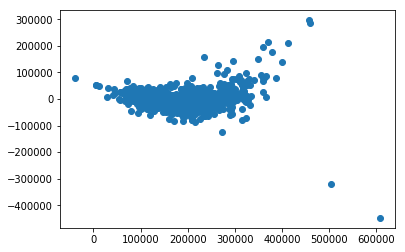

Empty DataFrame
Columns: [0]
Index: []


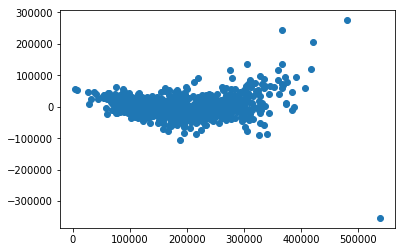

                0
533 -41469.134189


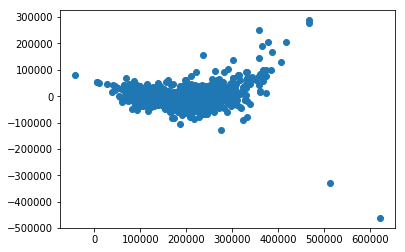

                0
533 -35943.877359


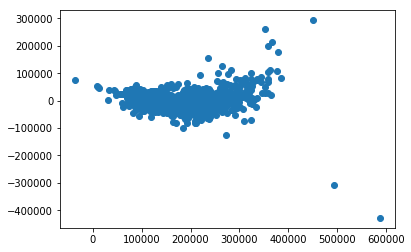

                0
533 -45155.884755


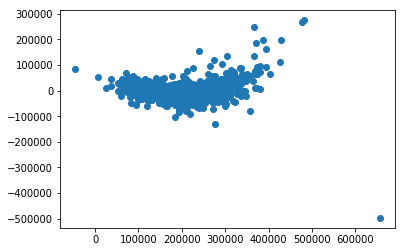

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.779672      13.36     13.267069  0.092931       36336          33569
1  0.830811      12.73     15.932632  3.202632       31757          49654
2  0.783300      13.96     12.845207  1.114793       37706          26633
3  0.787866      13.78     11.931359  1.848641       35583          37021
4  0.804742      13.62     14.819718  1.199718       36220          34572
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000   5.000000      5.000000  5.000000      5.000000   
mean   0.797278  13.490000     13.759197  1.491743  35520.400000   
std    0.021060   0.478644      1.602115  1.144395   2241.572506   
min    0.779672  12.730000     11.931359  0.092931  31757.000000   
25%    0.783300  13.360000     12.845207  1.114793  35583.000000   
50%    0.787866  13.620000     13.267069  1.199718  36220.000000   
75%    0.804742  13.780000     14.819718  1.848641  36336.000000   
max    0.830

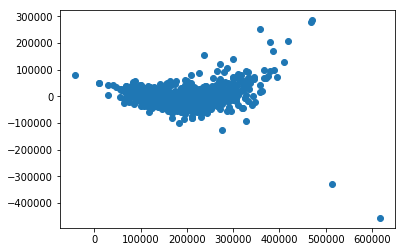

                0
533 -41074.582305


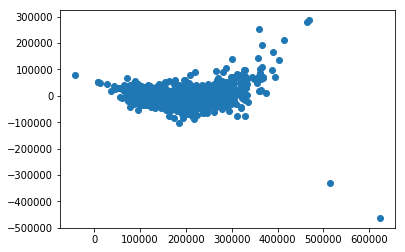

                 0
533  -44038.141408
1100  -2004.362834


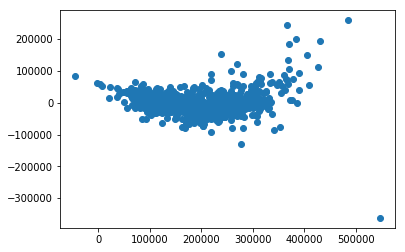

                0
533 -37109.889713


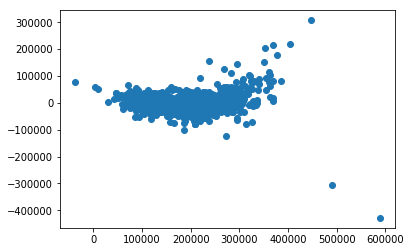

Empty DataFrame
Columns: [0]
Index: []


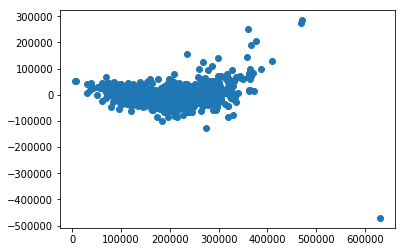

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.785593      13.56     14.564614  1.004614       36881          31028
1  0.789116      13.79     12.659794  1.130206       36977          30484
2  0.827804      13.15     14.900315  1.750315       32993          46897
3  0.785723      13.42     13.032671  0.387329       35203          38736
4  0.796433      13.57     13.569898  0.000102       35653          36143
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000   5.000000      5.000000  5.000000      5.000000   
mean   0.796934  13.498000     13.745458  0.854513  35541.400000   
std    0.017809   0.235308      0.964658  0.679941   1618.393277   
min    0.785593  13.150000     12.659794  0.000102  32993.000000   
25%    0.785723  13.420000     13.032671  0.387329  35203.000000   
50%    0.789116  13.560000     13.569898  1.004614  35653.000000   
75%    0.796433  13.570000     14.564614  1.130206  36881.000000   
max    0.827

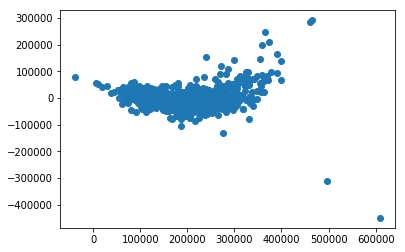

                0
533 -33853.555432


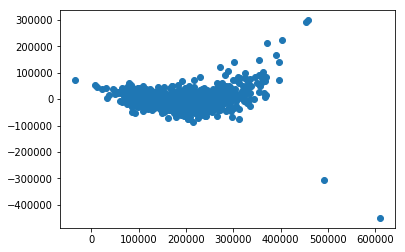

                0
533 -34993.095747


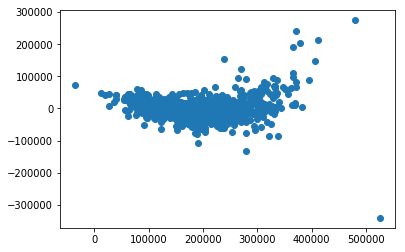

                0
533 -37069.993049


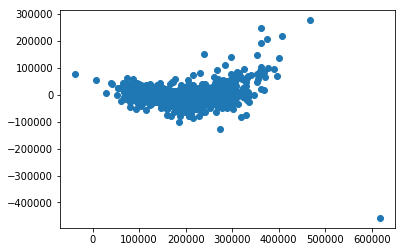

Empty DataFrame
Columns: [0]
Index: []


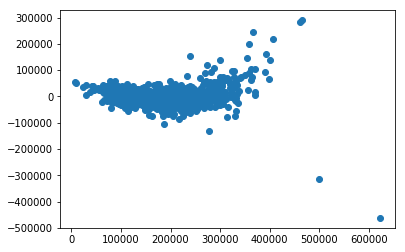

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.787204      13.66     13.342854  0.317146       36953          28631
1  0.796019      13.42     12.822389  0.597611       35521          35260
2  0.825913      12.88     14.909093  2.029093       32561          46055
3  0.802392      13.37     14.013807  0.643807       34648          38568
4  0.788843      13.58     12.898102  0.681898       36710          29731
          adjr2  train_err  validate_err  diff_err   train_rmse  validate_rmse
count  5.000000   5.000000      5.000000  5.000000      5.00000        5.00000
mean   0.800074  13.382000     13.597249  0.853911  35278.60000    35649.00000
std    0.015662   0.304171      0.872981  0.672419   1781.45202     7092.80914
min    0.787204  12.880000     12.822389  0.317146  32561.00000    28631.00000
25%    0.788843  13.370000     12.898102  0.597611  34648.00000    29731.00000
50%    0.796019  13.420000     13.342854  0.643807  35521.00000    35260.00000
75%

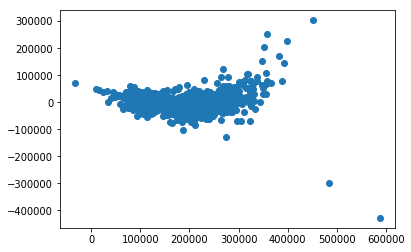

                0
533 -28721.535938


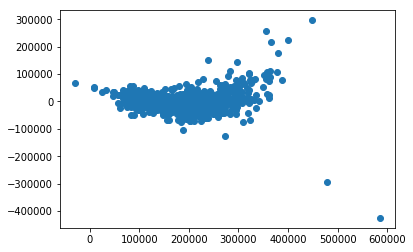

Empty DataFrame
Columns: [0]
Index: []


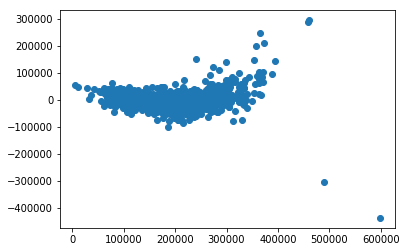

                0
533 -38486.149125


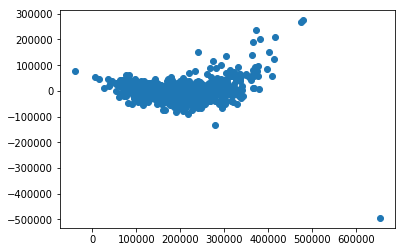

                 0
533  -43401.583300
1100  -2904.581687


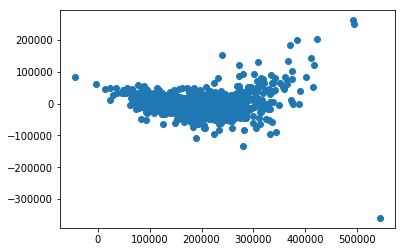

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.792482      13.36     12.674050  0.685950       35125          37222
1  0.789109      13.29     13.110899  0.179101       35025          37670
2  0.794150      13.18     15.326868  2.146868       35898          33758
3  0.803840      13.85     13.045719  0.804281       36065          33234
4  0.823379      13.29     14.494758  1.204758       33785          43834
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000   5.000000      5.000000  5.000000      5.000000   
mean   0.800592  13.394000     13.730459  1.004192  35179.600000   
std    0.013865   0.262926      1.129314  0.736199    904.409089   
min    0.789109  13.180000     12.674050  0.179101  33785.000000   
25%    0.792482  13.290000     13.045719  0.685950  35025.000000   
50%    0.794150  13.290000     13.110899  0.804281  35125.000000   
75%    0.803840  13.360000     14.494758  1.204758  35898.000000   
max    0.823

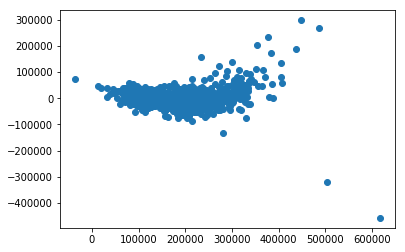

                0
533 -34183.338119


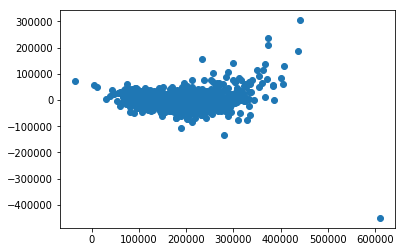

                0
533 -36153.962361


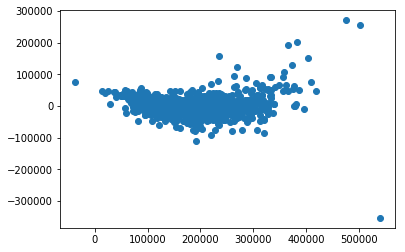

                0
533 -27814.887527


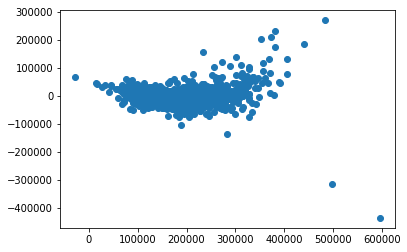

Empty DataFrame
Columns: [0]
Index: []


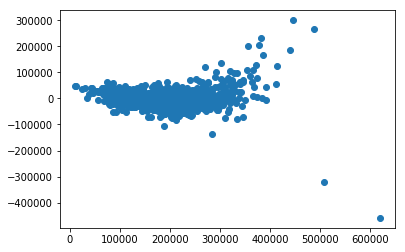

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.793226      13.41     13.413970  0.003970       36103          30672
1  0.803638      13.44     12.771469  0.668531       33943          39396
2  0.835329      12.90     14.555681  1.655681       31764          47550
3  0.798227      13.53     13.395798  0.134202       35636          33078
4  0.791029      13.49     13.759423  0.269423       36869          26741
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000   5.000000      5.000000  5.000000      5.000000   
mean   0.804290  13.354000     13.579268  0.546361  34863.000000   
std    0.018020   0.257934      0.651798  0.668258   2037.729496   
min    0.791029  12.900000     12.771469  0.003970  31764.000000   
25%    0.793226  13.410000     13.395798  0.134202  33943.000000   
50%    0.798227  13.440000     13.413970  0.269423  35636.000000   
75%    0.803638  13.490000     13.759423  0.668531  36103.000000   
max    0.835

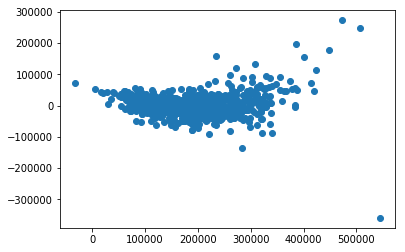

                0
533 -28421.400516


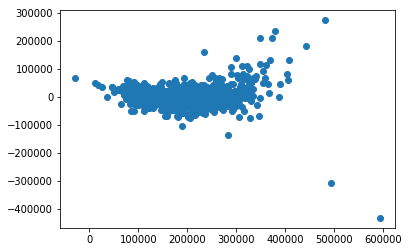

                0
533 -32712.521614


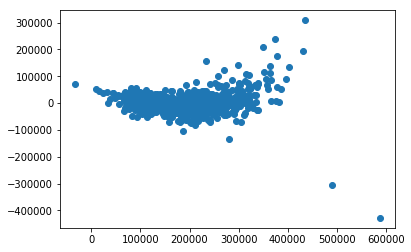

Empty DataFrame
Columns: [0]
Index: []


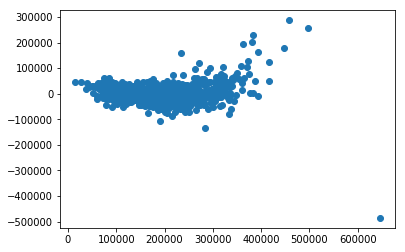

                0
533 -33919.590319


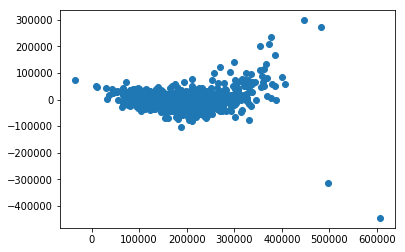

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.831625      13.09     13.478293  0.388293       32270          46612
1  0.798028      13.40     13.769739  0.369739       35143          35250
2  0.793216      13.91     11.552241  2.357759       35769          32562
3  0.801039      13.31     14.735035  1.425035       35329          34231
4  0.798340      13.14     14.905192  1.765192       35675          32747
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000   5.000000      5.000000  5.000000      5.000000   
mean   0.804450  13.370000     13.688100  1.261204  34837.200000   
std    0.015451   0.326879      1.340705  0.871774   1457.399808   
min    0.793216  13.090000     11.552241  0.369739  32270.000000   
25%    0.798028  13.140000     13.478293  0.388293  35143.000000   
50%    0.798340  13.310000     13.769739  1.425035  35329.000000   
75%    0.801039  13.400000     14.735035  1.765192  35675.000000   
max    0.831

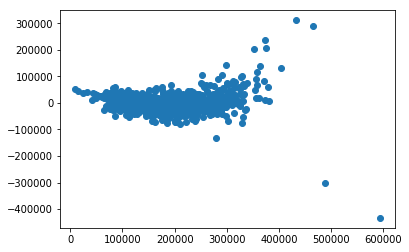

               0
533 -34314.45203


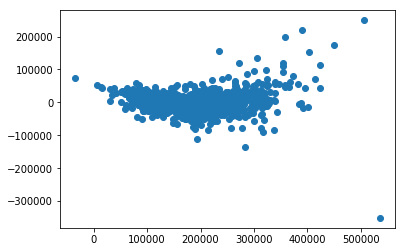

                0
533 -39396.402617


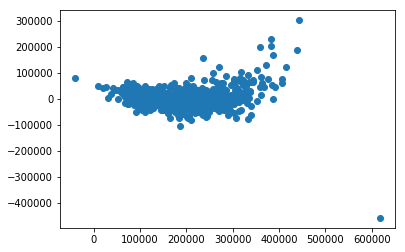

                0
533 -35134.406973


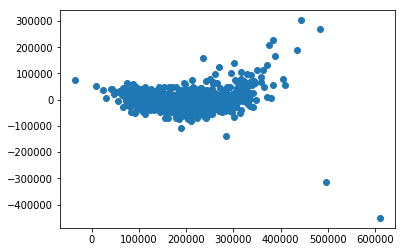

                0
533 -34351.573111


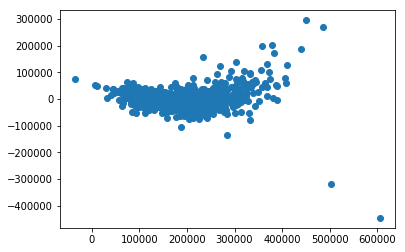

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.790243      13.01     13.673348  0.663348       35279          34557
1  0.833118      12.86     14.573794  1.713794       31772          47587
2  0.810894      13.47     13.547643  0.077643       34461          37372
3  0.790264      13.69     12.898266  0.791734       36394          29394
4  0.796209      13.75     13.539254  0.210746       36307          29927
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000   5.000000      5.000000  5.000000      5.000000   
mean   0.804146  13.356000     13.646461  0.691453  34842.600000   
std    0.018261   0.401721      0.600359  0.644955   1891.821688   
min    0.790243  12.860000     12.898266  0.077643  31772.000000   
25%    0.790264  13.010000     13.539254  0.210746  34461.000000   
50%    0.796209  13.470000     13.547643  0.663348  35279.000000   
75%    0.810894  13.690000     13.673348  0.791734  36307.000000   
max    0.833

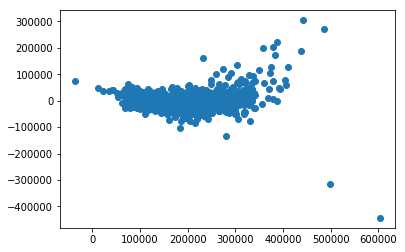

                0
533 -36020.495093


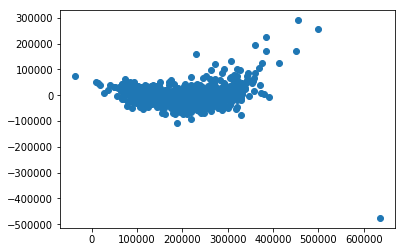

                0
533 -37668.297949


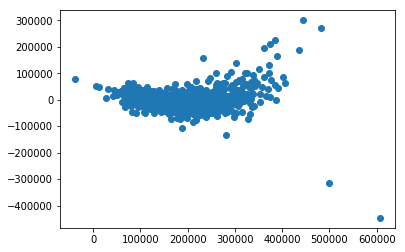

                0
533 -34035.701054


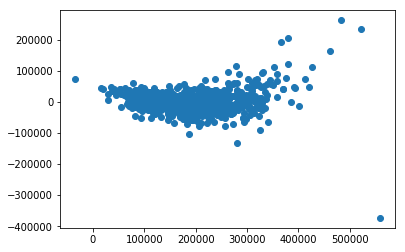

Empty DataFrame
Columns: [0]
Index: []


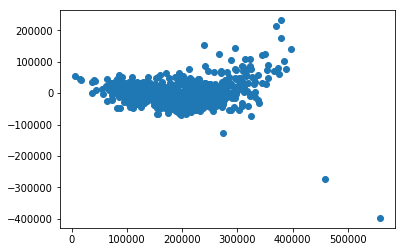

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.795190      13.37     14.304351  0.934351       36475          28526
1  0.807131      13.57     13.113646  0.456354       35041          34879
2  0.792122      13.79     13.089602  0.700398       36831          26707
3  0.833787      12.99     14.333186  1.343186       31901          47641
4  0.801810      12.87     13.930072  1.060072       33014          43743
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000   5.000000      5.000000  5.000000      5.000000   
mean   0.806008  13.318000     13.754171  0.898872  34652.400000   
std    0.016586   0.386419      0.616608  0.339070   2149.054164   
min    0.792122  12.870000     13.089602  0.456354  31901.000000   
25%    0.795190  12.990000     13.113646  0.700398  33014.000000   
50%    0.801810  13.370000     13.930072  0.934351  35041.000000   
75%    0.807131  13.570000     14.304351  1.060072  36475.000000   
max    0.833

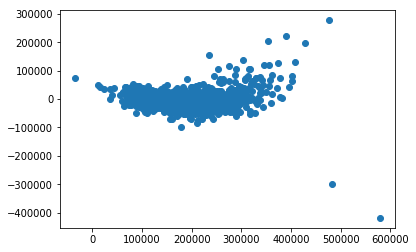

Empty DataFrame
Columns: [0]
Index: []


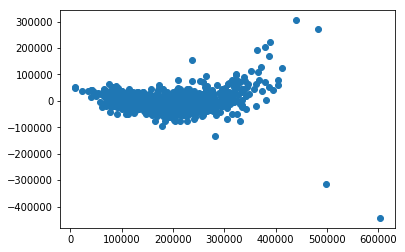

                0
533 -36902.285886


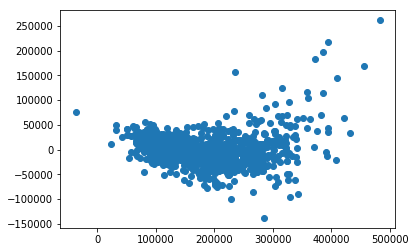

                0
533 -25283.192839


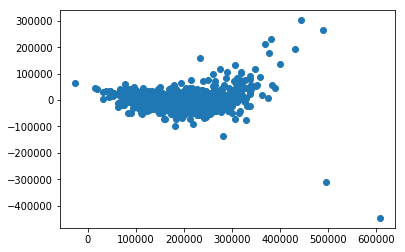

                0
533 -30792.350455


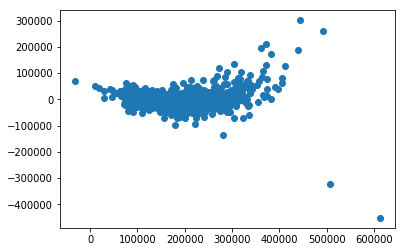

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.808543      13.35     13.347104  0.002896       34369          37273
1  0.797303      13.42     13.425118  0.005118       35994          30062
2  0.843630      12.74     15.780333  3.040333       30572          51734
3  0.788642      13.38     12.568498  0.811502       35983          30272
4  0.799376      13.35     13.163792  0.186208       35625          31723
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000    5.00000      5.000000  5.000000      5.000000   
mean   0.807499   13.24800     13.656969  0.809211  34508.600000   
std    0.021401    0.28543      1.233535  1.290615   2299.071834   
min    0.788642   12.74000     12.568498  0.002896  30572.000000   
25%    0.797303   13.35000     13.163792  0.005118  34369.000000   
50%    0.799376   13.35000     13.347104  0.186208  35625.000000   
75%    0.808543   13.38000     13.425118  0.811502  35983.000000   
max    0.843

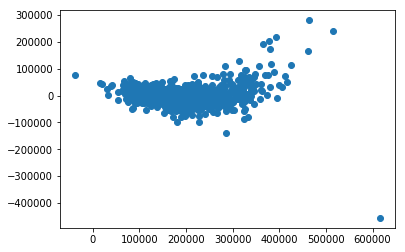

                0
533 -30518.214482


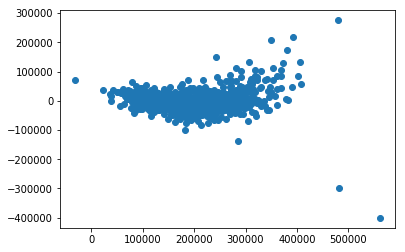

                0
533 -28570.022434


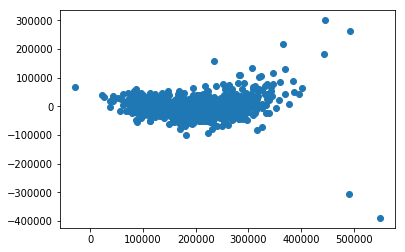

Empty DataFrame
Columns: [0]
Index: []


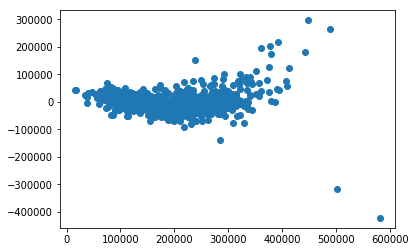

               0
533 -35110.09265


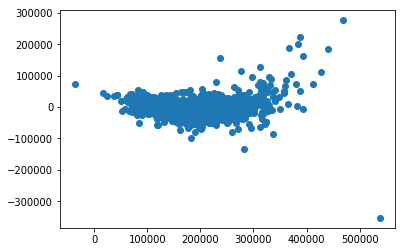

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.816012      13.58     13.251889  0.328111       34874          33404
1  0.807535      13.16     13.295326  0.135326       34212          36209
2  0.802755      13.57     12.197775  1.372225       34413          35490
3  0.800669      12.94     14.718006  1.778006       35628          29700
4  0.826904      12.58     14.284985  1.704985       31950          44818
          adjr2  train_err  validate_err  diff_err   train_rmse  validate_rmse
count  5.000000   5.000000      5.000000  5.000000      5.00000       5.000000
mean   0.810775  13.166000     13.549596  1.063731  34215.40000   35924.200000
std    0.010776   0.426943      0.985734  0.777759   1378.43092    5578.113319
min    0.800669  12.580000     12.197775  0.135326  31950.00000   29700.000000
25%    0.802755  12.940000     13.251889  0.328111  34212.00000   33404.000000
50%    0.807535  13.160000     13.295326  1.372225  34413.00000   35490.000000
75%

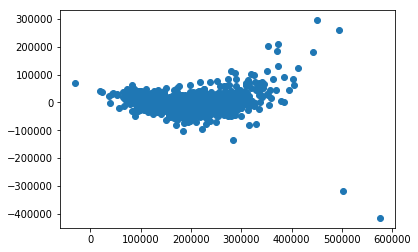

                0
533 -34429.542989


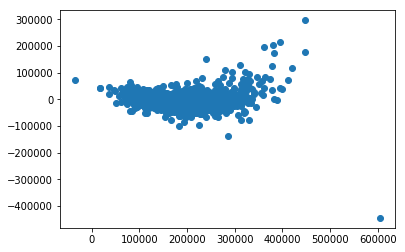

                0
533 -34858.350415


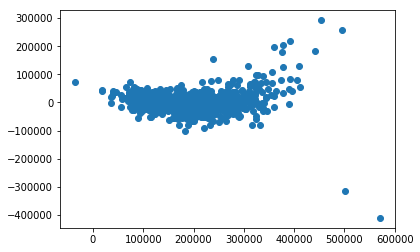

               0
533 -35539.04779


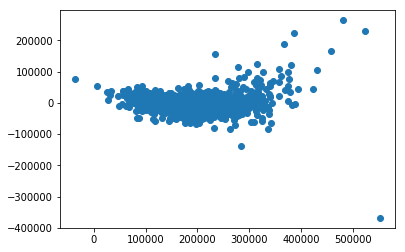

Empty DataFrame
Columns: [0]
Index: []


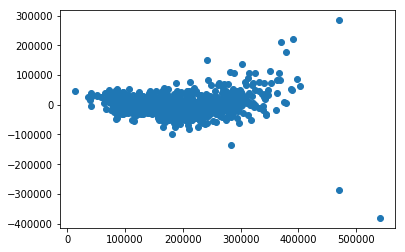

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.798551      13.20     13.115155  0.084845       35396          30706
1  0.811717      13.26     12.851080  0.408920       34111          36051
2  0.801210      13.74     12.664367  1.075633       36064          27594
3  0.837843      12.63     15.421783  2.791783       31898          45727
4  0.804428      13.05     13.688923  0.638923       33450          39550
          adjr2  train_err  validate_err  diff_err   train_rmse  validate_rmse
count  5.000000   5.000000      5.000000  5.000000      5.00000       5.000000
mean   0.810750  13.176000     13.548261  1.000021  34183.80000   35925.600000
std    0.015927   0.399912      1.116331  1.064597   1641.12955    7174.246044
min    0.798551  12.630000     12.664367  0.084845  31898.00000   27594.000000
25%    0.801210  13.050000     12.851080  0.408920  33450.00000   30706.000000
50%    0.804428  13.200000     13.115155  0.638923  34111.00000   36051.000000
75%

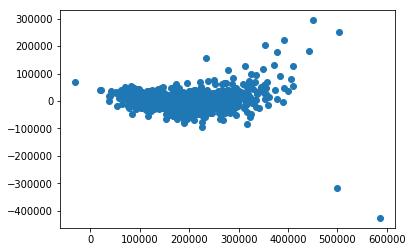

Empty DataFrame
Columns: [0]
Index: []


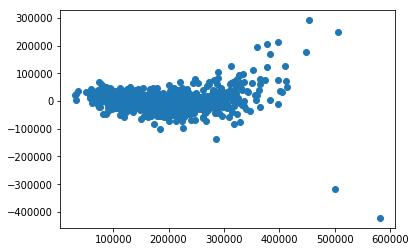

                0
533 -37669.870827


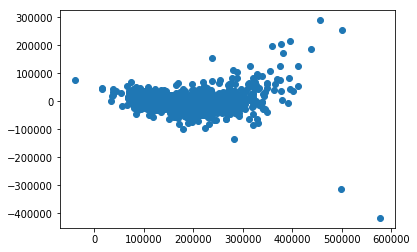

                0
533 -31149.931621


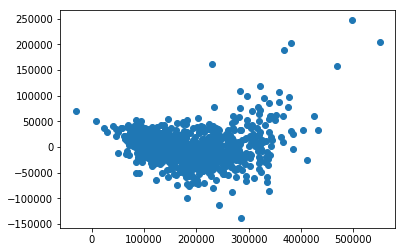

               0
533 -27179.16375


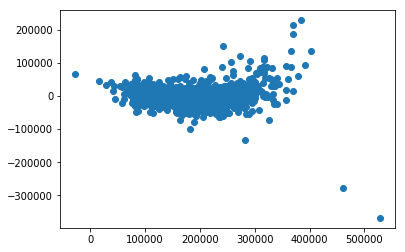

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.805949      13.15     13.385804  0.235804       35081          31788
1  0.802515      13.30     14.800958  1.500958       35761          29035
2  0.797986      13.70     12.908064  0.791936       36498          24988
3  0.846628      13.16     13.760381  0.600381       30293          51401
4  0.810043      12.91     12.683165  0.226835       32350          44115
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000   5.000000      5.000000  5.000000      5.000000   
mean   0.812624  13.244000     13.507674  0.671183  33996.600000   
std    0.019519   0.290912      0.835261  0.523240   2596.823887   
min    0.797986  12.910000     12.683165  0.226835  30293.000000   
25%    0.802515  13.150000     12.908064  0.235804  32350.000000   
50%    0.805949  13.160000     13.385804  0.600381  35081.000000   
75%    0.810043  13.300000     13.760381  0.791936  35761.000000   
max    0.846

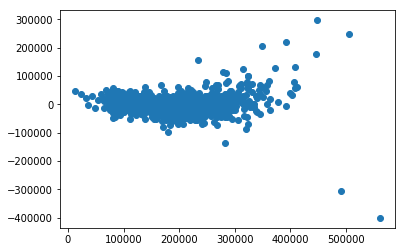

                0
533 -32598.487673


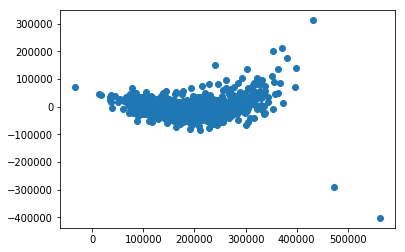

                0
533 -34384.184585


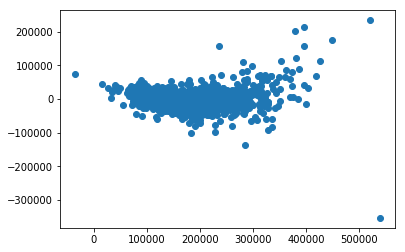

                0
533 -31872.060679


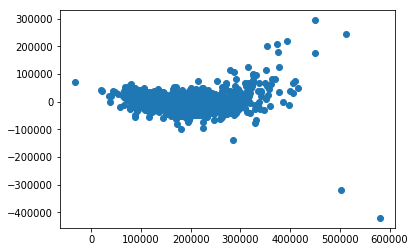

                0
533 -37176.669808


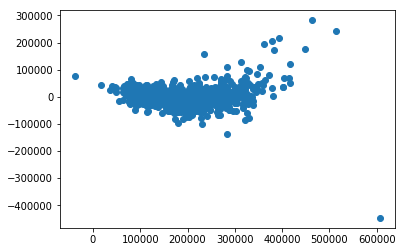

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.807154      13.06     14.499384  1.439384       34815          33251
1  0.799698      13.00     12.530031  0.469969       33991          37554
2  0.837362      12.55     14.458085  1.908085       31276          46364
3  0.801971      13.56     12.653031  0.906969       35785          28517
4  0.810380      13.34     13.170062  0.169938       34699          33335
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000   5.000000      5.000000  5.000000      5.000000   
mean   0.811313  13.102000     13.462118  0.978869  34113.200000   
std    0.015157   0.381864      0.958720  0.706051   1709.914969   
min    0.799698  12.550000     12.530031  0.169938  31276.000000   
25%    0.801971  13.000000     12.653031  0.469969  33991.000000   
50%    0.807154  13.060000     13.170062  0.906969  34699.000000   
75%    0.810380  13.340000     14.458085  1.439384  34815.000000   
max    0.837

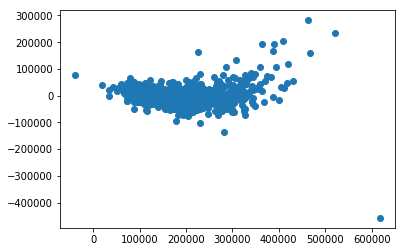

                0
533 -30253.279409


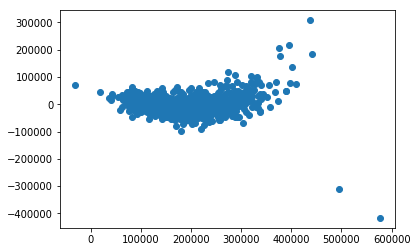

                0
533 -37022.604718


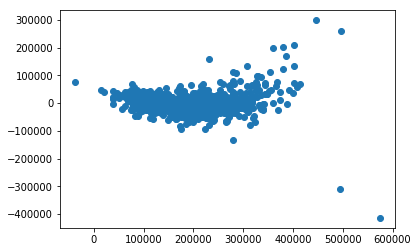

                0
533 -28908.072405


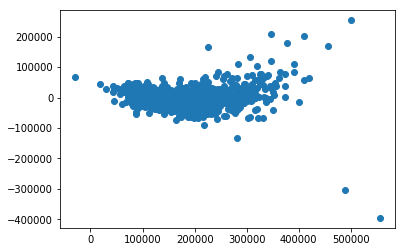

Empty DataFrame
Columns: [0]
Index: []


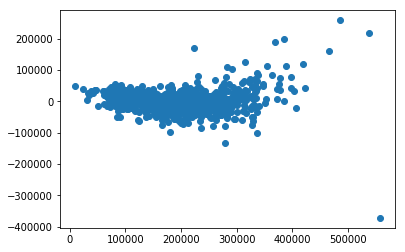

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.819073      12.95     14.657800  1.707800       34181          34787
1  0.804568      12.69     13.467542  0.777542       33736          36404
2  0.801368      13.61     11.659682  1.950318       35787          27422
3  0.809226      13.14     13.533064  0.393064       33655          37673
4  0.833522      12.69     13.434429  0.744429       32105          43869
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000   5.000000      5.000000  5.000000      5.000000   
mean   0.813552  13.016000     13.350503  1.114630  33892.800000   
std    0.013011   0.382466      1.074938  0.674826   1317.992489   
min    0.801368  12.690000     11.659682  0.393064  32105.000000   
25%    0.804568  12.690000     13.434429  0.744429  33655.000000   
50%    0.809226  12.950000     13.467542  0.777542  33736.000000   
75%    0.819073  13.140000     13.533064  1.707800  34181.000000   
max    0.833

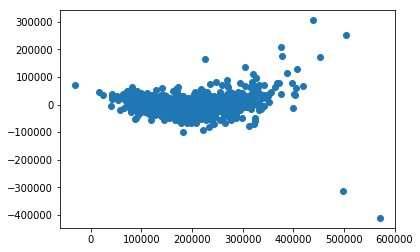

Empty DataFrame
Columns: [0]
Index: []


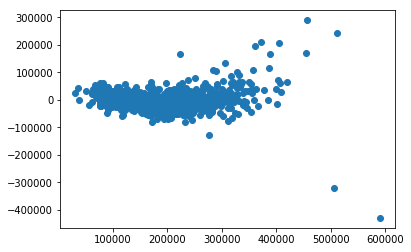

                0
533 -31047.876095


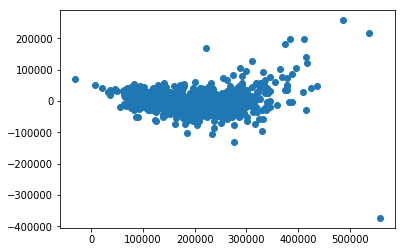

                0
533 -31190.285833


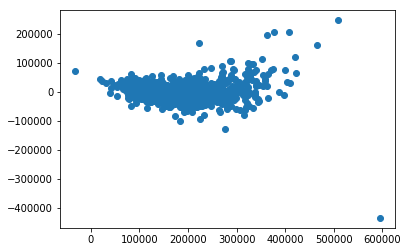

                0
533 -25399.151007


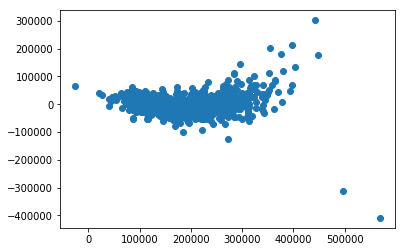

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.809939      13.12     13.139944  0.019944       34334          33509
1  0.805425      12.84     14.661551  1.821551       35186          29584
2  0.831085      12.97     12.795127  0.174873       32708          42382
3  0.823613      12.77     13.814047  1.044047       32812          39055
4  0.800876      13.07     12.381861  0.688139       34063          34758
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000   5.000000      5.000000  5.000000      5.000000   
mean   0.814188  12.954000     13.358506  0.749711  33820.600000   
std    0.012712   0.148425      0.897837  0.724960   1053.779768   
min    0.800876  12.770000     12.381861  0.019944  32708.000000   
25%    0.805425  12.840000     12.795127  0.174873  32812.000000   
50%    0.809939  12.970000     13.139944  0.688139  34063.000000   
75%    0.823613  13.070000     13.814047  1.044047  34334.000000   
max    0.831

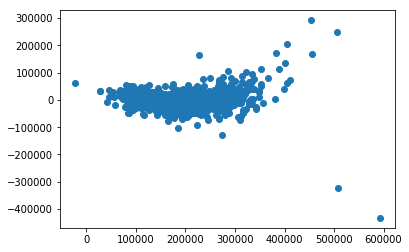

Empty DataFrame
Columns: [0]
Index: []


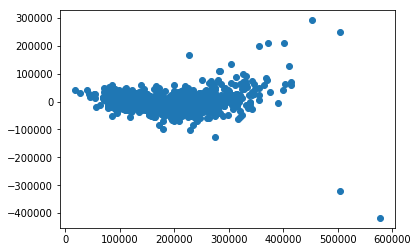

               0
533 -30552.55892


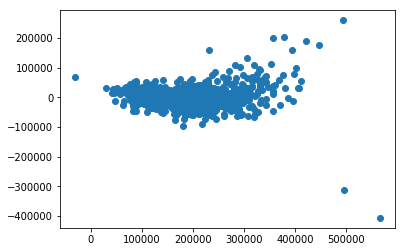

                0
533 -25249.526888


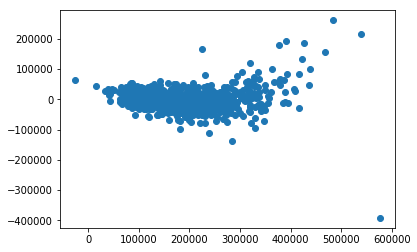

                0
533 -29758.489555


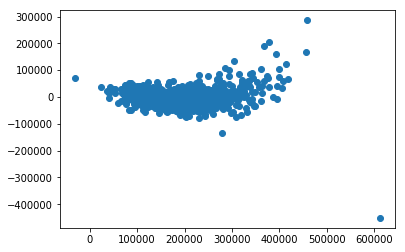

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.807316      12.93     12.764192  0.165808       34393          32945
1  0.798413      12.93     13.740782  0.810782       34749          31356
2  0.807429      13.36     12.607383  0.752617       34472          32954
3  0.838546      12.51     14.246688  1.736688       32102          44479
4  0.826343      12.84     13.698046  0.858046       32604          39314
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000   5.000000      5.000000  5.000000      5.000000   
mean   0.815609  12.914000     13.411418  0.864788  33664.000000   
std    0.016376   0.303364      0.698872  0.562211   1217.063474   
min    0.798413  12.510000     12.607383  0.165808  32102.000000   
25%    0.807316  12.840000     12.764192  0.752617  32604.000000   
50%    0.807429  12.930000     13.698046  0.810782  34393.000000   
75%    0.826343  12.930000     13.740782  0.858046  34472.000000   
max    0.838

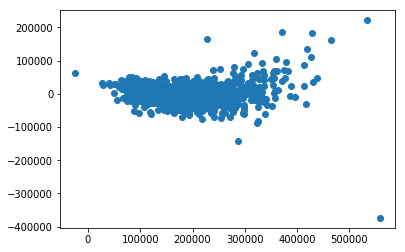

                0
533 -24214.582792


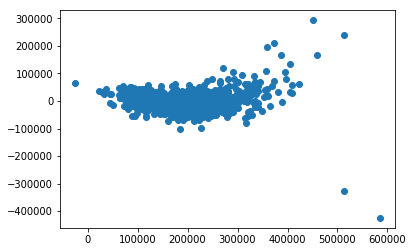

                0
533 -20899.967023


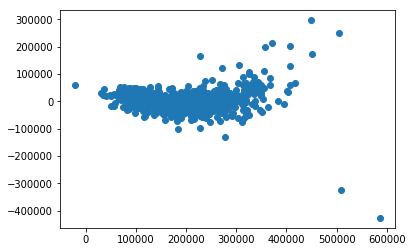

Empty DataFrame
Columns: [0]
Index: []


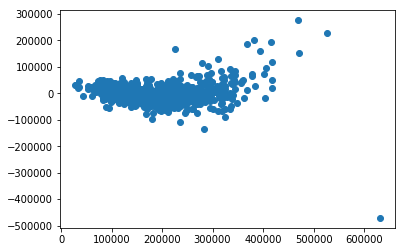

                0
533 -22653.131714


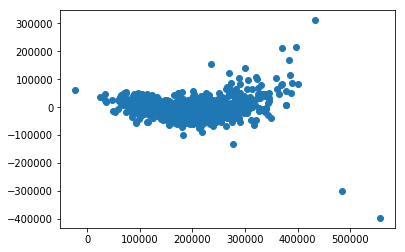

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.850051      12.24     14.383232  2.143232       30448          46970
1  0.809319      13.22     11.900290  1.319710       34448          31388
2  0.801645      12.96     12.236371  0.723629       35176          27816
3  0.816722      12.64     14.215422  1.575422       33921          33840
4  0.809917      12.73     12.918469  0.188469       33358          36794
          adjr2  train_err  validate_err  diff_err   train_rmse  validate_rmse
count  5.000000   5.000000      5.000000  5.000000      5.00000       5.000000
mean   0.817531  12.758000     13.130757  1.190092  33470.20000   35361.600000
std    0.018947   0.366497      1.129627  0.757395   1817.64606    7277.492068
min    0.801645  12.240000     11.900290  0.188469  30448.00000   27816.000000
25%    0.809319  12.640000     12.236371  0.723629  33358.00000   31388.000000
50%    0.809917  12.730000     12.918469  1.319710  33921.00000   33840.000000
75%

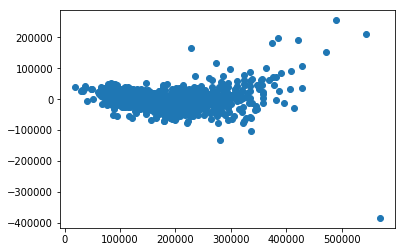

                0
533 -26158.183359


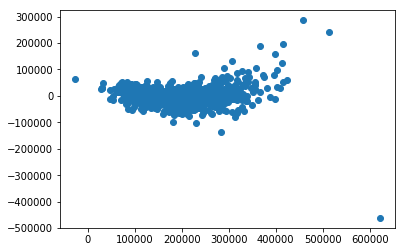

               0
533 -27159.51144


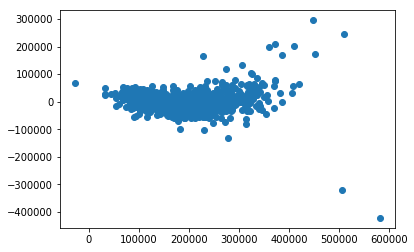

                0
533 -16396.122861


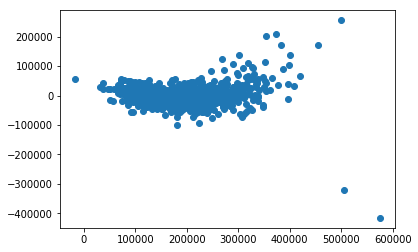

                0
533 -23823.452239


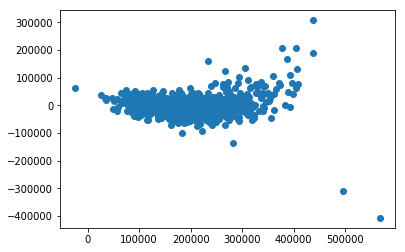

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.839029      12.37     14.519748  2.149748       31829          43453
1  0.821454      13.05     12.122046  0.927954       33460          35279
2  0.802496      13.08     12.286433  0.793567       34955          29025
3  0.814608      12.54     13.593667  1.053667       33214          36600
4  0.808097      12.73     13.563848  0.833848       34068          33317
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000   5.000000      5.000000  5.000000      5.000000   
mean   0.817137  12.754000     13.217148  1.151757  33505.200000   
std    0.014145   0.311336      1.003022  0.566803   1152.730541   
min    0.802496  12.370000     12.122046  0.793567  31829.000000   
25%    0.808097  12.540000     12.286433  0.833848  33214.000000   
50%    0.814608  12.730000     13.563848  0.927954  33460.000000   
75%    0.821454  13.050000     13.593667  1.053667  34068.000000   
max    0.839

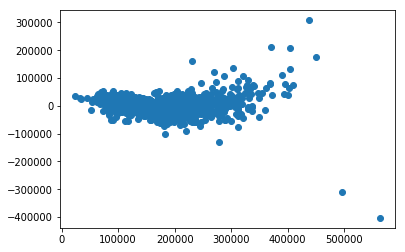

                0
533 -21333.350885


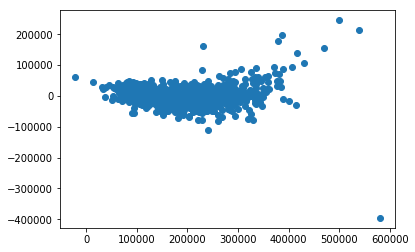

                0
533 -24923.174457


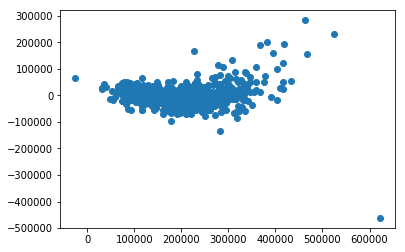

                0
533 -19979.563445


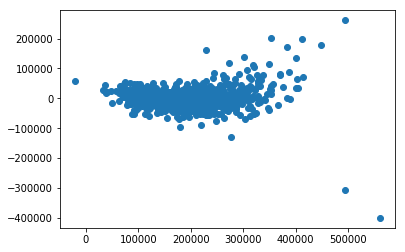

                0
533 -21654.338834


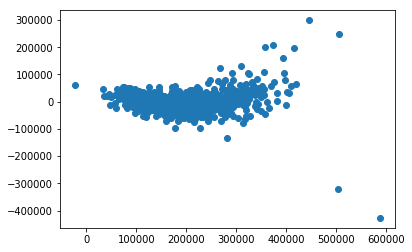

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.803152      12.92     12.280743  0.639257       33805          34270
1  0.849376      12.06     15.485717  3.425717       30774          47450
2  0.816146      13.02     12.387611  0.632389       34118          32798
3  0.811670      12.84     12.564355  0.275645       33516          35577
4  0.808511      12.72     13.754886  1.034886       34803          29602
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000   5.000000      5.000000  5.000000      5.000000   
mean   0.817771  12.712000     13.294663  1.201579  33403.200000   
std    0.018291   0.380684      1.359839  1.272018   1545.739208   
min    0.803152  12.060000     12.280743  0.275645  30774.000000   
25%    0.808511  12.720000     12.387611  0.632389  33516.000000   
50%    0.811670  12.840000     12.564355  0.639257  33805.000000   
75%    0.816146  12.920000     13.754886  1.034886  34118.000000   
max    0.849

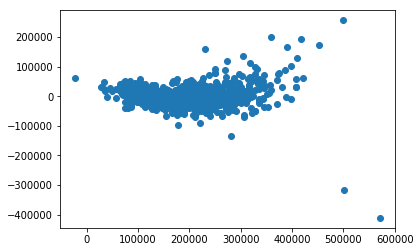

Empty DataFrame
Columns: [0]
Index: []


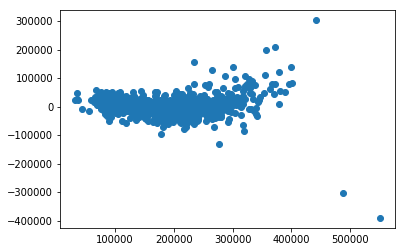

                0
533 -18669.753781


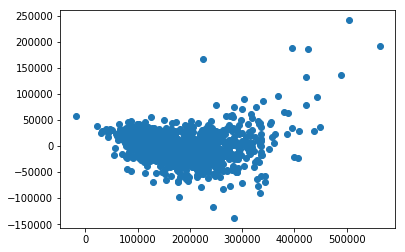

                0
533 -21738.556814


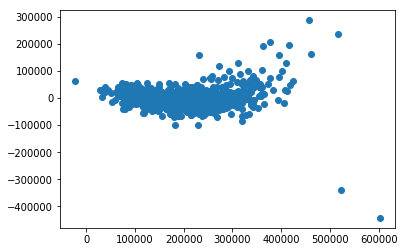

                0
533 -25377.177128


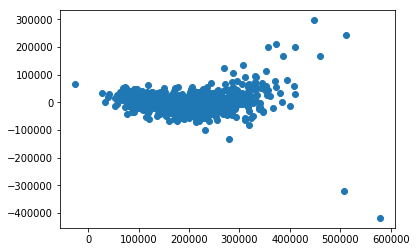

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.817134      12.62     13.377078  0.757078       33683          34442
1  0.804168      12.48     13.460463  0.980463       33250          36958
2  0.859676      12.63     13.308313  0.678313       29073          53360
3  0.811748      13.12     12.049196  1.070804       35397          25930
4  0.808131      12.63     13.704284  1.074284       34392          31233
          adjr2  train_err  validate_err  diff_err   train_rmse  validate_rmse
count  5.000000   5.000000      5.000000  5.000000      5.00000       5.000000
mean   0.820171  12.696000     13.179867  0.912188  33159.00000   36384.600000
std    0.022594   0.245418      0.649530  0.183611   2424.21049   10345.341116
min    0.804168  12.480000     12.049196  0.678313  29073.00000   25930.000000
25%    0.808131  12.620000     13.308313  0.757078  33250.00000   31233.000000
50%    0.811748  12.630000     13.377078  0.980463  33683.00000   34442.000000
75%

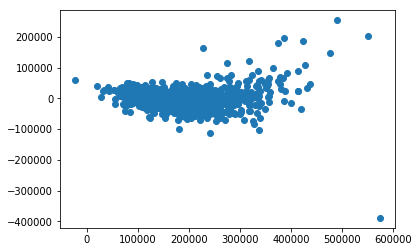

                0
533 -24542.901295


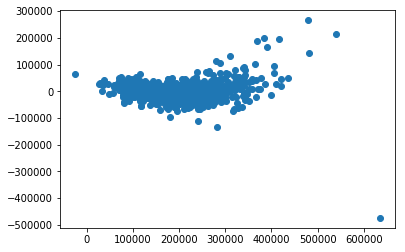

                0
533 -22913.843625


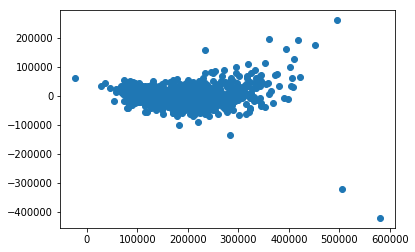

Empty DataFrame
Columns: [0]
Index: []


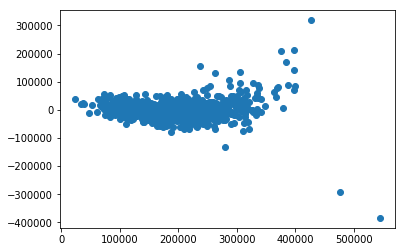

                0
533 -24470.738302


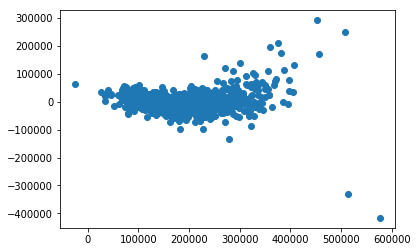

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.842132      12.60     12.828836  0.228836       32038          42552
1  0.827444      12.86     13.584350  0.724350       33396          35740
2  0.812338      12.86     11.818068  1.041932       33566          35102
3  0.804736      11.83     15.865393  4.035393       32602          39589
4  0.805659      12.89     11.860407  1.029593       34859          28846
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000   5.000000      5.000000  5.000000      5.000000   
mean   0.818462  12.608000     13.191411  1.412021  33292.200000   
std    0.016053   0.450522      1.665359  1.503173   1071.213891   
min    0.804736  11.830000     11.818068  0.228836  32038.000000   
25%    0.805659  12.600000     11.860407  0.724350  32602.000000   
50%    0.812338  12.860000     12.828836  1.029593  33396.000000   
75%    0.827444  12.860000     13.584350  1.041932  33566.000000   
max    0.842

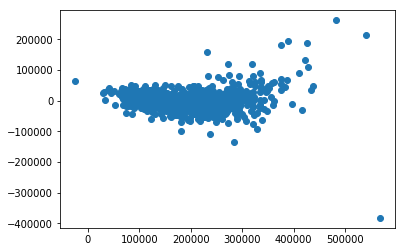

Empty DataFrame
Columns: [0]
Index: []


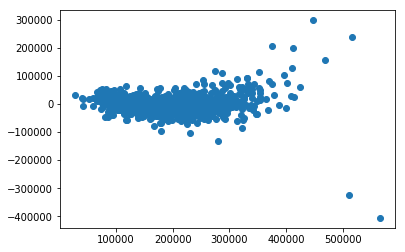

                0
533 -24516.695651


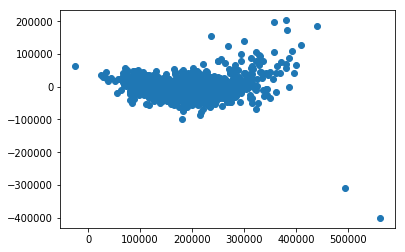

                0
533 -25371.338929


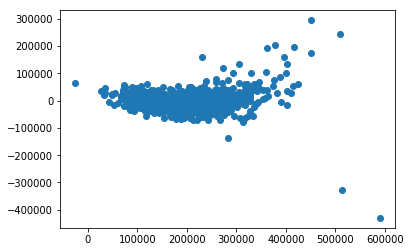

                0
533 -19266.456661


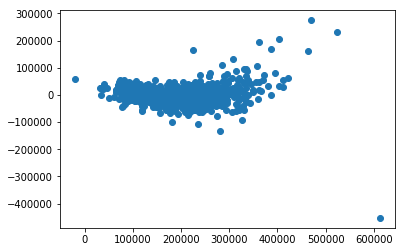

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.841402      12.12     14.500964  2.380964       31511          44675
1  0.815030      12.97     12.992627  0.022627       33976          33277
2  0.813742      12.71     12.068054  0.641946       32943          37759
3  0.802972      12.78     13.090589  0.310589       35087          27708
4  0.819398      12.73     12.839959  0.109959       33099          36264
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000   5.000000      5.000000  5.000000      5.000000   
mean   0.818509  12.662000     13.098439  0.693217  33323.200000   
std    0.014152   0.319953      0.881311  0.973062   1324.388991   
min    0.802972  12.120000     12.068054  0.022627  31511.000000   
25%    0.813742  12.710000     12.839959  0.109959  32943.000000   
50%    0.815030  12.730000     12.992627  0.310589  33099.000000   
75%    0.819398  12.780000     13.090589  0.641946  33976.000000   
max    0.841

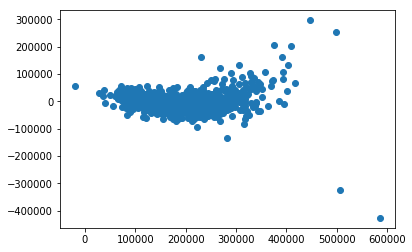

                0
533 -20089.674394


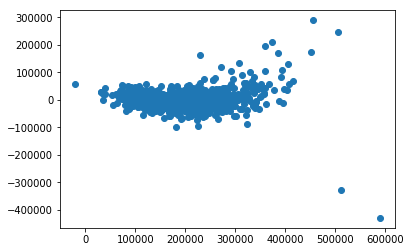

                0
533 -24146.567385


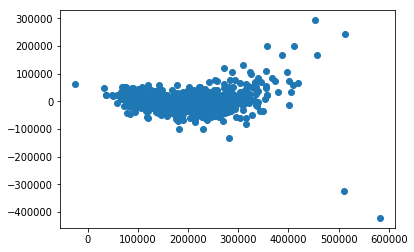

Empty DataFrame
Columns: [0]
Index: []


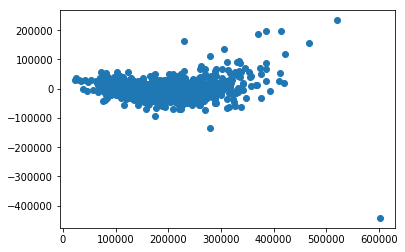

                0
533 -23750.344433


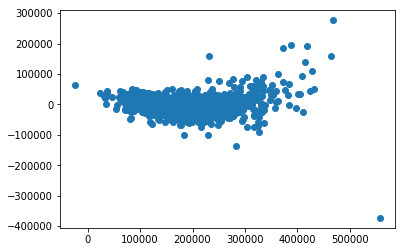

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.803106      12.77     12.500334  0.269666       34806          28950
1  0.811163      12.48     13.642102  1.162102       34498          30422
2  0.804487      12.89     12.760498  0.129502       34432          30859
3  0.828001      12.45     14.112232  1.662232       31900          40450
4  0.839485      12.53     12.023904  0.506096       31488          43378
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000   5.000000      5.000000  5.000000      5.000000   
mean   0.817249  12.624000     13.007814  0.745919  33424.800000   
std    0.015890   0.194885      0.852766  0.647522   1592.963653   
min    0.803106  12.450000     12.023904  0.129502  31488.000000   
25%    0.804487  12.480000     12.500334  0.269666  31900.000000   
50%    0.811163  12.530000     12.760498  0.506096  34432.000000   
75%    0.828001  12.770000     13.642102  1.162102  34498.000000   
max    0.839

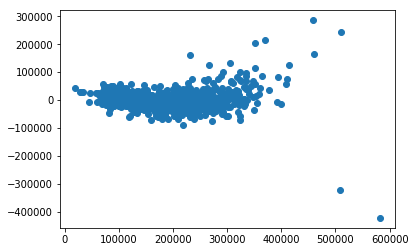

                0
533 -28810.422222


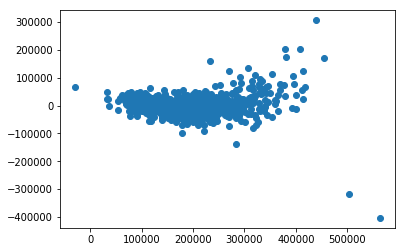

                0
533 -24877.618907


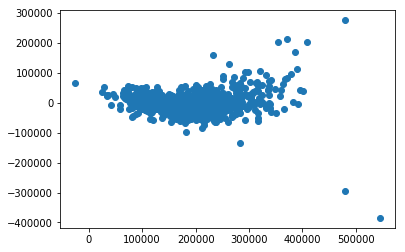

                0
533 -17791.643761


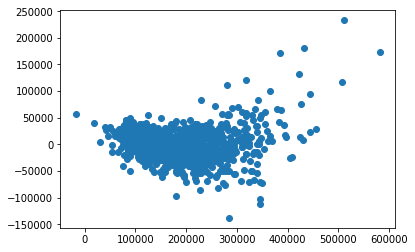

                0
533 -23572.733605


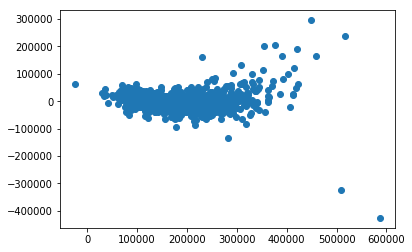

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.808731      12.45     13.385990  0.935990       34084          32513
1  0.811875      12.76     13.000421  0.240421       34206          31888
2  0.801664      12.80     12.294644  0.505356       33246          36840
3  0.870665      12.33     15.158217  2.828217       28682          54866
4  0.807605      12.95     12.606858  0.343142       34961          28118
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000   5.000000      5.000000  5.000000      5.000000   
mean   0.820108  12.658000     13.289226  0.970625  33035.800000   
std    0.028503   0.258205      1.122577  1.071827   2508.697112   
min    0.801664  12.330000     12.294644  0.240421  28682.000000   
25%    0.807605  12.450000     12.606858  0.343142  33246.000000   
50%    0.808731  12.760000     13.000421  0.505356  34084.000000   
75%    0.811875  12.800000     13.385990  0.935990  34206.000000   
max    0.870

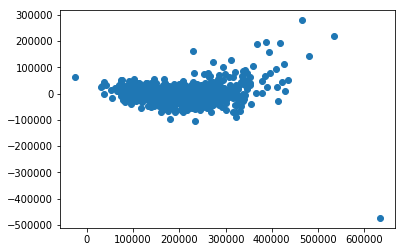

                0
533 -21234.318742


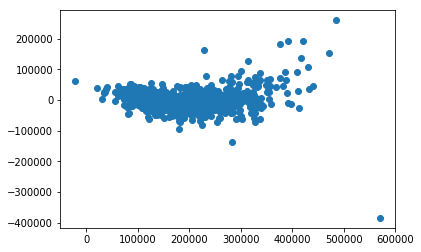

                0
533 -28063.492921


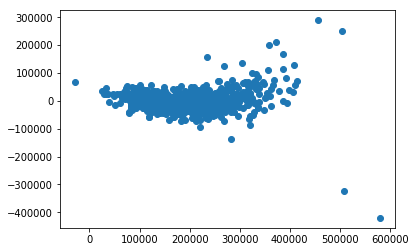

                0
533 -20788.641852


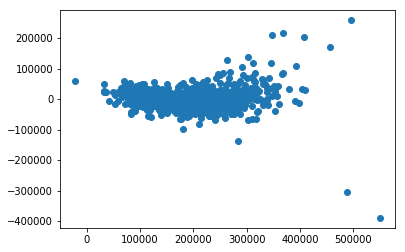

Empty DataFrame
Columns: [0]
Index: []


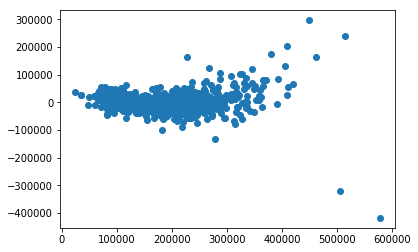

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.821522      12.43     14.152220  1.722220       33724          33919
1  0.843262      12.30     13.642449  1.342449       31223          44730
2  0.811792      12.94     11.833417  1.106583       34487          30350
3  0.810732      12.71     12.894760  0.184760       33086          36938
4  0.803433      12.58     12.893150  0.313150       33936          32850
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000   5.000000      5.000000  5.000000      5.000000   
mean   0.818148  12.592000     13.083199  0.933832  33291.200000   
std    0.015443   0.248334      0.878799  0.664214   1260.216132   
min    0.803433  12.300000     11.833417  0.184760  31223.000000   
25%    0.810732  12.430000     12.893150  0.313150  33086.000000   
50%    0.811792  12.580000     12.894760  1.106583  33724.000000   
75%    0.821522  12.710000     13.642449  1.342449  33936.000000   
max    0.843

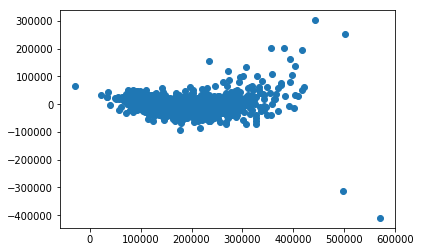

                0
533 -29647.488198


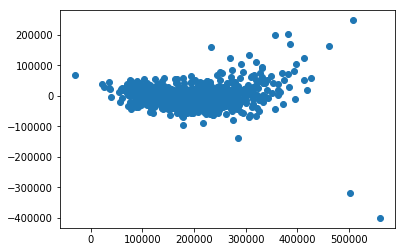

                0
533 -30078.798331


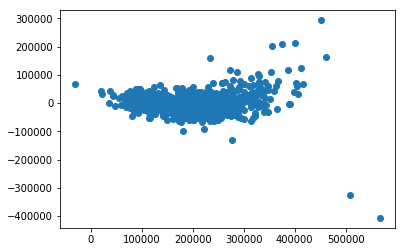

                0
533 -18618.150078


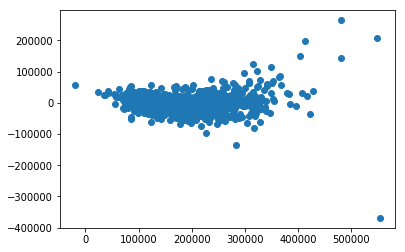

Empty DataFrame
Columns: [0]
Index: []


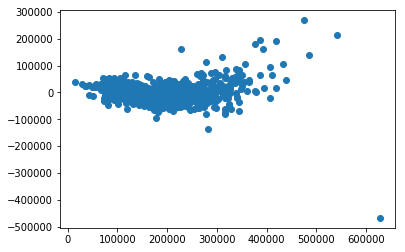

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.812192      12.65     13.280099  0.630099       34384          30939
1  0.815306      12.97     12.237729  0.732271       33591          33833
2  0.809222      12.74     12.165508  0.574492       34169          31430
3  0.843972      11.78     14.543967  2.763967       29771          48264
4  0.821433      12.78     13.584542  0.804542       33610          34242
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000    5.00000      5.000000  5.000000      5.000000   
mean   0.820425   12.58400     13.162369  1.101074  33105.000000   
std    0.013919    0.46436      0.993679  0.933845   1895.700003   
min    0.809222   11.78000     12.165508  0.574492  29771.000000   
25%    0.812192   12.65000     12.237729  0.630099  33591.000000   
50%    0.815306   12.74000     13.280099  0.732271  33610.000000   
75%    0.821433   12.78000     13.584542  0.804542  34169.000000   
max    0.843

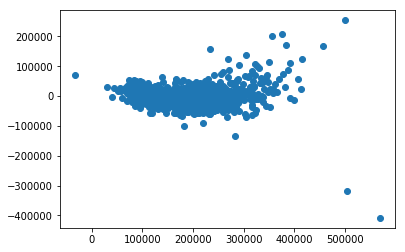

                0
533 -27955.624965


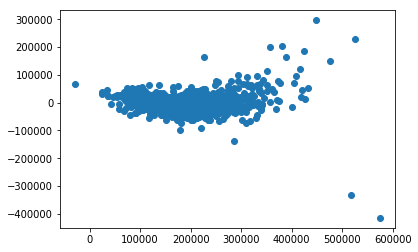

Empty DataFrame
Columns: [0]
Index: []


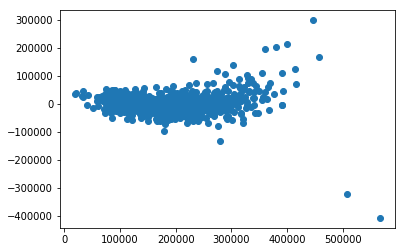

                0
533 -27706.301589


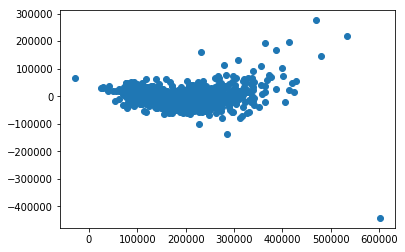

               0
533 -20266.30611


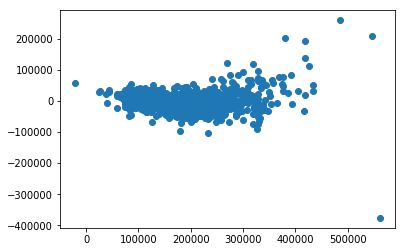

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.808680      12.63     12.298669  0.331331       33843          32609
1  0.809216      12.97     12.539703  0.430297       34821          28421
2  0.806225      12.64     12.468861  0.171139       33962          32480
3  0.828881      12.40     14.526426  2.126426       32412          38050
4  0.845744      12.12     13.948568  1.828568       30604          46455
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000   5.000000      5.000000  5.000000      5.000000   
mean   0.819749  12.552000     13.156445  0.977552  33128.400000   
std    0.017143   0.315547      1.011586  0.923516   1655.012175   
min    0.806225  12.120000     12.298669  0.171139  30604.000000   
25%    0.808680  12.400000     12.468861  0.331331  32412.000000   
50%    0.809216  12.630000     12.539703  0.430297  33843.000000   
75%    0.828881  12.640000     13.948568  1.828568  33962.000000   
max    0.845

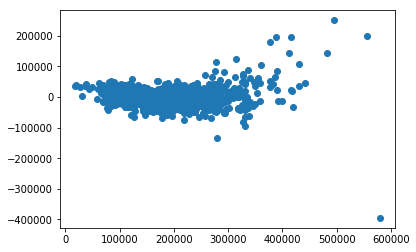

                0
533 -28980.374568


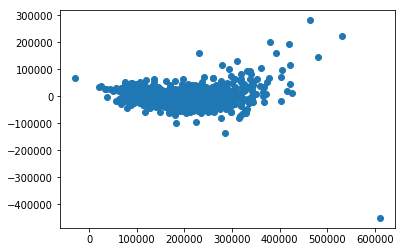

                0
533 -24136.826633


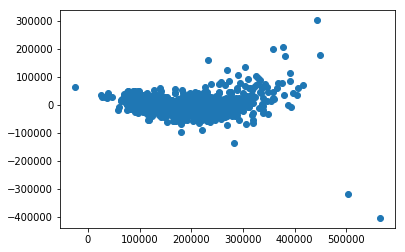

                0
533 -28718.721885


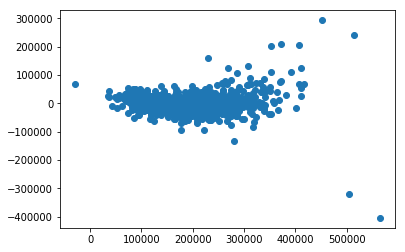

                0
533 -26212.635497


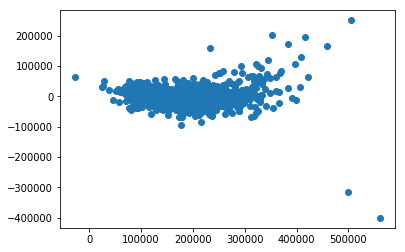

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.846949      12.03     14.540619  2.510619       31090          45262
1  0.824281      12.76     12.985385  0.225385       33315          34609
2  0.807960      12.55     12.709639  0.159639       33905          32329
3  0.800729      12.90     12.366547  0.533453       34705          28728
4  0.816637      12.52     13.026551  0.506551       32654          37468
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000   5.000000      5.000000  5.000000      5.000000   
mean   0.819311  12.552000     13.125748  0.787130  33133.800000   
std    0.017817   0.330863      0.833807  0.977598   1369.633053   
min    0.800729  12.030000     12.366547  0.159639  31090.000000   
25%    0.807960  12.520000     12.709639  0.225385  32654.000000   
50%    0.816637  12.550000     12.985385  0.506551  33315.000000   
75%    0.824281  12.760000     13.026551  0.533453  33905.000000   
max    0.846

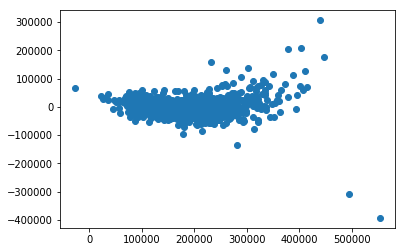

                0
533 -31447.105359


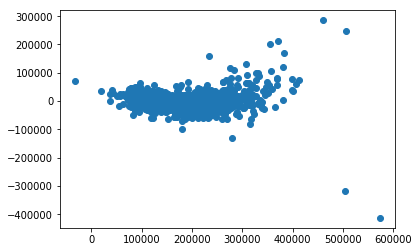

                0
533 -25322.680046


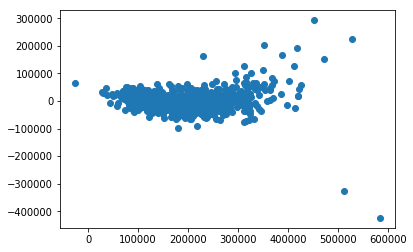

                0
533 -26736.209103


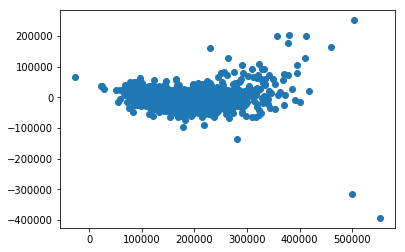

Empty DataFrame
Columns: [0]
Index: []


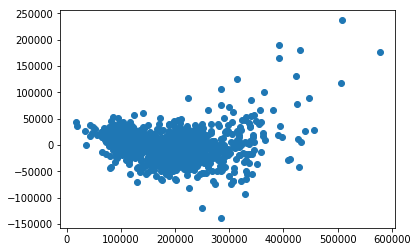

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.807618      12.89     11.564669  1.325331       33734          33204
1  0.805959      12.61     12.745447  0.135447       34130          31618
2  0.813702      12.61     13.507264  0.897264       34015          31516
3  0.809538      12.76     12.342630  0.417370       33815          32820
4  0.867559      12.23     15.210492  2.980492       28920          53708
          adjr2  train_err  validate_err  diff_err   train_rmse  validate_rmse
count  5.000000   5.000000      5.000000  5.000000      5.00000       5.000000
mean   0.820875  12.620000     13.074100  1.151181  32922.80000   36573.200000
std    0.026256   0.247386      1.385031  1.119305   2243.13992    9606.881242
min    0.805959  12.230000     11.564669  0.135447  28920.00000   31516.000000
25%    0.807618  12.610000     12.342630  0.417370  33734.00000   31618.000000
50%    0.809538  12.610000     12.745447  0.897264  33815.00000   32820.000000
75%

In [216]:
num_features = range(1,41,1)
scores = []
for i in num_features:
    feature_imp_cols = feature_imp_df['col_name'].head(i).values
    train_features = train_data[feature_imp_cols]
    test_features = test_data[feature_imp_cols]
    test, score = run_model_inputs(train_features, train_saleprice, test_features, test_id, 5)
    scores.append(score.mean())

In [217]:
scores_df = pd.DataFrame(scores)
scores_df.columns = ['adjr2', 'train_err', 'validate_err', 'diff_err', 'train_rmse', 'validate_rmse']

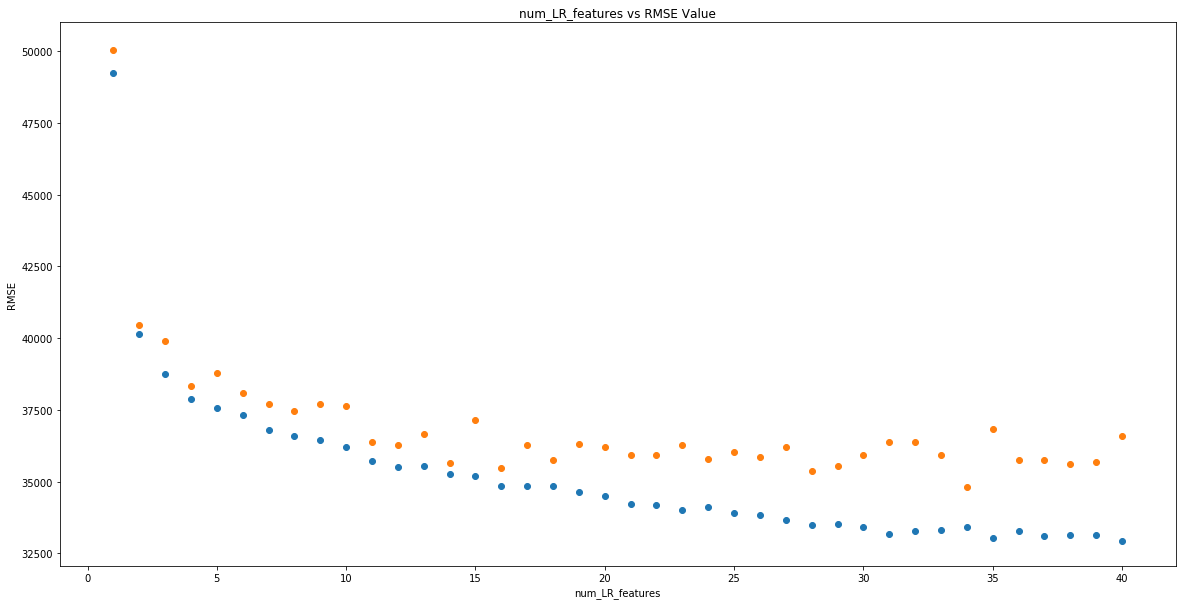

In [218]:
# Plot train and validate RMSE
plt.figure(figsize=(20,10))
rmse_plot = plt.scatter(scores_df.index+1 , scores_df['train_rmse'])
plt.scatter(scores_df.index+1 , scores_df['validate_rmse'])
plt.xlabel('num_LR_features')
plt.ylabel('RMSE')
plt.title('num_LR_features vs RMSE Value')
plt.show()

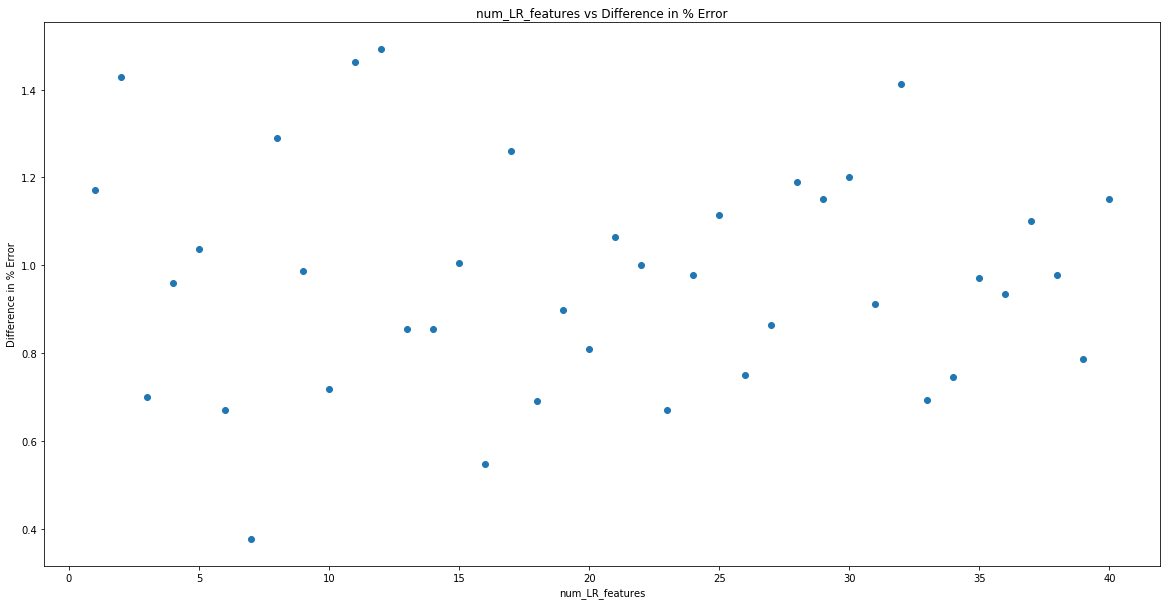

In [220]:
# Plot train and validate RMSE
plt.figure(figsize=(20,10))
rmse_plot = plt.scatter(scores_df.index+1 , scores_df['diff_err'])
plt.xlabel('num_LR_features')
plt.ylabel('Difference in % Error')
plt.title('num_LR_features vs Difference in % Error')
plt.show()

# LR with Regulization

In [253]:
def run_model_inputs_reg(train_data, train_saleprice, test_data, test_id, k, alpha, L1_wt):
    kf = KFold(n_splits=k, shuffle=True, random_state=round(random.uniform(1, 40000)))
    # kf = KFold(n_splits=10, shuffle=True, random_state=6104)
    kf.get_n_splits(train_data)
    print(kf)
    scores = []
    for train_index, test_index in kf.split(train_data):
        train_X, validate_X = train_data.loc[train_index,:], train_data.loc[test_index,:]
        train_y, validate_y = train_saleprice.loc[train_index], train_saleprice.loc[test_index]
#         model = sm.OLS(train_y, sm.add_constant(train_X)).fit()
        model = sm.OLS(train_y, sm.add_constant(train_X)).fit_regularized(
            method='elastic_net', alpha=alpha, L1_wt =L1_wt)
        
        print('Zeroing', 
              round((model.params[model.params == 0].shape[0]/model.params.shape[0])*100,2), 
              'features from the dataset')
        percent_zeroing_features = round((model.params[model.params == 0].shape[0]/model.params.shape[0])*100,2)
        # calculations to get percent error
        train_predictions = model.predict(sm.add_constant(train_X, has_constant='add'))
        avg_train_err = round(((abs(train_y - train_predictions))/train_y).mean()*100,2)
        
        train_predictions = pd.DataFrame(train_predictions)
        print(train_predictions[train_predictions.loc[:,0] <= 0])

        validate_predictions = model.predict(sm.add_constant(validate_X, has_constant='add'))
        avg_validate_err = ((abs(validate_y - validate_predictions))/validate_y).mean()*100
        
        scores.append([avg_train_err, avg_validate_err, abs(avg_train_err-avg_validate_err),
                       round(sqrt(mean_squared_error(train_y, train_predictions))), 
                       round(sqrt(mean_squared_error(validate_y, validate_predictions))), alpha, L1_wt, 
                       percent_zeroing_features])

#         # fitted values
#         model_fitted = pd.DataFrame(model.fittedvalues)

#         # model residuals
#         model_residuals = pd.DataFrame(model.resid)

#         # Residual plot
#         residual_plot = plt.scatter(model_fitted , model_residuals)
#         plt.show()

    scores = pd.DataFrame(scores, columns = ['train_err', 'validate_err', 'diff_err', 
                                             'train_rmse', 'validate_rmse', 'alpha', 'L1_wt', 
                                             'percent_zeroing_features'])
    print(scores)
    print(scores.describe())
    
    final_model = sm.OLS(train_saleprice, sm.add_constant(train_data)).fit()
    
    test_predictions = final_model.predict(sm.add_constant(test_data))
    test_predictions = pd.DataFrame(test_predictions)
    test_predictions.columns = ['SalePrice']
    test_predictions = pd.concat([test_id, test_predictions], axis=1)
    
    return test_predictions, scores

In [272]:
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')
print('Shape of train data:', train_data.shape)
print('Shape of test data:', test_data.shape)

train_saleprice = train_data['SalePrice']
train_data, train_id = feature_eng(train_data,0, 2, True)
test_data, test_id = feature_eng(test_data,0, 2, False)

for i in train_data.columns:
    if i not in test_data.columns:
        train_data = train_data.drop(columns = i)
print('Shape of train data:', train_data.shape)
test_data = test_data[train_data.columns]
print('Shape of test data:', test_data.shape)
# model = sm.OLS(train_saleprice, sm.add_constant(train_data)).fit_regularized(method='elastic_net', alpha=1000, L1_wt =1)
# print('Zeroing', round((model.params[model.params == 0].shape[0]/model.params.shape[0])*100,2), 'features from the dataset')
# print(model.params[model.params == 0])

Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 162)
Shape of test data: (1459, 162)


In [282]:
alpha_values = np.arange(0.1, 2, 0.1)
l1_wt_values = [1]

# alpha_values
scores = []
for alpha in alpha_values:
    for l1 in l1_wt_values:
        test, score = run_model_inputs_reg(train_data, train_saleprice, test_data, test_id, 5, alpha, l1)
        scores.append(score.mean())
scores

KFold(n_splits=5, random_state=35748, shuffle=True)
Zeroing 1.23 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 2.45 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 3.68 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 3.07 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 0.61 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
   train_err  validate_err  diff_err  train_rmse  validate_rmse  alpha  L1_wt  \
0      11.71     13.461767  1.751767       29175          34274    0.1      1   
1      11.81     14.228031  2.418031       30355          31057    0.1      1   
2      11.77     13.837204  2.067204       29153          36494    0.1      1   
3      11.77     12.942676  1.172676       30581          29604    0.1      1   
4      11.18     15.231615  4.051615       27282          43488    0.1      1   

   percent_zeroing_features  
0                      1.23  
1          

KFold(n_splits=5, random_state=26974, shuffle=True)
Zeroing 5.52 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 6.75 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 6.13 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 7.36 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 4.29 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
   train_err  validate_err  diff_err  train_rmse  validate_rmse  alpha  L1_wt  \
0      11.58     13.578161  1.998161       29069          35398    0.5      1   
1      11.69     13.740042  2.050042       30380          30013    0.5      1   
2      11.97     11.771619  0.198381       30144          29893    0.5      1   
3      11.30     17.530451  6.230451       26668          48662    0.5      1   
4      12.12     12.901264  0.781264       30115          31277    0.5      1   

   percent_zeroing_features  
0                      5.52  
1          

Zeroing 9.2 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 6.75 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 7.36 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 8.59 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 12.27 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
   train_err  validate_err  diff_err  train_rmse  validate_rmse  alpha  L1_wt  \
0      11.43     15.457873  4.027873       28196          41242    0.9      1   
1      11.58     13.896440  2.316440       29216          35089    0.9      1   
2      12.01     13.196258  1.186258       30210          31169    0.9      1   
3      11.51     13.999902  2.489902       29231          36415    0.9      1   
4      11.83     13.665844  1.835844       29694          35166    0.9      1   

   percent_zeroing_features  
0                      9.20  
1                      6.75  
2                      7.36  
3  

Zeroing 11.04 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 11.04 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 11.04 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 12.27 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 12.27 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
   train_err  validate_err  diff_err  train_rmse  validate_rmse  alpha  L1_wt  \
0      11.86     13.345800  1.485800       30789          29579    1.3      1   
1      11.77     15.011300  3.241300       26625          48740    1.3      1   
2      11.67     14.681819  3.011819       30222          31466    1.3      1   
3      12.02     13.814913  1.794913       30628          29881    1.3      1   
4      11.61     13.544809  1.934809       28029          38392    1.3      1   

   percent_zeroing_features  
0                     11.04  
1                     11.04  
2                     11.04 

Zeroing 15.34 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 14.72 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 13.5 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 11.04 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 9.82 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
   train_err  validate_err  diff_err  train_rmse  validate_rmse  alpha  L1_wt  \
0      11.48     16.207140  4.727140       29066          37740    1.7      1   
1      11.78     12.510769  0.730769       28358          40370    1.7      1   
2      11.80     12.966614  1.166614       28575          36609    1.7      1   
3      11.93     13.031193  1.101193       30888          27651    1.7      1   
4      12.00     13.009541  1.009541       30179          31325    1.7      1   

   percent_zeroing_features  
0                     15.34  
1                     14.72  
2                     13.50  


[train_err                      11.648000
 validate_err                   13.940258
 diff_err                        2.292258
 train_rmse                  29309.200000
 validate_rmse               34983.400000
 alpha                           0.100000
 L1_wt                           1.000000
 percent_zeroing_features        2.208000
 dtype: float64, train_err                      11.634000
 validate_err                   14.012227
 diff_err                        2.378227
 train_rmse                  29299.000000
 validate_rmse               35576.600000
 alpha                           0.200000
 L1_wt                           1.000000
 percent_zeroing_features        4.048000
 dtype: float64, train_err                      11.642000
 validate_err                   14.336969
 diff_err                        2.694969
 train_rmse                  29257.200000
 validate_rmse               36163.200000
 alpha                           0.300000
 L1_wt                           1.000000
 p

In [283]:
scores = pd.DataFrame(scores)
scores

train_err  validate_err  diff_err  train_rmse  validate_rmse  alpha  \
0      11.648     13.940258  2.292258     29309.2        34983.4    0.1   
1      11.634     14.012227  2.378227     29299.0        35576.6    0.2   
2      11.642     14.336969  2.694969     29257.2        36163.2    0.3   
3      11.692     14.126491  2.434491     29223.0        36156.2    0.4   
4      11.732     13.904308  2.251660     29275.2        35048.6    0.5   
5      11.722     13.995290  2.273290     29231.0        36480.0    0.6   
6      11.684     14.068410  2.384410     29281.4        35047.2    0.7   
7      11.686     14.011083  2.325083     29229.0        35610.0    0.8   
8      11.672     14.043264  2.371264     29309.4        35816.2    0.9   
9      11.742     13.818562  2.076562     29374.6        35069.8    1.0   
10     11.706     13.927340  2.221340     29337.6        34755.8    1.1   
11     11.754     14.024282  2.270282     29359.2        35802.8    1.2   
12     11.786     14.079728  2.293728     29258.6        35611.6    1.3   
13     11.724     14.082268  2.358268     29387.0        35295.8    1.4   
14     11.756     13.752457  1.996457     29398.4        34466.6    1.5   
15     11.760     13.931348  2.171348     29272.6        36053.2    1.6   
16     11.798     13.545051  1.747051     29413.2        34739.0    1.7   
17     11.822     14.164552  2.342552     29397.2        35551.0    1.8   
18     11.792     13.853952  2.061952     29397.2        35440.4    1.9   

    L1_wt  percent_zeroing_features  
0     1.0                     2.208  
1     1.0                     4.048  
2     1.0                     4.906  
3     1.0                     6.380  
4     1.0                     6.010  
5     1.0                     6.870  
6     1.0                     7.606  
7     1.0                     7.606  
8     1.0                     8.834  
9     1.0                    10.306  
10    1.0                    11.654  
11    1.0                    10.432  
12    1.0                    11.532  
13    1.0                    11.534  
14    1.0                    11.782  
15    1.0                    11.532  
16    1.0                    12.884  
17    1.0                    13.374  
18    1.0                    13.988

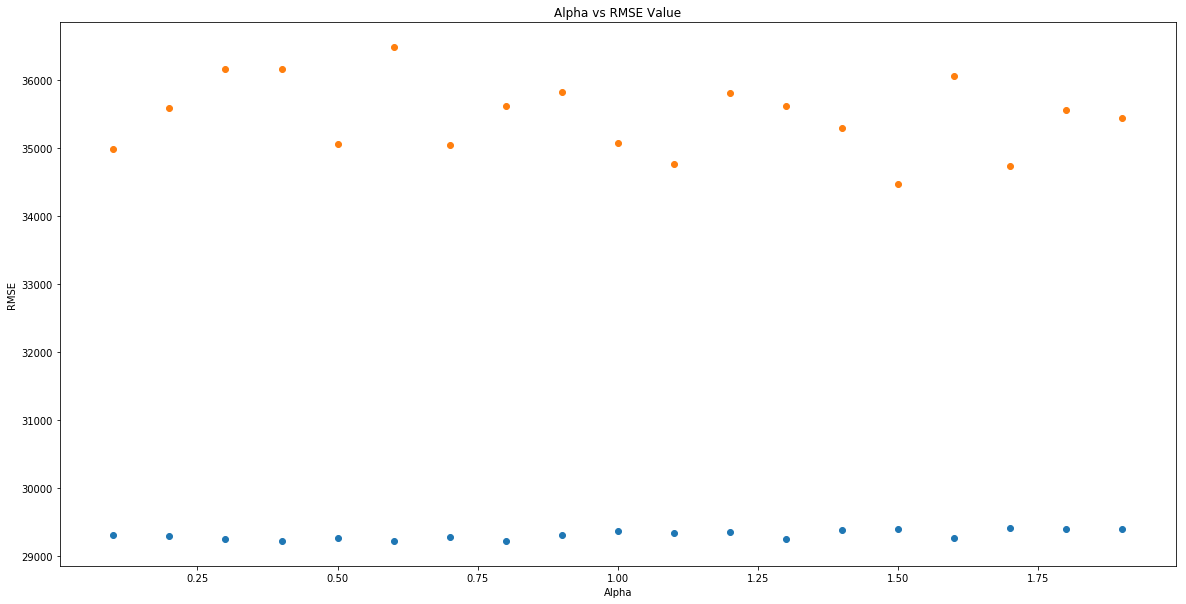

In [284]:
# Plot train and validate RMSE based on alpha values
plt.figure(figsize=(20,10))
rmse_plot = plt.scatter(scores['alpha'] , scores['train_rmse'])
plt.scatter(scores['alpha'] , scores['validate_rmse'])
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('Alpha vs RMSE Value')
plt.show()

In [286]:
alpha_values = range(10, 200, 10)
l1_wt_values = [1]

# alpha_values
scores = []
for alpha in alpha_values:
    for l1 in l1_wt_values:
        test, score = run_model_inputs_reg(train_data, train_saleprice, test_data, test_id, 5, alpha, l1)
        scores.append(score.mean())
scores

KFold(n_splits=5, random_state=27053, shuffle=True)
Zeroing 30.06 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 27.61 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 25.15 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 25.15 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 23.93 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
   train_err  validate_err  diff_err  train_rmse  validate_rmse  alpha  L1_wt  \
0      12.04     14.380021  2.340021       29004          39730     10      1   
1      11.89     12.844934  0.954934       30306          30724     10      1   
2      12.04     12.659600  0.619600       29556          33301     10      1   
3      11.78     13.635188  1.855188       29786          34663     10      1   
4      11.87     14.753321  2.883321       29398          35820     10      1   

   percent_zeroing_features  
0                     30.06  
1     

Zeroing 41.1 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 44.17 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 41.72 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 44.17 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 39.88 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
   train_err  validate_err  diff_err  train_rmse  validate_rmse  alpha  L1_wt  \
0      11.92     13.427702  1.507702       30860          30517     50      1   
1      12.21     12.016591  0.193409       31505          29193     50      1   
2      11.72     14.897263  3.177263       28747          39548     50      1   
3      12.06     13.886648  1.826648       29356          38204     50      1   
4      11.68     13.525903  1.845903       29354          36168     50      1   

   percent_zeroing_features  
0                     41.10  
1                     44.17  
2                     41.72  

Zeroing 50.92 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 52.15 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 52.15 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 49.69 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 52.76 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
   train_err  validate_err  diff_err  train_rmse  validate_rmse  alpha  L1_wt  \
0      11.60     14.273964  2.673964       31561          29691     90      1   
1      12.20     12.596477  0.396477       29600          38162     90      1   
2      12.00     13.249430  1.249430       30350          34706     90      1   
3      11.98     12.408060  0.428060       29621          36140     90      1   
4      12.09     12.948044  0.858044       31384          29964     90      1   

   percent_zeroing_features  
0                     50.92  
1                     52.15  
2                     52.15 

KFold(n_splits=5, random_state=18354, shuffle=True)
Zeroing 53.99 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 53.37 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 55.83 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 57.06 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 57.67 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
   train_err  validate_err  diff_err  train_rmse  validate_rmse  alpha  L1_wt  \
0      12.49     11.835099  0.654901       31870          29802    130      1   
1      12.53     14.357734  1.827734       31892          37067    130      1   
2      12.26     13.099284  0.839284       32616          27479    130      1   
3      11.89     13.074965  1.184965       28983          42912    130      1   
4      12.25     13.385572  1.135572       31127          33541    130      1   

   percent_zeroing_features  
0                     53.99  
1     

Zeroing 57.67 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 58.28 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 60.12 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 59.51 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
Zeroing 58.28 features from the dataset
Empty DataFrame
Columns: [0]
Index: []
   train_err  validate_err  diff_err  train_rmse  validate_rmse  alpha  L1_wt  \
0      13.15     13.335484  0.185484       34027          28069    170      1   
1      12.78     13.522054  0.742054       31717          38050    170      1   
2      12.20     12.104282  0.095718       31615          32437    170      1   
3      12.21     13.975193  1.765193       32666          28788    170      1   
4      12.54     14.612333  2.072333       31342          41774    170      1   

   percent_zeroing_features  
0                     57.67  
1                     58.28  
2                     60.12 

[train_err                      11.924000
 validate_err                   13.654613
 diff_err                        1.730613
 train_rmse                  29610.000000
 validate_rmse               34847.600000
 alpha                          10.000000
 L1_wt                           1.000000
 percent_zeroing_features       26.380000
 dtype: float64, train_err                      11.956000
 validate_err                   13.690704
 diff_err                        1.774126
 train_rmse                  29585.600000
 validate_rmse               36416.200000
 alpha                          20.000000
 L1_wt                           1.000000
 percent_zeroing_features       30.920000
 dtype: float64, train_err                      11.924000
 validate_err                   13.455784
 diff_err                        1.531784
 train_rmse                  29785.200000
 validate_rmse               34459.800000
 alpha                          30.000000
 L1_wt                           1.000000
 p

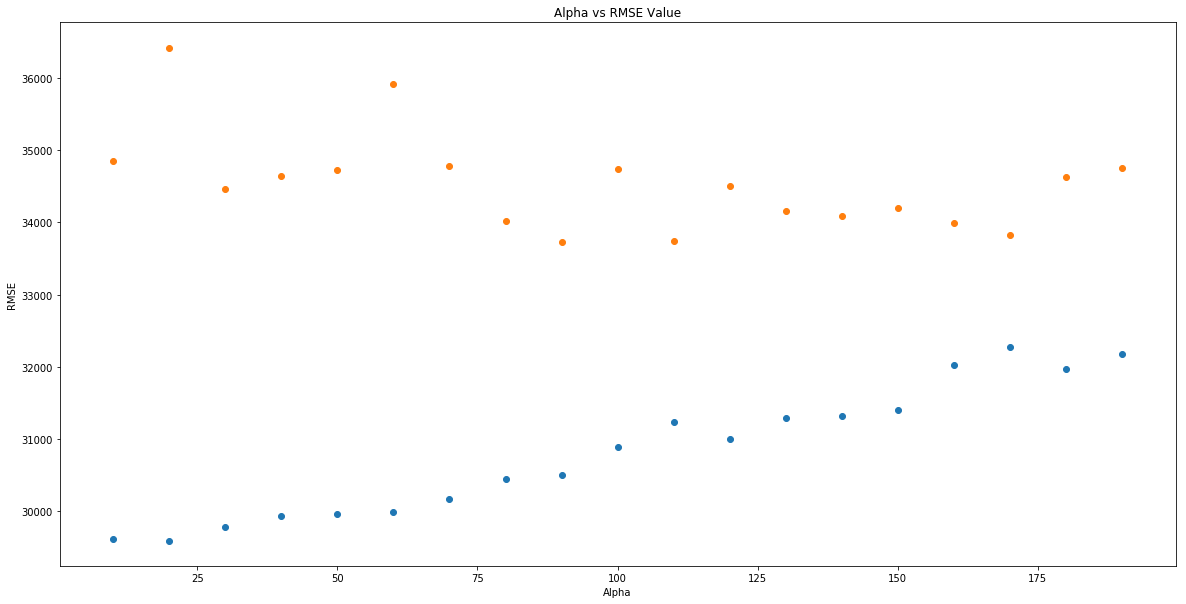

In [287]:
scores = pd.DataFrame(scores)
scores

# Plot train and validate RMSE based on alpha values
plt.figure(figsize=(20,10))
rmse_plot = plt.scatter(scores['alpha'] , scores['train_rmse'])
plt.scatter(scores['alpha'] , scores['validate_rmse'])
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('Alpha vs RMSE Value')
plt.show()

# Gradient Boosting

In [388]:
def gradient_boosting(train_data, train_saleprice, test_data, test_id, k, 
                      max_features, n_estimators, max_depth):
    
    kf = KFold(n_splits=k, shuffle=True, random_state=round(random.uniform(1, 40000)))
    # kf = KFold(n_splits=10, shuffle=True, random_state=6104)
    kf.get_n_splits(train_data)
    print(kf)
    scores = []
    for train_index, test_index in kf.split(train_data):
        train_X, validate_X = train_data.loc[train_index,:], train_data.loc[test_index,:]
        train_y, validate_y = train_saleprice.loc[train_index], train_saleprice.loc[test_index]
        gbr = GradientBoostingRegressor()
        gbr.fit(train_X, train_y)
        
        # gets the RMSE of train and validate
        train_predictions = gbr.predict(train_X)
        validate_predictions = gbr.predict(validate_X)
        rmse_train = round(sqrt(mean_squared_error(train_y, train_predictions)))
        rmse_validate = round(sqrt(mean_squared_error(validate_y, validate_predictions)))
        
#         # gets the percent error
        avg_train_err = round(((abs(train_y - train_predictions))/train_y).mean()*100,2)
        avg_validate_err = round(((abs(validate_y - validate_predictions))/validate_y).mean()*100,2)
        print(avg_train_err)
        print(avg_validate_err)
        score.append([max_features, n_estimators, max_depth, avg_train_err, avg_validate_err, 
                      rmse_train, rmse_validate])
    
    return pd.DataFrame(score)

In [389]:
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')
print('Shape of train data:', train_data.shape)
print('Shape of test data:', test_data.shape)

train_saleprice = train_data['SalePrice']
train_data, train_id = feature_eng(train_data,0.2, 2, True)
test_data, test_id = feature_eng(test_data,0.2, 2, False)

for i in train_data.columns:
    if i not in test_data.columns:
        train_data = train_data.drop(columns = i)
print('Shape of train data:', train_data.shape)
test_data = test_data[train_data.columns]
print('Shape of test data:', test_data.shape)

Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 45)
Shape of test data: (1459, 45)


In [392]:
scores = gradient_boosting(train_data, train_saleprice, test_data, test_id, 2, 100, 100, 100000)

KFold(n_splits=2, random_state=22098, shuffle=True)
6.83
10.18
6.22
10.9


In [393]:
scores

0       1       2         3      4        5        6
0      0.00    0.70   15897  32937.00    NaN      NaN      NaN
1      0.00    0.72   15532  26006.00    NaN      NaN      NaN
2      0.00    0.74   15130  38168.00    NaN      NaN      NaN
3      0.00    0.76   15003  28052.00    NaN      NaN      NaN
4      0.00    0.78   15734  23975.00    NaN      NaN      NaN
5      0.00    0.80   14679  28574.00    NaN      NaN      NaN
6      0.00    0.82   16239  19292.00    NaN      NaN      NaN
7      0.00    0.84   15570  22258.00    NaN      NaN      NaN
8      0.00    0.86   15626  33944.00    NaN      NaN      NaN
9      0.00    0.88   15510  32336.00    NaN      NaN      NaN
10     0.00    0.90   14966  29219.00    NaN      NaN      NaN
11     0.00    0.92   15767  20977.00    NaN      NaN      NaN
12     0.00    0.94   15145  28226.00    NaN      NaN      NaN
13     0.00    0.96   15796  28792.00    NaN      NaN      NaN
14     0.00    0.98   14765  25204.00    NaN      NaN      NaN
15     0.00    1.00   15290  23119.00    NaN      NaN      NaN
16     0.00    1.02   14983  24725.00    NaN      NaN      NaN
17     0.00    1.04   15142  26612.00    NaN      NaN      NaN
18     0.02    0.70   15864  35170.00    NaN      NaN      NaN
19     0.02    0.72   16039  24643.00    NaN      NaN      NaN
20     0.02    0.74   15906  22196.00    NaN      NaN      NaN
21     0.02    0.76   15860  21463.00    NaN      NaN      NaN
22     0.02    0.78   16022  20147.00    NaN      NaN      NaN
23     0.02    0.80   15729  31615.00    NaN      NaN      NaN
24     0.02    0.82   15083  26612.00    NaN      NaN      NaN
25     0.02    0.84   16193  22177.00    NaN      NaN      NaN
26     0.02    0.86   15119  24701.00    NaN      NaN      NaN
27     0.02    0.88   15606  27733.00    NaN      NaN      NaN
28     0.02    0.90   14995  24918.00    NaN      NaN      NaN
29     0.02    0.92   15063  24480.00    NaN      NaN      NaN
30     0.02    0.94   15432  23747.00    NaN      NaN      NaN
31     0.02    0.96   15298  30674.00    NaN      NaN      NaN
32     0.02    0.98   15376  25179.00    NaN      NaN      NaN
33     0.02    1.00   14821  27978.00    NaN      NaN      NaN
34     0.02    1.02   15648  26901.00    NaN      NaN      NaN
35     0.02    1.04   15442  28344.00    NaN      NaN      NaN
36     0.04    0.70   16284  22760.00    NaN      NaN      NaN
37     0.04    0.72   15534  24787.00    NaN      NaN      NaN
38     0.04    0.74   15861  22250.00    NaN      NaN      NaN
39     0.04    0.76   15544  26584.00    NaN      NaN      NaN
40     0.04    0.78   15919  23360.00    NaN      NaN      NaN
41     0.04    0.80   15903  26003.00    NaN      NaN      NaN
42     0.04    0.82   15948  24355.00    NaN      NaN      NaN
43     0.04    0.84   16110  20948.00    NaN      NaN      NaN
44     0.04    0.86   15333  26577.00    NaN      NaN      NaN
45     0.04    0.88   15225  50001.00    NaN      NaN      NaN
46     0.04    0.90   16008  24888.00    NaN      NaN      NaN
47     0.04    0.92   15893  25973.00    NaN      NaN      NaN
48     0.04    0.94   15689  23972.00    NaN      NaN      NaN
49     0.04    0.96   14470  35565.00    NaN      NaN      NaN
50     0.04    0.98   15315  26398.00    NaN      NaN      NaN
51     0.04    1.00   15761  25310.00    NaN      NaN      NaN
52     0.04    1.02   15406  26704.00    NaN      NaN      NaN
53     0.04    1.04   15394  24577.00    NaN      NaN      NaN
54     0.06    0.70   15604  27819.00    NaN      NaN      NaN
55     0.06    0.72   15934  24244.00    NaN      NaN      NaN
56     0.06    0.74   15534  27926.00    NaN      NaN      NaN
57     0.06    0.76   16002  20919.00    NaN      NaN      NaN
58     0.06    0.78   15238  24317.00    NaN      NaN      NaN
59     0.06    0.80   15766  24309.00    NaN      NaN      NaN
60     0.06    0.82   15568  22804.00    NaN      NaN      NaN
61     0.06    0.84   15427  31131.00    NaN      NaN      NaN
62     0.06    0.86   15692  23921.00    

In [326]:
score = []

min_corr = np.arange(0,0.75,0.02)
min_feat_corr = np.arange(0.7, 1.04, 0.02)
for corr in min_corr:
    for feat_corr in min_feat_corr:
        # to test starting outputs
        filepath = '//Users//josephcolaco//predicting_house_prices//data//'
        train_data = pd.read_csv(filepath + 'train.csv')
        test_data = pd.read_csv(filepath + 'test.csv')
        print('Shape of train data:', train_data.shape)
        print('Shape of test data:', test_data.shape)

        train_saleprice = train_data['SalePrice']
        train_data, train_id = feature_eng(train_data,corr, feat_corr, True)
        test_data, test_id = feature_eng(test_data,corr, feat_corr, False)

        for i in train_data.columns:
            if i not in test_data.columns:
                train_data = train_data.drop(columns = i)
        print('Shape of train data:', train_data.shape)
        test_data = test_data[train_data.columns]
        print('Shape of test data:', test_data.shape)

        gbr = GradientBoostingRegressor()
        train_X, validate_X, train_y, validate_y = train_test_split(train_data, train_saleprice, test_size=0.2)
        gbr.fit(train_X, train_y)
        rmse_train = round(sqrt(mean_squared_error(train_y, gbr.predict(train_X))))
        rmse_validate = round(sqrt(mean_squared_error(validate_y, gbr.predict(validate_X))))
        score.append([corr , feat_corr, rmse_train, rmse_validate])


Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 140)
Shape of test data: (1459, 140)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 141)
Shape of test data: (1459, 141)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 144)
Shape of test data: (1459, 144)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 146)
Shape of test data: (1459, 146)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 149)
Shape of test data: (1459, 149)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 151)
Shape of test data: (1459, 151)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 152)
Shape of test data: (1459, 152)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 153)
Shape of

Shape of train data: (1460, 96)
Shape of test data: (1459, 96)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 96)
Shape of test data: (1459, 96)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 99)
Shape of test data: (1459, 99)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 99)
Shape of test data: (1459, 99)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 99)
Shape of test data: (1459, 99)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 102)
Shape of test data: (1459, 102)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 102)
Shape of test data: (1459, 102)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 102)
Shape of test data: (1459, 102)
Shape of train data: (1460, 81)
Shape of test dat

Shape of train data: (1460, 51)
Shape of test data: (1459, 51)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 53)
Shape of test data: (1459, 53)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 55)
Shape of test data: (1459, 55)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 56)
Shape of test data: (1459, 56)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 57)
Shape of test data: (1459, 57)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 57)
Shape of test data: (1459, 57)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 58)
Shape of test data: (1459, 58)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 58)
Shape of test data: (1459, 58)
Shape of train data: (1460, 81)
Shape of test data: (14

Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 45)
Shape of test data: (1459, 45)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 45)
Shape of test data: (1459, 45)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 45)
Shape of test data: (1459, 45)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 31)
Shape of test data: (1459, 31)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 32)
Shape of test data: (1459, 32)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 34)
Shape of test data: (1459, 34)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 35)
Shape of test data: (1459, 35)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 37)
Shape of test data: (14

Shape of train data: (1460, 28)
Shape of test data: (1459, 28)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 29)
Shape of test data: (1459, 29)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 29)
Shape of test data: (1459, 29)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 29)
Shape of test data: (1459, 29)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 29)
Shape of test data: (1459, 29)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 29)
Shape of test data: (1459, 29)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 29)
Shape of test data: (1459, 29)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 30)
Shape of test data: (1459, 30)
Shape of train data: (1460, 81)
Shape of test data: (14

Shape of train data: (1460, 16)
Shape of test data: (1459, 16)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 17)
Shape of test data: (1459, 17)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 17)
Shape of test data: (1459, 17)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 17)
Shape of test data: (1459, 17)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 17)
Shape of test data: (1459, 17)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 18)
Shape of test data: (1459, 18)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 18)
Shape of test data: (1459, 18)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 19)
Shape of test data: (1459, 19)
Shape of train data: (1460, 81)
Shape of test data: (14

Shape of train data: (1460, 15)
Shape of test data: (1459, 15)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 15)
Shape of test data: (1459, 15)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 15)
Shape of test data: (1459, 15)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 15)
Shape of test data: (1459, 15)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 10)
Shape of test data: (1459, 10)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 11)
Shape of test data: (1459, 11)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 12)
Shape of test data: (1459, 12)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 13)
Shape of test data: (1459, 13)
Shape of train data: (1460, 81)
Shape of test data: (14

Shape of train data: (1460, 11)
Shape of test data: (1459, 11)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 12)
Shape of test data: (1459, 12)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 12)
Shape of test data: (1459, 12)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 12)
Shape of test data: (1459, 12)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 12)
Shape of test data: (1459, 12)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 12)
Shape of test data: (1459, 12)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 12)
Shape of test data: (1459, 12)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 12)
Shape of test data: (1459, 12)
Shape of train data: (1460, 81)
Shape of test data: (14

Shape of train data: (1460, 7)
Shape of test data: (1459, 7)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 8)
Shape of test data: (1459, 8)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 8)
Shape of test data: (1459, 8)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 8)
Shape of test data: (1459, 8)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 8)
Shape of test data: (1459, 8)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 8)
Shape of test data: (1459, 8)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 8)
Shape of test data: (1459, 8)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 9)
Shape of test data: (1459, 9)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of

Shape of train data: (1460, 7)
Shape of test data: (1459, 7)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 7)
Shape of test data: (1459, 7)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 7)
Shape of test data: (1459, 7)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 2)
Shape of test data: (1459, 2)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 2)
Shape of test data: (1459, 2)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 3)
Shape of test data: (1459, 3)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 3)
Shape of test data: (1459, 3)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 3)
Shape of test data: (1459, 3)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of

Shape of train data: (1460, 2)
Shape of test data: (1459, 2)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 2)
Shape of test data: (1459, 2)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 2)
Shape of test data: (1459, 2)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 2)
Shape of test data: (1459, 2)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 2)
Shape of test data: (1459, 2)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 2)
Shape of test data: (1459, 2)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 2)
Shape of test data: (1459, 2)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 2)
Shape of test data: (1459, 2)
Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of

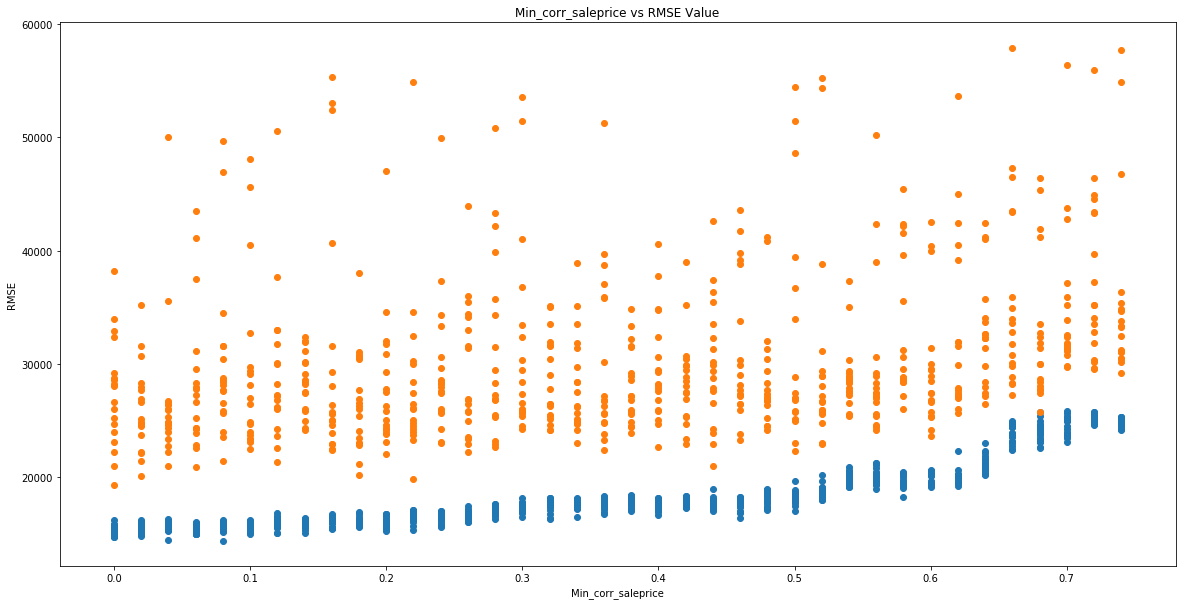

In [327]:
score_df = pd.DataFrame(score)
score_df.columns = ['min_corr_saleprice', 'min_feat_corr', 'train_rmse', 'validate_rmse']
score_df
# Plot train and validate RMSE based on min_sale_corr
plt.figure(figsize=(20,10))
rmse_plot = plt.scatter(score_df['min_corr_saleprice'] , score_df['train_rmse'])
plt.scatter(score_df['min_corr_saleprice'] , score_df['validate_rmse'])
plt.xlabel('Min_corr_saleprice')
plt.ylabel('RMSE')
plt.title('Min_corr_saleprice vs RMSE Value')
plt.show()

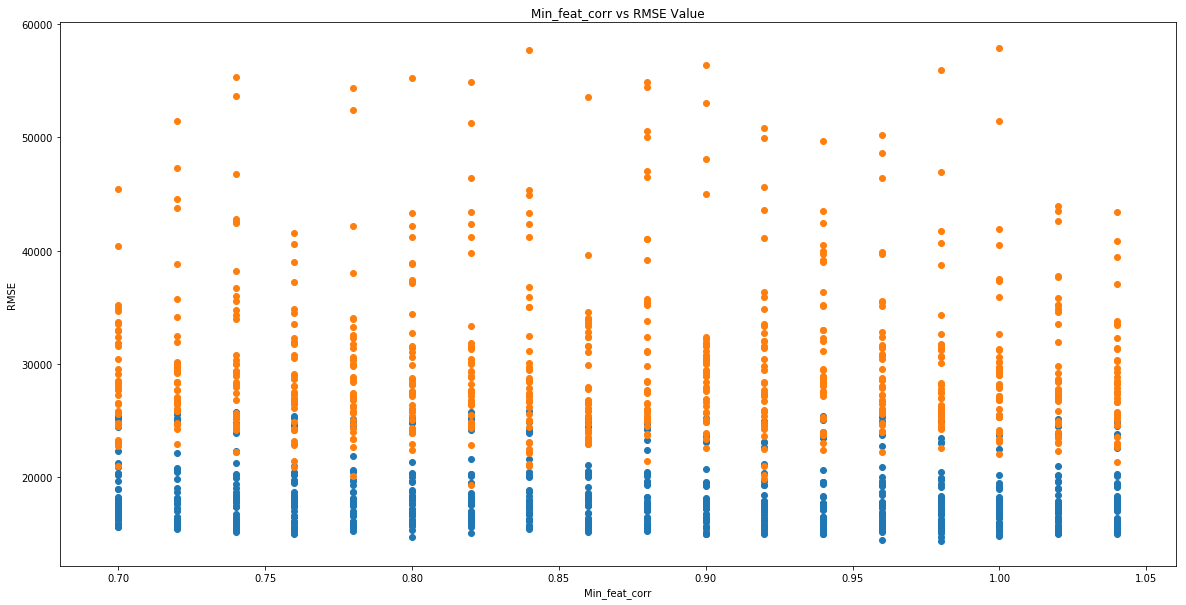

In [337]:
# Plot train and validate RMSE based on min_feat_corr
plt.figure(figsize=(20,10))
rmse_plot = plt.scatter(score_df['min_feat_corr'] , score_df['train_rmse'])
plt.scatter(score_df['min_feat_corr'] , score_df['validate_rmse'])
plt.xlabel('Min_feat_corr')
plt.ylabel('RMSE')
plt.title('Min_feat_corr vs RMSE Value')
plt.show()

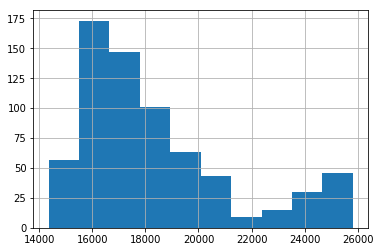

In [338]:
score_df[score_df['validate_rmse'] < 20000]

hist = score_df['train_rmse'].hist(bins=10)

# hist2 = score_df['validate_rmse'].hist(bins=10)

In [341]:
feature_importance = gbr.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
feature_importance 

array([ 27.92722815, 100.        ])

## Bayesian optimization trail

In [115]:
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')
print('Shape of train data:', train_data.shape)
print('Shape of test data:', test_data.shape)

train_saleprice = train_data['SalePrice']
train_data, train_id = feature_eng_rf(train_data, 0, 2, True)
test_data, test_id = feature_eng_rf(test_data, 0, 2, False)

for i in train_data.columns:
    if i not in test_data.columns:
        train_data = train_data.drop(columns = i)
print('Shape of train data:', train_data.shape)
test_data = test_data[train_data.columns]
print('Shape of test data:', test_data.shape)

Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 162)
Shape of test data: (1459, 162)


In [ ]:
def run_model_inputs_rf(train_data, train_saleprice, k, estimators, depth, features, samples_leaf, impurity_decrease):
    kf = KFold(n_splits=k, shuffle=True, random_state=round(random.uniform(1, 40000)))
    kf.get_n_splits(train_data)
    forest = RandomForestRegressor(
        n_estimators=estimators, max_depth=depth, max_features=features, min_samples_leaf=samples_leaf, 
        min_impurity_decrease=impurity_decrease)
    scores = []
    for train_index, test_index in kf.split(train_data):
        train_X, validate_X = train_data.loc[train_index,:], train_data.loc[test_index,:]
        train_y, validate_y = train_saleprice.loc[train_index], train_saleprice.loc[test_index]
        forest.fit(train_X,train_y)
        
        # For training data
        train_predictions = forest.predict(train_X)
        train_predictions = pd.DataFrame(train_predictions)
        train_predictions.columns = ['PredSalePrice']
        train_y_df = pd.DataFrame(train_y)
        train_y_df = train_y_df.reset_index(drop=True)
        train_predictions['SalePrice'] = train_y_df['SalePrice']
        train_predictions['PredErr'] = (abs(
            train_predictions['PredSalePrice'] - train_predictions['SalePrice'])/train_predictions['SalePrice'])
        avg_train_err = train_predictions['PredErr'].mean()
        
        # For validation data
        validate_predictions = forest.predict(validate_X)
        validate_predictions = pd.DataFrame(validate_predictions)
        validate_predictions.columns = ['PredSalePrice']
        validate_y_df = pd.DataFrame(validate_y)
        validate_y_df = validate_y_df.reset_index(drop=True)
        validate_predictions['SalePrice'] = validate_y_df['SalePrice']
        validate_predictions['PredErr'] = (abs(
            validate_predictions['PredSalePrice'] - validate_predictions['SalePrice'])/validate_predictions['SalePrice'])
        avg_validate_err = validate_predictions['PredErr'].mean()
        
        # append scores list
        scores.append([estimators, depth, features, samples_leaf, impurity_decrease,
                     forest.score(train_X, train_y), avg_train_err, avg_validate_err, 
                     abs(avg_train_err-avg_validate_err), 
                     round(sqrt(mean_squared_error(train_predictions['SalePrice'], train_predictions['PredSalePrice']))), 
                     round(sqrt(mean_squared_error(validate_predictions['SalePrice'], validate_predictions['PredSalePrice'])))])
        
    scores = pd.DataFrame(scores, columns = ['n_estimators', 'max_depth', 'max_features', 'min_samples_leaf', 'min_impurity_decrease','r2', 
                                                 'train_err', 'validate_err', 'diff_err', 'train_rmse', 'validate_rmse'])
    
    return scores.mean()

In [123]:
def bayes_rf_objective(estimators, depth, features, samples_leaf):
    estimators = math.ceil(estimators)
    depth = math.ceil(depth)
    features = math.ceil(features)
    samples_leaf = math.ceil(samples_leaf)
#     impurity_decrease = math.ceil(impurity_decrease)
    
    forest = RandomForestRegressor(
            n_estimators=estimators, max_depth=depth, max_features=features, min_samples_leaf=samples_leaf)

    cv_score = pd.DataFrame(cross_val_score(forest, X=train_data, y=train_saleprice, cv=10))
    return cv_score.mean().values[0]
    

In [124]:
bo = BayesianOptimization(bayes_rf_objective, {'estimators': (10, 400), 'depth': (2, 300), 
                                               'features': (2,130), 'samples_leaf': (2,200),})

In [127]:
bo.maximize(init_points=5, n_iter=15, acq='ucb', kappa=5)

Bayesian Optimization
--------------------------------------------------------------------------------------
 Step |   Time |      Value |     depth |   estimators |   features |   samples_leaf | 
   11 | 00m05s |    0.83123 |    9.6049 |      20.2755 |     8.2400 |         2.4719 | 
   12 | 00m06s |    0.86487 |  157.9374 |      12.1984 |   126.0802 |         2.8982 | 
   13 | 00m14s |    0.84429 |    4.9502 |     184.7111 |   119.9816 |         5.1215 | 
   14 | 00m08s |    0.55771 |    3.0591 |     292.3760 |     2.8996 |         4.3463 | 
   15 | 00m15s |    0.59804 |    2.0000 |     400.0000 |   130.0000 |       200.0000 | 
   16 | 00m47s |    0.86954 |  300.0000 |     400.0000 |   130.0000 |         2.0000 | 
   17 | 00m15s |    0.60370 |  300.0000 |     400.0000 |   130.0000 |       183.3187 | 
   18 | 00m07s |    0.13300 |  300.0000 |      10.0000 |     2.0000 |       200.0000 | 
   19 | 00m36s |    0.87021 |  300.0000 |     227.6768 |   130.0000 |         2.0000 | 
   20 | 00m

- how to do bayesian optimization for decimals
- how do I get the bayesian optimization results
- What am I missing for my rf parameters
- How can I make my code better
- are there other things cv score can get me?

    criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None



In [114]:
forest = RandomForestRegressor(
        n_estimators=100)

cv_score = pd.DataFrame(cross_val_score(forest, X=train_data, y=train_saleprice, cv=10))
print(cv_score.mean().values[0])

0.8646111091876028


In [98]:
def objective2(x,y):
    x =round(x)
    y = round(y)
    g = x*2+x*-1+y*10-y*2
    return g

def objective(x):
    g = x*2-x*10
    return g

In [99]:
print(objective(-2))

16


In [100]:
bo = BayesianOptimization(objective2, {'x': (-2, 10), 'y': (-2, 10)})
KAPPA = 5
print(bo)

In [102]:
gp_params = {'corr': 'cubic'}
# a = {'safs': 5, **gp_params}
# a
score = []
score.append(bo.maximize(init_points=1, n_iter=5, acq='ucb', kappa=5))
# bo.maximize(init_points=0, n_iter=1, kappa=KAPPA)

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00417196]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.05617125]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  war

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  war

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  war

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  war

Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |         x |         y | 
   27 | 00m11s |   81.00000 |    0.5871 |    9.5754 | 


/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00231749]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: Us

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  war

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  war

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  war

   28 | 00m09s |   81.00000 |    0.8044 |    9.8566 | 


/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  war

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  war

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  war

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  war

   29 | 00m12s |   81.00000 |    0.5926 |    9.6153 | 


/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00432187]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: Us

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  war

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  war

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  war

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  war

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  war

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  war

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  war

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  war

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  war

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  war

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  war

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  war

   30 | 00m11s |   81.00000 |    1.2628 |    9.9567 | 


/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00514933]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: Us

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  war

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  war

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  war

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  war

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


   31 | 00m08s |   81.00000 |    1.0265 |    9.7557 | 


/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  war

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  war

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  war

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  war

In [ ]:
print(scores)

# To wrap up
- Apply LR with Regulization (done)
- Apply boosting
- Apply random forest with very little feature engineering (done)
- model LR on top 20-40 feature importance from RF (done)
- Try RF with combination of parameters!
- Record findings
- Make submit method to replace extremely low prices with 25 percentile and high ones as well
- Submit last few submissions
- Clean up main jupyter notebook